# GWAS Analysis using Linear Mixed Effect Models

In [1]:
versioninfo()

Julia Version 1.5.2
Commit 539f3ce943 (2020-09-23 23:17 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i5-8259U CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, skylake)


### Load Required Packages  

In [2]:
# packages from openMendel
using SnpArrays,VarianceComponentModels
# packages from Julia base
using Distributions, DelimitedFiles, LinearAlgebra

### Read in the family structure and the trait

In this example we will use one of the two simulated traits found in the fam file.  We will also use sex as a covariate.  In the fam file sex is denoted as F or M.  We arbitrarily choose M (male) to be the reference group and so change M to 0 when we define the sex variable.  The effect of sex is the change in effect size from male to female, which is changed from a coding of F to 1. 

In [3]:
pedLMM = readdlm("SNP_29a.fam", ','; header = false)
Trait1 = convert(Vector{Float64}, pedLMM[:, 7])
# Trait2 = convert(Vector{Float64}, pedLMM[:, 8])
# Y = [Trait1 Trait2]
sex = map(x -> strip(x) == "F" ? 1.0 : 0.0,  pedLMM[:, 5])

212-element Array{Float64,1}:
 1.0
 1.0
 0.0
 0.0
 1.0
 1.0
 0.0
 0.0
 1.0
 0.0
 1.0
 0.0
 1.0
 ⋮
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [4]:
pedLMM

212×8 Array{Any,2}:
     1     16       "          "  …  "          "  29.2056  ""
     1   8228       "          "     "          "  31.8018  ""
     1  17008       "          "     "          "  37.8214  ""
     1   9218  17008                 "          "  35.0804  ""
     1   3226   9218                 "          "  28.329   ""
     2     29       "          "  …  "          "  36.1793  ""
     2   2294       "          "     "          "  42.881   ""
     2   3416       "          "     "          "  40.9832  ""
     2  17893   2294                 "          "  35.5504  ""
     2   6952   3416                 "          "  48.0605  ""
     2  14695   2294              …  "          "  37.6057  ""
     2   6790   2294                 "          "  46.3675  ""
     2   3916   2294                 "          "  35.0578  ""
     ⋮                            ⋱  ⋮                      
    31   9277   4257              …  "          "  38.8598  ""
    31  16139   4257                 

We can check that the data were read in correctly by typing the name of the variable.

In [5]:
Trait1

212-element Array{Float64,1}:
 29.20564
 31.80179
 37.82143
 35.08036
 28.32902
 36.17929
 42.88099
 40.98316
 35.55038
 48.06048
 37.60566
 46.36752
 35.05782
  ⋮
 38.85976
 42.21514
 40.26029
 36.09045
 37.72721
 40.46004
 36.59842
 40.16524
 44.12219
 37.79624
 38.9626
 40.51312

### Read in genotypes and calculate GRM

We use SnpArrays to read in the binary snp file.  We also use SnpArrays to calculate the genetic relationship matrix (GRM). In this example we exclude any snps with a minor allele frequency (maf) less than 0.05. Using SNP with maf >0.05 helps insure that the GRM is accurate because rare variants can bias the GRM. 

In [9]:
snpbinLMM = SnpArray("SNP_29a.bed")

212×253141 SnpArray:
 0x03  0x03  0x00  0x03  0x03  0x03  …  0x02  0x02  0x00  0x00  0x03  0x00
 0x03  0x03  0x00  0x02  0x02  0x03     0x00  0x03  0x00  0x00  0x03  0x00
 0x03  0x03  0x00  0x03  0x03  0x03     0x03  0x02  0x00  0x00  0x03  0x00
 0x03  0x03  0x00  0x03  0x03  0x03     0x02  0x03  0x00  0x00  0x03  0x00
 0x03  0x03  0x00  0x03  0x03  0x03     0x00  0x03  0x00  0x00  0x03  0x00
 0x03  0x03  0x00  0x03  0x03  0x03  …  0x00  0x00  0x00  0x00  0x00  0x03
 0x03  0x02  0x00  0x03  0x03  0x03     0x02  0x03  0x00  0x03  0x00  0x03
 0x03  0x03  0x00  0x03  0x03  0x03     0x02  0x03  0x00  0x03  0x00  0x03
 0x03  0x02  0x00  0x03  0x03  0x03     0x02  0x02  0x00  0x02  0x00  0x03
 0x03  0x02  0x00  0x03  0x03  0x03     0x03  0x03  0x00  0x03  0x00  0x03
 0x03  0x02  0x00  0x03  0x03  0x03  …  0x00  0x02  0x00  0x02  0x00  0x03
 0x03  0x03  0x00  0x03  0x03  0x03     0x00  0x02  0x00  0x02  0x00  0x03
 0x03  0x02  0x00  0x03  0x03  0x03     0x02  0x02  0x00  0x02  0x00  0x03
    

In [13]:
size(snpbinLMM, 2)

253141

In [17]:
cinds=1:2:size(snpbinLMM, 2)  ##choose 1,2 and the last one column

1:2:253141

In [18]:
colinds = something(cinds)

1:2:253141

In [19]:
snpbinLMM[:, colinds]

212×126571 Array{UInt8,2}:
 0x03  0x00  0x03  0x00  0x03  0x02  …  0x00  0x02  0x02  0x02  0x00  0x00
 0x03  0x00  0x02  0x00  0x03  0x03     0x00  0x03  0x00  0x03  0x00  0x00
 0x03  0x00  0x03  0x00  0x03  0x03     0x00  0x00  0x03  0x02  0x00  0x00
 0x03  0x00  0x03  0x00  0x03  0x03     0x00  0x02  0x02  0x03  0x00  0x00
 0x03  0x00  0x03  0x00  0x03  0x03     0x00  0x03  0x00  0x03  0x00  0x00
 0x03  0x00  0x03  0x00  0x03  0x02  …  0x00  0x03  0x02  0x00  0x00  0x03
 0x03  0x00  0x03  0x00  0x03  0x03     0x00  0x02  0x02  0x03  0x03  0x03
 0x03  0x00  0x03  0x00  0x03  0x03     0x00  0x03  0x02  0x03  0x03  0x03
 0x03  0x00  0x03  0x00  0x03  0x03     0x00  0x02  0x02  0x02  0x02  0x03
 0x03  0x00  0x03  0x00  0x03  0x03     0x00  0x02  0x03  0x03  0x03  0x03
 0x03  0x00  0x03  0x00  0x03  0x02  …  0x00  0x03  0x00  0x02  0x02  0x03
 0x03  0x00  0x03  0x00  0x03  0x02     0x00  0x03  0x02  0x02  0x02  0x03
 0x03  0x00  0x03  0x00  0x03  0x02     0x00  0x02  0x02  0x02  0x02  0x0

In [41]:
kkkk= Array{Int,2}(undef, 3, 7) 

3×7 Array{Int64,2}:
 5176494928  5197025520  5197025808  5176495248  5176495328  5176495408  3
 5176494608  5197025616  5174440880  5176495248  5176495168  5176495488  2
 5176522752  5197025712  5197026000  5197025904           1  5176495568  2

In [43]:
kkkk[:,1:end .!= 2] delete second column

3×6 Array{Int64,2}:
 5176494928  5197025808  5176495248  5176495328  5176495408  3
 5176494608  5174440880  5176495248  5176495168  5176495488  2
 5176522752  5197026000  5197025904           1  5176495568  2

In [6]:
snpbinLMM = SnpArray("SNP_29a.bed")
ex29agrm = grm(snpbinLMM; method = :GRM, minmaf=0.05)

212×212 Array{Float64,2}:
  0.498264     0.0080878    0.0164327   …   0.0246825    0.00181856
  0.0080878    0.498054    -0.0212599      -0.0285927   -0.0226525
  0.0164327   -0.0212599    0.499442       -0.0219661   -0.00748536
  0.253627    -0.00160532   0.282542        0.00612693  -0.00339125
  0.126098     0.253365     0.128931       -0.0158446   -0.00633959
 -0.014971    -0.00266073  -0.00243384  …   0.00384757   0.0145936
 -0.0221357    0.0100492   -0.0107012      -0.0148443   -0.00127783
 -0.01629     -0.00749253  -0.015372       -0.0163305   -0.00258392
 -0.016679     0.00353587  -0.0128844      -0.0332489   -0.00707839
 -0.0176101   -0.00996912  -0.0158473      -0.00675875  -0.0122339
 -0.0162558    0.00938592   0.0064231   …  -0.00510882   0.0168778
 -0.0167487    0.00414544  -0.00936538     -0.0134863    0.0020952
 -0.031148     0.00112387  -0.010794        0.00383105   0.0198635
  ⋮                                     ⋱   ⋮           
 -0.00865735  -0.00335548  -0.0148433  

In [16]:
grm(snpbinLMM; method = :GRM, minmaf=0.05,cinds=1:2:size(snpbinLMM, 2))

212×212 Array{Float64,2}:
  0.716403    -0.00072717    0.00381214   …   0.0166159    -0.00370654
 -0.00072717   0.621507     -0.0167815       -0.0188265    -0.00794896
  0.00381214  -0.0167815     0.596572        -0.0134723    -0.00470537
  0.271673    -0.00422306    0.268006        -0.00159122   -0.00543119
  0.118018     0.275201      0.114299        -0.0122014    -0.00674118
 -0.0112476   -0.000236712  -0.00303527   …  -0.0013452     0.00943081
 -0.0127564    0.00527182   -0.00777934      -0.0109079     0.00124214
 -0.0126767   -0.00748798   -0.010296        -0.00985674   -0.00307801
 -0.0110379    0.00280644   -0.00909643      -0.0214428    -0.00661758
 -0.0123302   -0.00518134   -0.0106611       -0.00749535   -0.00903278
 -0.0124191    0.00760563   -0.000946164  …  -0.004671      0.0103767
 -0.012994     0.00124984   -0.00472184      -0.00919245    0.00445966
 -0.0205238   -0.00199387   -0.00901208      -0.00100406    0.0149059
  ⋮                                       ⋱   ⋮      

In [15]:
# columns are: :chrom, :snpid, :?, :pos, :allele1, :allele2
snpLMM = readdlm("SNP_29a.bim"; header = false)
snpid = map(x -> strip(string(x)), snpLMM[:, 2])

253141-element Array{SubString{String},1}:
 "rs3020701"
 "rs56343121"
 "rs143501051"
 "rs56182540"
 "rs7260412"
 "rs11669393"
 "rs181646587"
 "rs8106297"
 "rs8106302"
 "rs183568620"
 "rs186451972"
 "rs189699222"
 "rs182902214"
 ⋮
 "rs188169422"
 "rs144587467"
 "rs139879509"
 "rs143250448"
 "rs145384750"
 "rs149215836"
 "rs139221927"
 "rs181848453"
 "rs138318162"
 "rs186913222"
 "rs141816674"
 "rs150801216"

In [54]:
col_index=findall(x->x=="rs143501051", snpLMM)
col_index[1][1]

3

In [61]:
snpbinLMM = SnpArray("SNP_29a.bed")
snpLMM_alt = readdlm("SNP_29a.bim"; header = false) ##no maf
col_index=findall(x->x=="rs143501051", snpLMM_alt)


ex29agrm = grm(snpbinLMM; method = :GRM, minmaf=0.05,cinds=1:size(snpbinLMM, 2) .!= col_index[1][1])

212×212 Array{Float64,2}:
  0.701417      0.000278778   0.00503786   …   0.0148996    -0.00235433
  0.000278778   0.618088     -0.0165748       -0.0175338    -0.00908933
  0.00503786   -0.0165748     0.60524         -0.0133634    -0.00461799
  0.263267     -0.00343111    0.26662         -0.000478605  -0.00439701
  0.117332      0.283688      0.113714        -0.0112895    -0.00671315
 -0.0113694    -0.00122745   -0.00293169   …  -0.00142527    0.0095172
 -0.0116516     0.00498687   -0.00828918      -0.0104411    -0.0011022
 -0.0131775    -0.00738872   -0.00957586      -0.00885208   -0.00208536
 -0.0107252     0.002009     -0.0101207       -0.0209514    -0.00660115
 -0.0121606    -0.0061974    -0.0112137       -0.00666544   -0.00961943
 -0.0120131     0.00658891   -0.000827174  …  -0.0049258     0.00849586
 -0.0114665     0.00120099   -0.00547101      -0.00894167    0.0031454
 -0.0201538    -0.00317282   -0.00934181      -0.00171651    0.0118469
  ⋮                                       

In [58]:
snpbinLMM = SnpArray("SNP_29a.bed")
snpbinLMM_alt=snpbinLMM[:,1:end .!= col_index[1][1]] 

212×253140 Array{UInt8,2}:
 0x03  0x03  0x03  0x03  0x03  0x00  …  0x02  0x02  0x00  0x00  0x03  0x00
 0x03  0x03  0x02  0x02  0x03  0x00     0x00  0x03  0x00  0x00  0x03  0x00
 0x03  0x03  0x03  0x03  0x03  0x00     0x03  0x02  0x00  0x00  0x03  0x00
 0x03  0x03  0x03  0x03  0x03  0x00     0x02  0x03  0x00  0x00  0x03  0x00
 0x03  0x03  0x03  0x03  0x03  0x00     0x00  0x03  0x00  0x00  0x03  0x00
 0x03  0x03  0x03  0x03  0x03  0x00  …  0x00  0x00  0x00  0x00  0x00  0x03
 0x03  0x02  0x03  0x03  0x03  0x00     0x02  0x03  0x00  0x03  0x00  0x03
 0x03  0x03  0x03  0x03  0x03  0x00     0x02  0x03  0x00  0x03  0x00  0x03
 0x03  0x02  0x03  0x03  0x03  0x00     0x02  0x02  0x00  0x02  0x00  0x03
 0x03  0x02  0x03  0x03  0x03  0x00     0x03  0x03  0x00  0x03  0x00  0x03
 0x03  0x02  0x03  0x03  0x03  0x00  …  0x00  0x02  0x00  0x02  0x00  0x03
 0x03  0x03  0x03  0x03  0x03  0x00     0x00  0x02  0x00  0x02  0x00  0x03
 0x03  0x02  0x03  0x03  0x03  0x00     0x02  0x02  0x00  0x02  0x00  0x0

We need to know the order of the snps in the bed file so we read in the bim file.  Of course we need to exclude those with maf >0.05 to match the set of snps we used in the GRM.

In [105]:
# columns are: :chrom, :snpid, :?, :pos, :allele1, :allele2
snpLMM = readdlm("SNP_29a.bim"; header = false)
snpLMM = snpLMM[maf(snpbinLMM) .> 0.05,:]
snpid = map(x -> strip(string(x)), snpLMM[:, 2])

137741-element Array{SubString{String},1}:
 "rs56343121"
 "rs56182540"
 "rs7260412"
 "rs8106297"
 "rs8106302"
 "rs186451972"
 "rs76534612"
 "rs1975526"
 "rs62103026"
 "rs62103027"
 "rs67286684"
 "rs59441037"
 "rs57114567"
 ⋮
 "rs140264059"
 "rs62114717"
 "rs188169422"
 "rs139879509"
 "rs143250448"
 "rs145384750"
 "rs149215836"
 "rs139221927"
 "rs181848453"
 "rs186913222"
 "rs141816674"
 "rs150801216"

### Setting up the data for the covariates.  I
In this case we have only sex as a covariate but we could have used other covariates as desired. The ones(n) sets of a variable that has value 1.0 for all individuals. This allows for the estimate of the grand mean $\mu$.

In [62]:
n, snps = size(snpbinLMM[:,maf(snpbinLMM) .> 0.05])
X = [ones(n) sex]
p = size(X,2)  # no. covariates
n, snps, p

(212, 137741, 2)

### Prepare to fit LmmGWAS

First we analyze the data under the null model of no snp effects. The next three commands set up the data.  Then we need to decide which algorithm we wish to use to get our estimates. We have chosen the MM algorithm. Alternatively we could have used Fisher scoring (FS). The next set of commands then implements the optimization.  

In [63]:
# fit null model once to store nessary information for alternative model 
nulldata    = VarianceComponentVariate(Trait1, X, (2ex29agrm, Matrix{Float64}(I, n, n)))
nulldatarot = TwoVarCompVariateRotate(nulldata)
nullmodel   = VarianceComponentModel(nulldata)

VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}([0.0; 0.0], ([1.0], [1.0]), Array{Float64}(undef,0,2), Char[], Float64[], -Inf, Inf)

In [64]:
nulldata

VarianceComponentVariate{Float64,2,Array{Float64,1},Array{Float64,2},Array{Float64,2}}([29.20564, 31.80179, 37.82143, 35.08036, 28.32902, 36.17929, 42.88099, 40.98316, 35.55038, 48.06048  …  40.26029, 36.09045, 37.72721, 40.46004, 36.59842, 40.16524, 44.12219, 37.79624, 38.9626, 40.51312], [1.0 1.0; 1.0 1.0; … ; 1.0 0.0; 1.0 0.0], ([1.4028344798259322 0.0005575551906319505 … 0.02979922283304481 -0.004708668405154001; 0.0005575551906319505 1.2361759473008025 … -0.03506760006993482 -0.018178656369908185; … ; 0.02979922283304481 -0.03506760006993482 … 1.5596335891487945 0.07593681114879747; -0.004708668405154001 -0.018178656369908185 … 0.07593681114879747 1.2257194388434702], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]))

In [65]:
algorithm = :MM

:MM

In [66]:
if algorithm == :MM
    logl_null,newvcmodel,_,Σcov, = mle_mm!(nullmodel, nulldatarot; verbose = true)
elseif algorithm == :FS
    logl_null,_,_,Σcov, = mle_fs!(nullmodel, nulldatarot; verbose = true)
end


     MM Algorithm
  Iter      Objective  
--------  -------------
       0  -1.487536e+05

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

       1  -6.267766e+02
       2  -5.433438e+02
       3  -5.134415e+02
       4  -5.029519e+02
       5  -4.984662e+02
       6  -4.957325e+02
       7  -4.935801e+02
       8  -4.917263e+02
       9  -4.901146e+02
      10  -4.887329e+02
      20  -4.832199e+02
      30  -4.825713e+02
      40  -4.824902e+02
      50  -4.824794e+02
      60  -4.824778e+02
      70  -4.824776e+02



(-482.47762072372836, VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}([40.19821372146319; -6.308989164435147], ([4.900699780289493], [1.8530866617191477]), Array{Float64}(undef,0,2), Char[], Float64[], -Inf, Inf), ([1.0516839119769672], [0.5830812098389371]), [1.1060390507111775 -0.4344348253352467; -0.4344348253352465 0.33998369726723854], [0.17177744038651166; 0.31495312978263257], [0.029507489025741563 -0.04538660836843366; -0.04538660836843365 0.0991954739598758])

In [67]:
newvcmodel.B

2×1 Array{Float64,2}:
 40.19821372146319
 -6.308989164435147

In [68]:
nullmodel.Σ

([4.900699780289493], [1.8530866617191477])

In [69]:
newvcmodel.Σ

([4.900699780289493], [1.8530866617191477])

newvcmodel is same with nullmodel.
VarianceComponentModel finishes the estimation of parameters.

For score test, note that we only need to consider the constraited estimator.
Thus we only need to fit the variance components model using MM algorithms once.
Here, newvcmodel.B is the estimate of fixed effects while newvcmodel.Σ is the estimate of the variance components. 

To conduct GWAS, what we need to do is to calculate the I, J, l for the full model.

score test statistic

In [70]:
sigma1=4.878979890564091
sigma2=1.925487874940389

1.925487874940389

In [71]:
Sigma=2ex29agrm*UniformScaling(sigma1)+I(n)*UniformScaling(sigma2) ##no need to change

212×212 Array{Float64,2}:
  8.76989     0.0027203     0.0491593   …   0.14539      -0.0229735
  0.0027203   7.95677      -0.161736       -0.171094     -0.0886933
  0.0491593  -0.161736      7.8314         -0.130399     -0.0450622
  2.56895    -0.0334807     2.60167        -0.00467021   -0.0429059
  1.14492     2.76821       1.10961        -0.110163     -0.0655067
 -0.110942   -0.0119774    -0.0286073   …  -0.0139077     0.0928685
 -0.113696    0.0486617    -0.0808855      -0.101884     -0.0107552
 -0.128586   -0.0720988    -0.0934408      -0.0863782    -0.0203489
 -0.104656    0.0196037    -0.0987572      -0.204442     -0.0644138
 -0.118663   -0.0604739    -0.109423       -0.065041     -0.093866
 -0.117223    0.0642943    -0.00807153  …  -0.0480658     0.0829023
 -0.111889    0.0117192    -0.0533859      -0.0872524     0.0306927
 -0.19666    -0.0309602    -0.091157       -0.0167496     0.115601
  ⋮                                     ⋱   ⋮            
 -0.0110271  -0.0727529    -0.1153

In [72]:
Sigma_inv=inv(Sigma) ##no need to change 

212×212 Array{Float64,2}:
  0.133024      0.00478063    0.018676     …   9.32226e-5    0.00155385
  0.00478063    0.153104      0.00789397       0.00329423    0.00259646
  0.018676      0.00789397    0.152044         0.00302292    0.00212018
 -0.0486032     0.0210858    -0.0552678        0.00191141    0.00199678
 -0.0067392    -0.0656727    -0.00789289       0.00269519    0.00242777
  0.00209835    0.00211482    0.00155593   …   0.0013342     0.000347645
  0.00214099    0.000992492   0.00258934       0.00202738    0.00192217
  0.00268921    0.00274514    0.00277569       0.00293172    0.0012226
  0.00148416    0.00127143    0.00231999       0.00526884    0.00344826
  0.00196153    0.0026981     0.00219714       0.000984393   0.00381363
  0.00227012    0.000123091   0.00060925   …   0.00176536    0.00078306
  0.00206331    0.00117953    0.00156753       0.00260858    0.00175324
  0.00445264    0.00195736    0.00369536       0.00131022    0.000247898
  ⋮                                  

In [73]:
X=[ones(n) sex]   ##no need to change

212×2 Array{Float64,2}:
 1.0  1.0
 1.0  1.0
 1.0  0.0
 1.0  0.0
 1.0  1.0
 1.0  1.0
 1.0  0.0
 1.0  0.0
 1.0  1.0
 1.0  0.0
 1.0  1.0
 1.0  0.0
 1.0  1.0
 ⋮    
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  1.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0

In [74]:
epsilon=Trait1-X*newvcmodel.B ##no need to change

212×1 Array{Float64,2}:
 -4.683584557028045
 -2.0874345570280433
 -2.376783721463191
 -5.117853721463192
 -5.560204557028044
  2.290065442971958
  2.6827762785368066
  0.7849462785368075
  1.6611554429719533
  7.862266278536808
  3.7164354429719566
  6.1693062785368085
  1.1685954429719558
  ⋮
 -1.338453721463189
  2.0169262785368076
  0.062076278536807195
  2.2012254429719533
 -2.471003721463191
  0.26182627853680884
 -3.599793721463193
 -0.03297372146319333
  3.923976278536813
 -2.401973721463193
 -1.2356137214631886
  0.3149062785368102

In [75]:
V_1=2ex29agrm
V_2=I(n)     ##no need to change

212×212 Diagonal{Bool,Array{Bool,1}}:
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

In [76]:
score_v1=1/2*transpose(epsilon)*Sigma_inv*2ex29agrm*Sigma_inv*epsilon-[tr(Sigma_inv*2ex29agrm*Sigma_inv)]
score_v2=1/2*transpose(epsilon)*Sigma_inv*I(n)*Sigma_inv*epsilon-[tr(Sigma_inv*I(n)*Sigma_inv)]   ##no need to change

1×1 Array{Float64,2}:
 10.207484001107467

for different SNPs, only change the index snp

In [77]:
T = eltype(sex)

Float64

In [78]:
snp_index=1
snpsidx = vcat(1:size(snpbinLMM,2))[maf(snpbinLMM) .> 0.05]

genovec  = zeros(T, n)
Base.copyto!(genovec, @view(snpbinLMM[:,snpsidx[snp_index]]), model=ADDITIVE_MODEL, center=true, scale=true, impute=true)
V_3=genovec*transpose(genovec)


212×212 Array{Float64,2}:
  0.179949   0.179949   0.179949  …   0.179949   0.179949   0.179949
  0.179949   0.179949   0.179949      0.179949   0.179949   0.179949
  0.179949   0.179949   0.179949      0.179949   0.179949   0.179949
  0.179949   0.179949   0.179949      0.179949   0.179949   0.179949
  0.179949   0.179949   0.179949      0.179949   0.179949   0.179949
  0.179949   0.179949   0.179949  …   0.179949   0.179949   0.179949
 -0.910026  -0.910026  -0.910026     -0.910026  -0.910026  -0.910026
  0.179949   0.179949   0.179949      0.179949   0.179949   0.179949
 -0.910026  -0.910026  -0.910026     -0.910026  -0.910026  -0.910026
 -0.910026  -0.910026  -0.910026     -0.910026  -0.910026  -0.910026
 -0.910026  -0.910026  -0.910026  …  -0.910026  -0.910026  -0.910026
  0.179949   0.179949   0.179949      0.179949   0.179949   0.179949
 -0.910026  -0.910026  -0.910026     -0.910026  -0.910026  -0.910026
  ⋮                               ⋱              ⋮         
  0.179949   0.17

In [79]:
score_v3=1/2*transpose(epsilon)*Sigma_inv*V_3*Sigma_inv*epsilon-[tr(Sigma_inv*V_3*Sigma_inv)]   ##need to change

1×1 Array{Float64,2}:
 28.82048095582708

In [80]:
score_func=vcat(transpose(X)*Sigma_inv*epsilon,score_v1,score_v2,score_v3)

5×1 Array{Float64,2}:
  6.698888256012238e-12
 -0.005475206749194159
  8.436547184757883
 10.207484001107467
 28.82048095582708

information matrix

In [81]:
function info_matrix(v3)
    info_1=hcat(1/2/212*tr(V_1*Sigma_inv*V_1*Sigma_inv),1/2/212*tr(V_1*Sigma_inv*V_2*Sigma_inv),
    1/2/212*tr(V_1*Sigma_inv*v3*Sigma_inv))

    info_2=hcat(1/2/212*tr(V_2*Sigma_inv*V_1*Sigma_inv),1/2/212*tr(V_2*Sigma_inv*V_2*Sigma_inv),
    1/2/212*tr(V_2*Sigma_inv*v3*Sigma_inv))

    info_3=hcat(1/2/212*tr(v3*Sigma_inv*V_1*Sigma_inv),1/2/212*tr(v3*Sigma_inv*V_2*Sigma_inv),
    1/2/212*tr(v3*Sigma_inv*v3*Sigma_inv))
    
    info_matrix_part=vcat(info_1,info_2,info_3)
    info_contained=vcat(hcat(1/212*transpose(X)*Sigma_inv*X,zeros(2,3)),hcat(zeros(3,2),info_matrix_part))
    return info_contained
end

info_matrix (generic function with 1 method)

In [82]:
info_matrix(V_3)


5×5 Array{Float64,2}:
 0.519349  0.237627  0.0         0.0         0.0
 0.237627  0.155639  0.0         0.0         0.0
 0.0       0.0       0.00843187  0.010646    0.00690395
 0.0       0.0       0.010646    0.0267722   0.00921961
 0.0       0.0       0.00690395  0.00921961  1.12178

quasi-score test statistic

In [83]:
quasi_score=1/212*transpose(score_func)*inv(info_matrix(V_3))*score_func

1×1 Array{Float64,2}:
 41.919418780016315

In [84]:
info_contained_1_part=info_matrix(V_3)[1:4,1:4] ##no need to change

4×4 Array{Float64,2}:
 0.519349  0.237627  0.0         0.0
 0.237627  0.155639  0.0         0.0
 0.0       0.0       0.00843187  0.010646
 0.0       0.0       0.010646    0.0267722

info_contained_1 do not need to change

In [85]:
info_contained_1=vcat(hcat(inv(info_contained_1_part),zeros(4,1)),hcat(zeros(1,4),zeros(1,1)))

5×5 Array{Float64,2}:
  6.38789  -9.75288    0.0      -0.0     0.0
 -9.75288  21.3156     0.0      -0.0     0.0
  0.0       0.0      238.182   -94.7132  0.0
  0.0       0.0      -94.7132   75.015   0.0
  0.0       0.0        0.0       0.0     0.0

J matrix

In [86]:
L_matrix=cholesky(Sigma) ##use L_matrix.L

Cholesky{Float64,Array{Float64,2}}
U factor:
212×212 UpperTriangular{Float64,Array{Float64,2}}:
 2.9614  0.000918586   0.0166      0.867478   …   0.049095    -0.00775765
  ⋅      2.82077      -0.0573429  -0.0121518     -0.060671    -0.0314404
  ⋅       ⋅            2.79783     0.924492      -0.0481421   -0.0167045
  ⋅       ⋅             ⋅          2.34268       -0.00148941  -0.00901326
  ⋅       ⋅             ⋅           ⋅            -0.0213066   -0.00811237
  ⋅       ⋅             ⋅           ⋅         …  -0.00528058   0.0366212
  ⋅       ⋅             ⋅           ⋅            -0.0394497   -0.00513924
  ⋅       ⋅             ⋅           ⋅            -0.0321405   -0.00808337
  ⋅       ⋅             ⋅           ⋅            -0.0760956   -0.0418548
  ⋅       ⋅             ⋅           ⋅             0.0165901   -0.0320449
  ⋅       ⋅             ⋅           ⋅         …   0.00334435   0.0294487
  ⋅       ⋅             ⋅           ⋅            -0.0154958    0.00233294
  ⋅       ⋅           

In [87]:
sub_matrix_1=L_matrix.U*Sigma_inv*X
sub_matrix_2=L_matrix.U*Sigma_inv*V_1*Sigma_inv*L_matrix.L
sub_matrix_3=L_matrix.U*Sigma_inv*V_2*Sigma_inv*L_matrix.L
sub_matrix_4=L_matrix.U*Sigma_inv*V_3*Sigma_inv*L_matrix.L ##only one need to change

212×212 Array{Float64,2}:
  0.0205189    0.0215352    0.0220382   …   0.00639934   0.0143995
  0.0215352    0.0226018    0.0231297       0.00671629   0.0151127
  0.0220382    0.0231297    0.0236699       0.00687316   0.0154657
  0.00975489   0.010238     0.0104772       0.00304231   0.00684567
  0.00693899   0.00728266   0.00745276      0.0021641    0.00486956
  0.0247903    0.0260181    0.0266259   …   0.00773149   0.0173971
 -0.120415    -0.126379    -0.129331       -0.0375545   -0.0845036
  0.020868     0.0219015    0.0224131       0.00650821   0.0146445
 -0.102891    -0.107987    -0.110509       -0.0320891   -0.0722056
 -0.0934411   -0.098069    -0.10036        -0.029142    -0.065574
 -0.0869422   -0.0912483   -0.0933796   …  -0.0271151   -0.0610133
  0.0927719    0.0973667    0.0996409       0.0289333    0.0651044
 -0.0895731   -0.0940095   -0.0962053      -0.0279356   -0.0628596
  ⋮                                     ⋱   ⋮           
  0.0300759    0.0315655    0.0323028   …   0

In [88]:
J_trace_l=zeros(2,3)
for l in 1:2
    trace_initial_1=trace_initial_2=trace_initial_3=0
    for k in 1:212
        trace_initial_1+=sub_matrix_1[k,l]*sub_matrix_2[k,k]  ##11   
        trace_initial_2+=sub_matrix_1[k,l]*sub_matrix_3[k,k]  ##12
        trace_initial_3+=sub_matrix_1[k,l]*sub_matrix_4[k,k]  ##13
        
    end
    J_trace_l[l,1]=trace_initial_1
    J_trace_l[l,2]=trace_initial_2
    J_trace_l[l,3]=trace_initial_3
end
J_trace_l

2×3 Array{Float64,2}:
 15.1247   23.3074  16.0967
  6.90929  10.5757   7.432

mu 3 and mu 4 ## no need to change

In [89]:
function cubic(x)
    x^3
end
mu_3=sum(cubic,inv(L_matrix.L)*epsilon)

function quartic(x)
    x^4
end
mu_4=sum(quartic,inv(L_matrix.L)*epsilon)

573.7632922433698

In [90]:
J_trace_2=zeros(3,3)

trace_initial_1=trace_initial_2=trace_initial_3=0
for k in 1:212
    trace_initial_1+=sub_matrix_2[k,k]*sub_matrix_2[k,k]  ##11   
    trace_initial_2+=sub_matrix_2[k,k]*sub_matrix_3[k,k]  ##12
    trace_initial_3+=sub_matrix_2[k,k]*sub_matrix_4[k,k]  ##13        
end
J_trace_2[1,1]=trace_initial_1
J_trace_2[1,2]=trace_initial_2
J_trace_2[1,3]=trace_initial_3  ##may change

trace_initial_1=trace_initial_2=trace_initial_3=0
for k in 1:212
    trace_initial_1+=sub_matrix_3[k,k]*sub_matrix_2[k,k]  ##21   
    trace_initial_2+=sub_matrix_3[k,k]*sub_matrix_3[k,k]  ##22
    trace_initial_3+=sub_matrix_3[k,k]*sub_matrix_4[k,k]  ##23        
end
J_trace_2[2,1]=trace_initial_1
J_trace_2[2,2]=trace_initial_2
J_trace_2[2,3]=trace_initial_3 ##may change

trace_initial_1=trace_initial_2=trace_initial_3=0
for k in 1:212
    trace_initial_1+=sub_matrix_4[k,k]*sub_matrix_2[k,k]  ##11   
    trace_initial_2+=sub_matrix_4[k,k]*sub_matrix_3[k,k]  ##12
    trace_initial_3+=sub_matrix_4[k,k]*sub_matrix_4[k,k]  ##13        
end
J_trace_2[3,1]=trace_initial_1 ##may change
J_trace_2[3,2]=trace_initial_2 ##may change
J_trace_2[3,3]=trace_initial_3 ##may change

J_trace_2

3×3 Array{Float64,2}:
 3.32281  5.15321  2.57019
 5.15321  9.7315   4.81393
 2.57019  4.81393  8.71266

j matrix

In [91]:
J_matrix=zeros(5,5)
J_matrix[1:2,3:5]=1/2/212*mu_3*J_trace_l
J_matrix[3:5,1:2]=transpose(1/2/212*mu_3*J_trace_l)
J_matrix[3:5,3:5]=1/4/n*(mu_4-3)*J_trace_2
J_matrix

5×5 Array{Float64,2}:
 0.0       0.0       0.87748   1.35221   0.933875
 0.0       0.0       0.400853  0.613565  0.431179
 0.87748   0.400853  2.23649   3.46847   1.72992
 1.35221   0.613565  3.46847   6.54998   3.24011
 0.933875  0.431179  1.72992   3.24011   5.86423

In [92]:
function j_matrix_function(v3)
    sub_matrix_4=L_matrix.U*Sigma_inv*v3*Sigma_inv*L_matrix.L ##only one need to change
    J_trace_l=zeros(2,3)
    for l in 1:2
        trace_initial_1=trace_initial_2=trace_initial_3=0
        for k in 1:212
            trace_initial_1+=sub_matrix_1[k,l]*sub_matrix_2[k,k]  ##11   
            trace_initial_2+=sub_matrix_1[k,l]*sub_matrix_3[k,k]  ##12
            trace_initial_3+=sub_matrix_1[k,l]*sub_matrix_4[k,k]  ##13
        
        end
        J_trace_l[l,1]=trace_initial_1
        J_trace_l[l,2]=trace_initial_2
        J_trace_l[l,3]=trace_initial_3
    end
    
    J_trace_2=zeros(3,3)

    trace_initial_1=trace_initial_2=trace_initial_3=0
    for k in 1:212
        trace_initial_1+=sub_matrix_2[k,k]*sub_matrix_2[k,k]  ##11   
        trace_initial_2+=sub_matrix_2[k,k]*sub_matrix_3[k,k]  ##12
        trace_initial_3+=sub_matrix_2[k,k]*sub_matrix_4[k,k]  ##13        
    end
    J_trace_2[1,1]=trace_initial_1
    J_trace_2[1,2]=trace_initial_2
    J_trace_2[1,3]=trace_initial_3  ##may change

    trace_initial_1=trace_initial_2=trace_initial_3=0
    for k in 1:212
        trace_initial_1+=sub_matrix_3[k,k]*sub_matrix_2[k,k]  ##21   
        trace_initial_2+=sub_matrix_3[k,k]*sub_matrix_3[k,k]  ##22
        trace_initial_3+=sub_matrix_3[k,k]*sub_matrix_4[k,k]  ##23        
    end
    J_trace_2[2,1]=trace_initial_1
    J_trace_2[2,2]=trace_initial_2
    J_trace_2[2,3]=trace_initial_3 ##may change

    trace_initial_1=trace_initial_2=trace_initial_3=0
    for k in 1:212
        trace_initial_1+=sub_matrix_4[k,k]*sub_matrix_2[k,k]  ##11   
        trace_initial_2+=sub_matrix_4[k,k]*sub_matrix_3[k,k]  ##12
        trace_initial_3+=sub_matrix_4[k,k]*sub_matrix_4[k,k]  ##13        
    end
    J_trace_2[3,1]=trace_initial_1 ##may change
    J_trace_2[3,2]=trace_initial_2 ##may change
    J_trace_2[3,3]=trace_initial_3 ##may change


    
    J_matrix=zeros(5,5)
    J_matrix[1:2,3:5]=1/2/212*mu_3*J_trace_l
    J_matrix[3:5,1:2]=transpose(1/2/212*mu_3*J_trace_l)
    J_matrix[3:5,3:5]=1/4/n*(mu_4-3)*J_trace_2
    return J_matrix
      
    
end

j_matrix_function (generic function with 1 method)

In [93]:
@time j_matrix_function(V_3)

  0.100847 seconds (178.40 k allocations: 10.416 MiB)


5×5 Array{Float64,2}:
 0.0       0.0       0.87748   1.35221   0.933875
 0.0       0.0       0.400853  0.613565  0.431179
 0.87748   0.400853  2.23649   3.46847   1.72992
 1.35221   0.613565  3.46847   6.54998   3.24011
 0.933875  0.431179  1.72992   3.24011   5.86423

In [ ]:
for i in 1:snps
    snp_index=i
    snpsidx = vcat(1:size(snpbinLMM,2))[maf(snpbinLMM) .> 0.05]

    genovec  = zeros(T, n)
    Base.copyto!(genovec, @view(snpbinLMM[:,snpsidx[snp_index]]), model=ADDITIVE_MODEL, center=true, scale=true, impute=true)
    V_3=genovec*transpose(genovec)
    chi_square_matrix=real(sqrt((info_matrix(V_3)+j_matrix_function(V_3))))*(inv(info_matrix(V_3))-info_contained_1)*real(sqrt((info_matrix(V_3)+j_matrix_function(V_3))))
    weights=(x->round.(real(x))).(eigvals(chi_square_matrix))
    println(weights)
    
end

[-0.0, -0.0, -0.0, -0.0, 5.0]
[0.0, 0.0, 0.0, 0.0, 6.0]
[-0.0, -0.0, 0.0, 0.0, 6.0]
[-0.0, -0.0, 0.0, 0.0, 8.0]
[-0.0, 0.0, 0.0, 0.0, 8.0]
[-0.0, -0.0, 0.0, 0.0, 5.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 2.0]
[-0.0, -0.0, -0.0, -0.0, 2.0]
[-0.0, -0.0, -0.0, -0.0, 2.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, 0.0, 2.0]
[-0.0, -0.0, -0.0, 0.0, 10.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, -0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 11.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, 

[-0.0, -0.0, -0.0, -0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 8.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 6.0]
[-0.0, -0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 8.0]
[-0.0, -0.0, -0.0, -0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 8.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 8.0]
[-0.0, -0.0, -0.0, 0.0, 8.0]
[-0.0, -0.0, -0.0, 0.0, 8.0]
[-0.0, -0.0, -0.0, 0.0, 8.0]
[-0.0, -0.0, -0.0, -0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 8.0]
[-0.0, -0.0, -0.0, 0.0, 8.0]
[-0.0, -0.0, -0.0, 0.0, 8.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 8.0]
[-0.0, -0.0, 0.0, 0.0, 8.0]
[-0.0, -0.0, 0.0, 0.0, 9.0]
[-0.0, -0.0, -0.0, 0.0, 8.0]
[-0.0, -0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, 0.0, 0.0, 2.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 8

[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 5.0]
[-0.0, -0.0, 0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, -0.0, 6.0]
[-0.0, -0.0, 0.0, 0.0, 9.0]
[-0.0, -0.0, -0.0, 0.0, 5.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 7.0]
[-0.0, -0.0, -0.0, 0.0, 9.0]
[-0.0, 0.0, 0.0, 0.0, 5.0]
[-0.0, -0.0, 0.0, 0.0, 6.0]
[-0.0, 0.0, 0.0, 0.0, 10.0]
[-0.0, -0.0, -0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, 0.0, 13.0]
[-0.0, -0.0, -0.0, 0.0, 11.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, -0.0, 2.0]
[-0.0, -0.0, -0.0, -0.0, 6.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 6.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, -0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 6.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 9.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 6.0]
[-

[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, -0.0, -0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 15.0]
[-0.0, -0.0, 0.0, 0.0, 15.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 9.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 5.0]
[-0.0, -0.0, 0.0, 0.0, 5.0]
[-0.0, -0.0, 0.0, 0.0, 15.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, 0.0, 0.0, 0.0, 4.0]
[0.0, 0.0, 0.0, 0.0, 14.0]
[-0.0, -0.0, -0.0, -0.0, 14.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, -0.0, 7.0]
[-0.0, -0.0, 0.0, 0.0, 10.0]
[-0.0, -0.0, -0.0, 0.0, 7.0]
[-0.0, -0.0, -0.0, 0.0, 10.0]
[-0.0, -0.0, 0.0, 0.0, 10.0]
[-0.0, -0.0, -0.0, 0.0, 10.0]
[-0.0, -0.0, 0.0, 0.0, 11.0]
[-0.0, -0.0, -0.0, 0.0, 9.0]
[-0.0, -0.0, -0.0, 0.0, 5.0]
[-0.0, -0.0, 0.0, 0.0, 5.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 9.0

[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 14.0]
[-0.0, -0.0, -0.0, 0.0, 12.0]
[-0.0, -0.0, -0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, 0.0, 7.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 12.0]
[-0.0, -0.0, -0.0, 0.0, 5.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 8.0]
[-0.0, -0.0, -0.0, 0.0, 8.0]
[-0.0, 0.0, 0.0, 0.0, 5.0]
[-0.0, -0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, -0.0, -0.0, 9.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, -0.0, 9.0]
[-0.0, -0.0, 0.0, 0.0, 15.0]
[-0.0, -0.0, -0.0, 0.0, 7.0]
[-0.0, -0.0, -0.0, -0.0, 9.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 9.0]
[-0.0, -0.0, 0.0, 0.0, 5.0]
[-0.0, 0.0, 0.0, 0.0, 11.0]
[-0.0, -0.0, -0.0, -0.0, 3.0]
[-0.0, -0.0, 0.0, 

[-0.0, -0.0, 0.0, 0.0, 6.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, -0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, -0.0, 4.0]
[-0.0, -0.0, -0.0, -0.0, 6.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 5.0]
[-0.0, -0.0, -0.0, 0.0, 6.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 4.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 8.0]
[-0.0, -0.0, -0.0, 0.0, 8.0]
[-0.0, 0.0, 0.0, 0.0, 5.0]
[-0.0, -0.0, -0.0, 0.0, 7.0]
[-0.0, -0.0, -0.0, 0.0, 7.0]
[-0.0, -0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, -0.0, 0.0, 7.0]
[-0.0, -0.0, -0.0, 0.0, 7.0]
[-0.0, -0.0, -0.0, 0.0, 7.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 7.0]
[-0.0, -0.0, -0.0, 0.0, 7.0]
[-0.0, -0.0, -0.0, 0.0, 7.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 7.0]
[-0.0, -0.0, -0.0, 0.0, 7.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0

[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, -0.0, 3.0]
[-0.0, -0.0, -0.0, -0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 16.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 11.0]
[-0.0, 0.0, 0.0, 0.0, 12.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 16.0]
[-0.0, -0.0, -0.0, -0.0, 5.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 6.0]
[-0.0, 0.0, 0.0, 0.0, 8.0]
[-0.0, -0.0, -0.0, -0.0, 5.0]
[-0.0, -0.0, 0.0, 0.0, 5.0]
[-0.0, -0.0, 0.0, 0.0, 5.0]
[-0.0, -0.0, 0.0, 0.0, 5.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 5.0]
[-0.0, -0.0, -0.0, 0.0, 5.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 5.0]
[-0.0, -0.0, 0.0, 0.0, 5.0]
[-0.0, -0.0, 0.0, 0.0, 5.0]
[-0.0, -0.0, -0.0, 0.0, 5.0]
[-0.0, -0.0, 0.0, 0.0, 5.0]
[-0.0, -0.0, -0.0, 0.0, 5.0]
[-0.0, -0.0, 0.0, 0.0, 5.0]
[-0.

[-0.0, -0.0, 0.0, 0.0, 17.0]
[-0.0, 0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, 0.0, 0.0, 0.0, 10.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, -0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, -0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 5.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 10.0]
[-0.0, -0.0, 0.0, 0.0, 9.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0

[-0.0, -0.0, -0.0, -0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, 0.0, 11.0]
[-0.0, -0.0, -0.0, -0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 11.0]
[-0.0, -0.0, 0.0, 0.0, 11.0]
[-0.0, -0.0, -0.0, 0.0, 11.0]
[-0.0, -0.0, 0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, 0.0, 11.0]
[-0.0, -0.0, 0.0, 0.0, 11.0]
[-0.0, -0.0, 0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, -0.0, 4.0]
[-0.0, -0.0, -0.0, -0.0, 9.0]
[-0.0, -0.0, 0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, -0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, -0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 8.0]
[-0.0, -0.0, -0.0, 0.0, 5.0]
[-0.0, -0.0, 0.0, 0.0, 14.0]
[-0.0, -0.0, -0.0, 0.0, 7.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, -0.0, 3.0]
[-0.0, -0.0, -0.0, -0.0, 4.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 11.0]
[-0.0, -0.0, -0.0, -0.0, 4.0]
[-0.0, -0.0, -0.0, -0.0, 4.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 

[-0.0, -0.0, -0.0, 0.0, 5.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 9.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 5.0]
[-0.0, 0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 8.0]
[-0.0, 0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 5.0]
[-0.0, -0.0, -0.0, 0.0, 5.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 13.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, 0.0, 0.0, 6.0]
[-0.0, -0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, 0.0, 0.0, 5.0]
[-0.0, -0.0, 0.0, 0.0, 5.0]
[-0.0, -0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, 0.0, 0.0, 6.0]
[-0.0, -0.0, 0.0, 0.0, 5.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, -0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 6.0]
[-0.0, -

[-0.0, -0.0, -0.0, -0.0, 8.0]
[-0.0, -0.0, 0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, 0.0, 5.0]
[-0.0, -0.0, -0.0, 0.0, 5.0]
[-0.0, -0.0, 0.0, 0.0, 9.0]
[-0.0, -0.0, 0.0, 0.0, 8.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 8.0]
[-0.0, -0.0, -0.0, 0.0, 8.0]
[-0.0, 0.0, 0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 8.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 9.0]
[-0.0, -0.0, 0.0, 0.0, 8.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 5.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, 0.0, 0.0, 0.0, 4.0]
[-0.0, 0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, -0.0, 7.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, 0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, 0.0, 0.0, 0.0, 5.0]
[-0.0, -0.0, 0.0, 

[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, 0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, -0.0, 6.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 4.0]
[-0.0, 0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, -0.0, 3.0]
[-0.0, -0.0, -0.0, -0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, -0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 8.0]
[-0.0, -0.0, 0.0, 0.0, 8.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 8.0]
[-0.0, -0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, -0.0, -0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 8.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 6.0]
[-0.0, 0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, -0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 8.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0

[-0.0, -0.0, 0.0, 0.0, 15.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 4.0]
[-0.0, 0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, -0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 9.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 11.0]
[-0.0, -0.0, -0.0, 0.0, 10.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 8.0]
[-0.0, -0.0, -0.0, -0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0

[-0.0, -0.0, -0.0, -0.0, 7.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 5.0]
[-0.0, -0.0, 0.0, 0.0, 12.0]
[-0.0, -0.0, -0.0, -0.0, 9.0]
[-0.0, -0.0, -0.0, -0.0, 5.0]
[-0.0, -0.0, 0.0, 0.0, 5.0]
[-0.0, 0.0, 0.0, 0.0, 5.0]
[-0.0, -0.0, -0.0, 0.0, 7.0]
[-0.0, -0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, 0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 6.0]
[-0.0, 0.0, 0.0, 0.0, 5.0]
[-0.0, -0.0, 0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, -0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 13.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 6.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 5.0]
[-0.0, -0.0, -0.0, 0.0, 5.0]
[-0.0, -0.0, -0.0, 0.0, 5.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, 0.0, 5.0]
[-0.0, -0.0, -0.0, 0.0, 5.0]
[-0.0, -0.0, 0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 5.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.

[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, -0.0, 6.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 13.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 9.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 12.0]
[-0.0, -0.0, -0.0, -0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 8.0]
[-0.0, 0.0, 0.0, 0.0, 8.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, -0.0, 13.0]
[0.0, 0.0, 0.0, 0.0, 5.0]
[-0.0,

[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 16.0]
[-0.0, 0.0, 0.0, 0.0, 6.0]
[-0.0, -0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, -0.0, 0.0, 6.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 5.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, 0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, -0.0, 4.0]
[-0.0, -0.0, -0.0, -0.0, 4.0]
[-0.0, -0.0, -0.0, -0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, -0.0, 4.0]
[-0.0, -0.0, -0.0, -0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 6.0]
[-0.0, 0.0, 0.0, 0.0, 7.

[-0.0, -0.0, 0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, -0.0, 6.0]
[-0.0, -0.0, 0.0, 0.0, 6.0]
[-0.0, -0.0, 0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, -0.0, 3.0]
[-0.0, -0.0, -0.0, -0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 9.0]
[-0.0, -0.0, -0.0, -0.0, 8.0]
[-0.0, -0.0, 0.0, 0.0, 5.0]
[-0.0, -0.0, 0.0, 0.0, 9.0]
[-0.0, -0.0, 0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, 0.0, 7.0]
[-0.0, -0.0, 0.0, 0.0, 6.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, 0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, 0.0, 0.0, 6.0]
[-0.0, -0.0, 0.0, 0.0, 6.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 7.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 7.0]
[-0.0, 0.0, 0.0, 0.0, 8.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 7.0]
[-0.0, -0.0, -0.0, -0.0, 5.0]
[-0.0, -0.0, -0.0, 0.0, 7.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 4.0]
[-0.0, 0.0, 0.0, 0.0, 8.0]
[-0.0, -

[-0.0, -0.0, -0.0, -0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, -0.0, 3.0]
[-0.0, -0.0, -0.0, -0.0, 3.0]
[-0.0, -0.0, -0.0, -0.0, 3.0]
[-0.0, -0.0, -0.0, -0.0, 6.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, -0.0, 4.0]
[-0.0, -0.0, -0.0, -0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, -0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 7.0]
[-0.0, -0.0, -0.0, -0.0, 3.0]
[-0.0, -0.0, -0.0, -0.0, 4.0]
[-0.0, -0.0, -0.0, -0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 10.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 5.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0

[-0.0, -0.0, 0.0, 0.0, 3.0]
[0.0, 0.0, 0.0, 0.0, 3.0]
[0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, -0.0, 3.0]
[-0.0, -0.0, -0.0, -0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 5.0]
[-0.0, -0.0, -0.0, -0.0, 3.0]
[0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 6.0]
[0.0, 0.0, 0.0, 0.0, 3.0]
[0.0, 0.0, 0.0, 0.0, 3.0]
[0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, -0.0, 3.0]
[-0.0, -0.0, -0.0, -0.0, 3.0]
[0.0, 0.0, 0.0, 0.0, 3.0]
[0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 9.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, -0.

[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, -0.0, 0.0, 5.0]
[-0.0, -0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, -0.0, 2.0]
[-0.0, -0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, -0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 6.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 5.0]
[0.0, 0.0, 0.0, 0.0, 5.0]
[0.0, 0.0, 0.0, 0.0, 5.0]
[0.0, 0.0, 0.0, 0.0, 5.0]
[-0.0, -0.0, 0.0, 0.0, 9.0]
[0.0, 0.0, 0.0, 0.0, 5.0]
[0.0, 0.0, 0.0, 0.0, 5.0]
[0.0, 0.0, 0.0, 0.0, 5.0]
[0.0, 0.0, 0.0, 0.0, 5.0]
[0.0, 0.0, 0.0, 0.0, 5.0]
[0.0, 0.0, 0.0, 0.0, 5.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[0.

[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 5.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 5.0]
[-0.0, -0.0, -0.0, 0.0, 5.0]
[-0.0, -0.0, 0.0, 0.0, 11.0]
[-0.0, 0.0, 0.0, 0.0, 5.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 5.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, -0.0, 5.0]
[-0.0, 0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, 0.0, 0.0, 0.0, 8.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, 0.0, 0.0, 0.0, 5.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 8.0]
[-0.0, -0.0, 0.0, 0.0, 7.0]
[-0.0, 0.0, 0.0, 0.0, 8.0]
[-0.0, 0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, 0.0, 0.0, 5.0]
[-0.0, -0

[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 8.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 8.0]
[0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 8.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 2.0]
[-0.0, -0.0, -0.0, -0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, -0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0

[-0.0, -0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, 0.0, 0.0, 8.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 2.0]
[-0.0, -0.0, 0.0, 0.0, 8.0]
[-0.0, -0.0, 0.0, 0.0, 8.0]
[-0.0, -0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, 0.0, 0.0, 8.0]
[-0.0, -0.0, 0.0, 0.0, 8.0]
[-0.0, 0.0, 0.0, 0.0, 9.0]
[-0.0, -0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, 0.0, 0.0, 9.0]
[-0.0, -0.0, 0.0, 0.0, 8.0]
[-0.0, -0.0, 0.0, 0.0, 8.0]
[-0.0, -0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, 0.0, 0.0, 7.0]
[-0.0, 0.0, 0.0, 0.0, 9.0]
[-0.0, -0.0, 0.0, 0.0, 8.0]
[-0.0, -0.0, -0.0, 0.0, 7.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 9.0]
[-0.0, -0.0, -0.0, -0.0, 8.0]
[-0.0, -0.0, 0.0, 0.0, 2.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 2.0]
[-0.0, -0.0, 0.0, 0.0, 9.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, -0.0, 7.0]
[-0.0, -0.0, -0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, 0.0, 6.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0

[-0.0, -0.0, -0.0, 0.0, 7.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, 0.0, 0.0, 5.0]
[-0.0, -0.0, -0.0, -0.0, 4.0]
[-0.0, -0.0, -0.0, -0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 7.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, -0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 7.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, -0.0, 8.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 6.0]
[-0.0, 0.0, 0.0, 0.0, 9.0]
[-0.0, -0.0, -0.0, 0.0, 9.0]
[-0.0, -0.0, -0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, 0.0, 0.0, 0.0, 13.0]
[-0.0, 0.0, 0.0, 0.0, 4.0]
[-0.0, -0.0, 0.0, 0.0, 5.0]
[-0.0, -0.0, -0.0, -0.0, 8.0]
[-0.0, -0.0, 0.0, 0.0, 5.0]
[-0.0, -0.0, -0.0, 0.0, 3.0]
[-0.0, -0.0, -0.0, 0.0, 5.0]
[-

chi square

In [40]:
real(sqrt((info_matrix(V_3)+j_matrix_function(V_3))))*real(sqrt((info_matrix(V_3)+j_matrix_function(V_3))))

5×5 Array{Float64,2}:
 0.519349  0.237627  0.841011  1.41748   0.958198
 0.237627  0.156288  0.382962  0.643183  0.440212
 0.841011  0.382962  2.13241   3.59513   1.74507
 1.41748   0.643183  3.59513   6.98353   3.24125
 0.958198  0.440212  1.74507   3.24125   7.16909

In [73]:
sqrt((info_matrix(V_3)+j_matrix_function(V_3)))

5×5 Array{Complex{Float64},2}:
 0.505327+0.0im  0.166521+0.0im  …   0.35495+0.0im  0.197517+0.0im
 0.166521+0.0im  0.283833+0.0im     0.156378+0.0im  0.102891+0.0im
 0.266949+0.0im  0.113826+0.0im     0.975752+0.0im  0.444205+0.0im
  0.35495+0.0im  0.156378+0.0im      2.35188+0.0im  0.591333+0.0im
 0.197517+0.0im  0.102891+0.0im     0.591333+0.0im   3.01408+0.0im

In [74]:
(info_matrix(V_3)+j_matrix_function(V_3))^0.5

5×5 Array{Float64,2}:
 0.505327  0.166521  0.266949  0.35495   0.197517
 0.166521  0.283833  0.113826  0.156378  0.102891
 0.266949  0.113826  0.948039  0.975752  0.444205
 0.35495   0.156378  0.975752  2.35188   0.591333
 0.197517  0.102891  0.444205  0.591333  3.01408

In [67]:
firstpart=sqrt((info_matrix(V_3)+j_matrix_function(V_3)))*(inv(info_matrix(V_3))-info_contained_1)*
            sqrt((info_matrix(V_3)+j_matrix_function(V_3)))

5×5 Array{Complex{Float64},2}:
 0.00617733+0.0im  0.00150827+0.0im  …    0.023784+0.0im   -0.147209+0.0im
 0.00150827+0.0im  0.00036826+0.0im     0.00580714+0.0im  -0.0359428+0.0im
  0.0387685+0.0im  0.00946577+0.0im       0.149267+0.0im   -0.923874+0.0im
   0.023784+0.0im  0.00580714+0.0im      0.0915734+0.0im   -0.566785+0.0im
  -0.147209+0.0im  -0.0359428+0.0im      -0.566785+0.0im     3.50807+0.0im

In [69]:
eigvals(firstpart)

5-element Array{Complex{Float64},1}:
 -3.4589554904634314e-14 + 0.0im
  -7.954467000413195e-15 + 0.0im
 -2.4770075321326757e-17 + 0.0im
   1.440618465603218e-17 + 0.0im
      3.8494959758447234 + 0.0im

In [71]:
firstpart=real(sqrt((info_matrix(V_3)+j_matrix_function(V_3))))*(inv(info_matrix(V_3))-info_contained_1)*real(sqrt((info_matrix(V_3)+j_matrix_function(V_3))))


5×5 Array{Float64,2}:
  0.00617733   0.00150827   0.0387685    0.023784    -0.147209
  0.00150827   0.00036826   0.00946577   0.00580714  -0.0359428
  0.0387685    0.00946577   0.243308     0.149267    -0.923874
  0.023784     0.00580714   0.149267     0.0915734   -0.566785
 -0.147209    -0.0359428   -0.923874    -0.566785     3.50807

In [72]:
eigvals(firstpart)

5-element Array{Float64,1}:
 -3.461553314497805e-14
 -7.933221581182643e-15
 -1.1227334226138727e-17
  4.521296981144531e-17
  3.8494959758447242

In [41]:
(info_matrix(V_3)+j_matrix_function(V_3))

5×5 Array{Float64,2}:
 0.519349  0.237627  0.841011  1.41748   0.958198
 0.237627  0.156288  0.382962  0.643183  0.440212
 0.841011  0.382962  2.13241   3.59513   1.74507
 1.41748   0.643183  3.59513   6.98353   3.24125
 0.958198  0.440212  1.74507   3.24125   7.16909

In [77]:
chi_square_matrix=(info_matrix(V_3)+j_matrix_function(V_3))*(inv(info_matrix(V_3))-info_contained_1)*(info_matrix(V_3)+j_matrix_function(V_3))
                        

5×5 Array{Float64,2}:
  0.00773457   0.00621873   0.00403822  -0.0102324    0.45994
  0.00621873   0.00499997   0.0032468   -0.00822704   0.3698
  0.00403822   0.0032468    0.00210835  -0.00534234   0.240135
 -0.0102324   -0.00822704  -0.00534234   0.0135369   -0.608475
  0.45994      0.3698       0.240135    -0.608475    27.3505

In [78]:
eigvals(chi_square_matrix)

5-element Array{Float64,1}:
 -4.831725993748757e-13
 -1.1885027241277017e-15
 -2.4857201750819843e-17
  4.139666275514256e-17
 27.378915197747265

In [44]:
weights=(x->round.(real(x))).(eigvals(chi_square_matrix))

5-element Array{Float64,1}:
 -0.0
 -0.0
 -0.0
 -0.0
  5.0

p value

In [45]:
weights[5]

5.0

In [46]:
ccdf(Gamma(0.5,2*weights[5]), quasi_score[1])

0.004112157031716597

In [47]:
snps

137741

In [59]:
sum(inv(L_matrix.L)*epsilon)/212

0.00037804678087406305

In [62]:
std(inv(L_matrix.L)*epsilon)

1.0023667560582192

In [48]:
pvalue   = ones(snps)
T = eltype(sex)
genovec  = zeros(T, n)
testrun  = 100

sigma1=4.878979890564091
sigma2=1.925487874940389
Sigma=2ex29agrm*UniformScaling(sigma1)+I(n)*UniformScaling(sigma2)
Sigma_inv=inv(Sigma)
X=[ones(n) sex]
epsilon=Trait1-X*newvcmodel.B
V_1=2ex29agrm
V_2=I(n)
score_v1=1/2*transpose(epsilon)*Sigma_inv*2ex29agrm*Sigma_inv*epsilon-[tr(Sigma_inv*2ex29agrm*Sigma_inv)]
score_v2=1/2*transpose(epsilon)*Sigma_inv*I(n)*Sigma_inv*epsilon-[tr(Sigma_inv*I(n)*Sigma_inv)] 

##need info_contained_1
L_matrix=cholesky(Sigma)
function cubic(x)
    x^3
end
mu_3=sum(cubic,inv(L_matrix.L)*epsilon)

function quartic(x)
    x^4
end
mu_4=sum(quartic,inv(L_matrix.L)*epsilon)

snpsidx = vcat(1:size(snpbinLMM,2))[maf(snpbinLMM) .> 0.05]
#@time for snp in 1:testrun
@time for snp in 1:snps 
    # append (rotated) genotype vector to covariate matrix
    Base.copyto!(genovec, @view(snpbinLMM[:,snpsidx[snp]]), model=ADDITIVE_MODEL, center=true, scale=true, impute=true)
    V_3=genovec*transpose(genovec)
    score_v3=1/2*transpose(epsilon)*Sigma_inv*V_3*Sigma_inv*epsilon-[tr(Sigma_inv*V_3*Sigma_inv)]
    score_func=vcat(transpose(X)*Sigma_inv*epsilon,score_v1,score_v2,score_v3)
    quasi_score=1/212*transpose(score_func)*inv(info_matrix(V_3))*score_func
    
    chi_square_matrix=(info_matrix(V_3)+j_matrix_function(V_3))*(inv(info_matrix(V_3))-info_contained_1)*(info_matrix(V_3)+j_matrix_function(V_3))

    weights=(x->round.(real(x))).(eigvals(chi_square_matrix))
    

    pvalue[snp] = ccdf(Gamma(0.5,2*weights[5]), quasi_score[1])
#    println(snp,": ", hapmap_snpdata.snpid[snp], 
    ##println(quasi_score)
    #println(weights)
    if mod(snp, 1000) == 1
            println(snp)
    end    
#        "\n\tMAF: ", @sprintf("%0.3f", maf[snp]), 
#        "\n\tLRT p: ", @sprintf("%0.3f", pvalue[snp]))
end


1
1001
2001
3001
4001
5001
6001
7001
8001
9001
10001
11001
12001
13001
14001
15001
16001
17001
18001
19001
20001
21001
22001
23001
24001
25001
26001
27001
28001
29001
30001
31001
32001
33001
34001
35001
36001
37001
38001
39001
40001
41001
42001
43001
44001
45001
46001
47001
48001
49001
50001
51001
52001
53001
54001
55001
56001
57001
58001
59001
60001
61001
62001
63001
64001
65001
66001
67001
68001
69001
70001
71001
72001
73001
74001
75001
76001
77001
78001
79001
80001
81001
82001
83001
84001
85001
86001
87001
88001
89001
90001
91001
92001
93001
94001
95001
96001
97001
98001
99001
100001
101001
102001
103001
104001
105001
106001
107001
108001
109001
110001
111001
112001
113001
114001
115001
116001
117001
118001
119001
120001
121001
122001
123001
124001
125001
126001
127001
128001
129001
130001
131001
132001
133001
134001
135001
136001
137001
8898.139606 seconds (3.58 G allocations: 5.512 TiB, 8.10% gc time)


In [49]:
minimum(pvalue)

9.365603124558536e-38

In [29]:
using DataFrames
using CSV

In [51]:
# maf, = summarize(snpbinLMM)
plot_frame = DataFrame(snpid = snpLMM[:,2],
   AdjBasepairs = snpLMM[:,4], 
   Chromosome = snpLMM[:,1], 
   MAF = maf(snpbinLMM)[maf(snpbinLMM).>0.05],
   Pvalue = pvalue)

CSV.write("lmmGWAS_output_pVal_2.txt", plot_frame)

"lmmGWAS_output_pVal_2.txt"

In [97]:
plot_frame = CSV.read("lmmGWAS_output_pVal.txt")

,snpid,AdjBasepairs,Chromosome,MAF,Pvalue
,String,Int64,Int64,Float64,Float64
1,rs56343121,91106,19,0.0825472,0.0897149
2,rs56182540,95981,19,0.0872642,0.582401
3,rs7260412,105021,19,0.0849057,0.524435
4,rs8106297,107958,19,0.0589623,0.977626
5,rs8106302,107962,19,0.0589623,0.670749
6,rs186451972,108003,19,0.0849057,0.784671
7,rs76534612,226776,19,0.490566,0.373017
8,rs1975526,240867,19,0.419811,0.749416
9,rs62103026,244421,19,0.436321,0.576142


In [98]:
typeof(plot_frame)

DataFrame

In [99]:
plot_frame[5][1]

0.08971486896407764

In [55]:
using MendelPlots

manhattan(plot_frame; pvalvar = "Pvalue", chrvar = "Chromosome", 
    posvar = "AdjBasepairs", outfile = "lmmGWAS_manhattan.png", fontsize = 18pt, linecolor = "red")


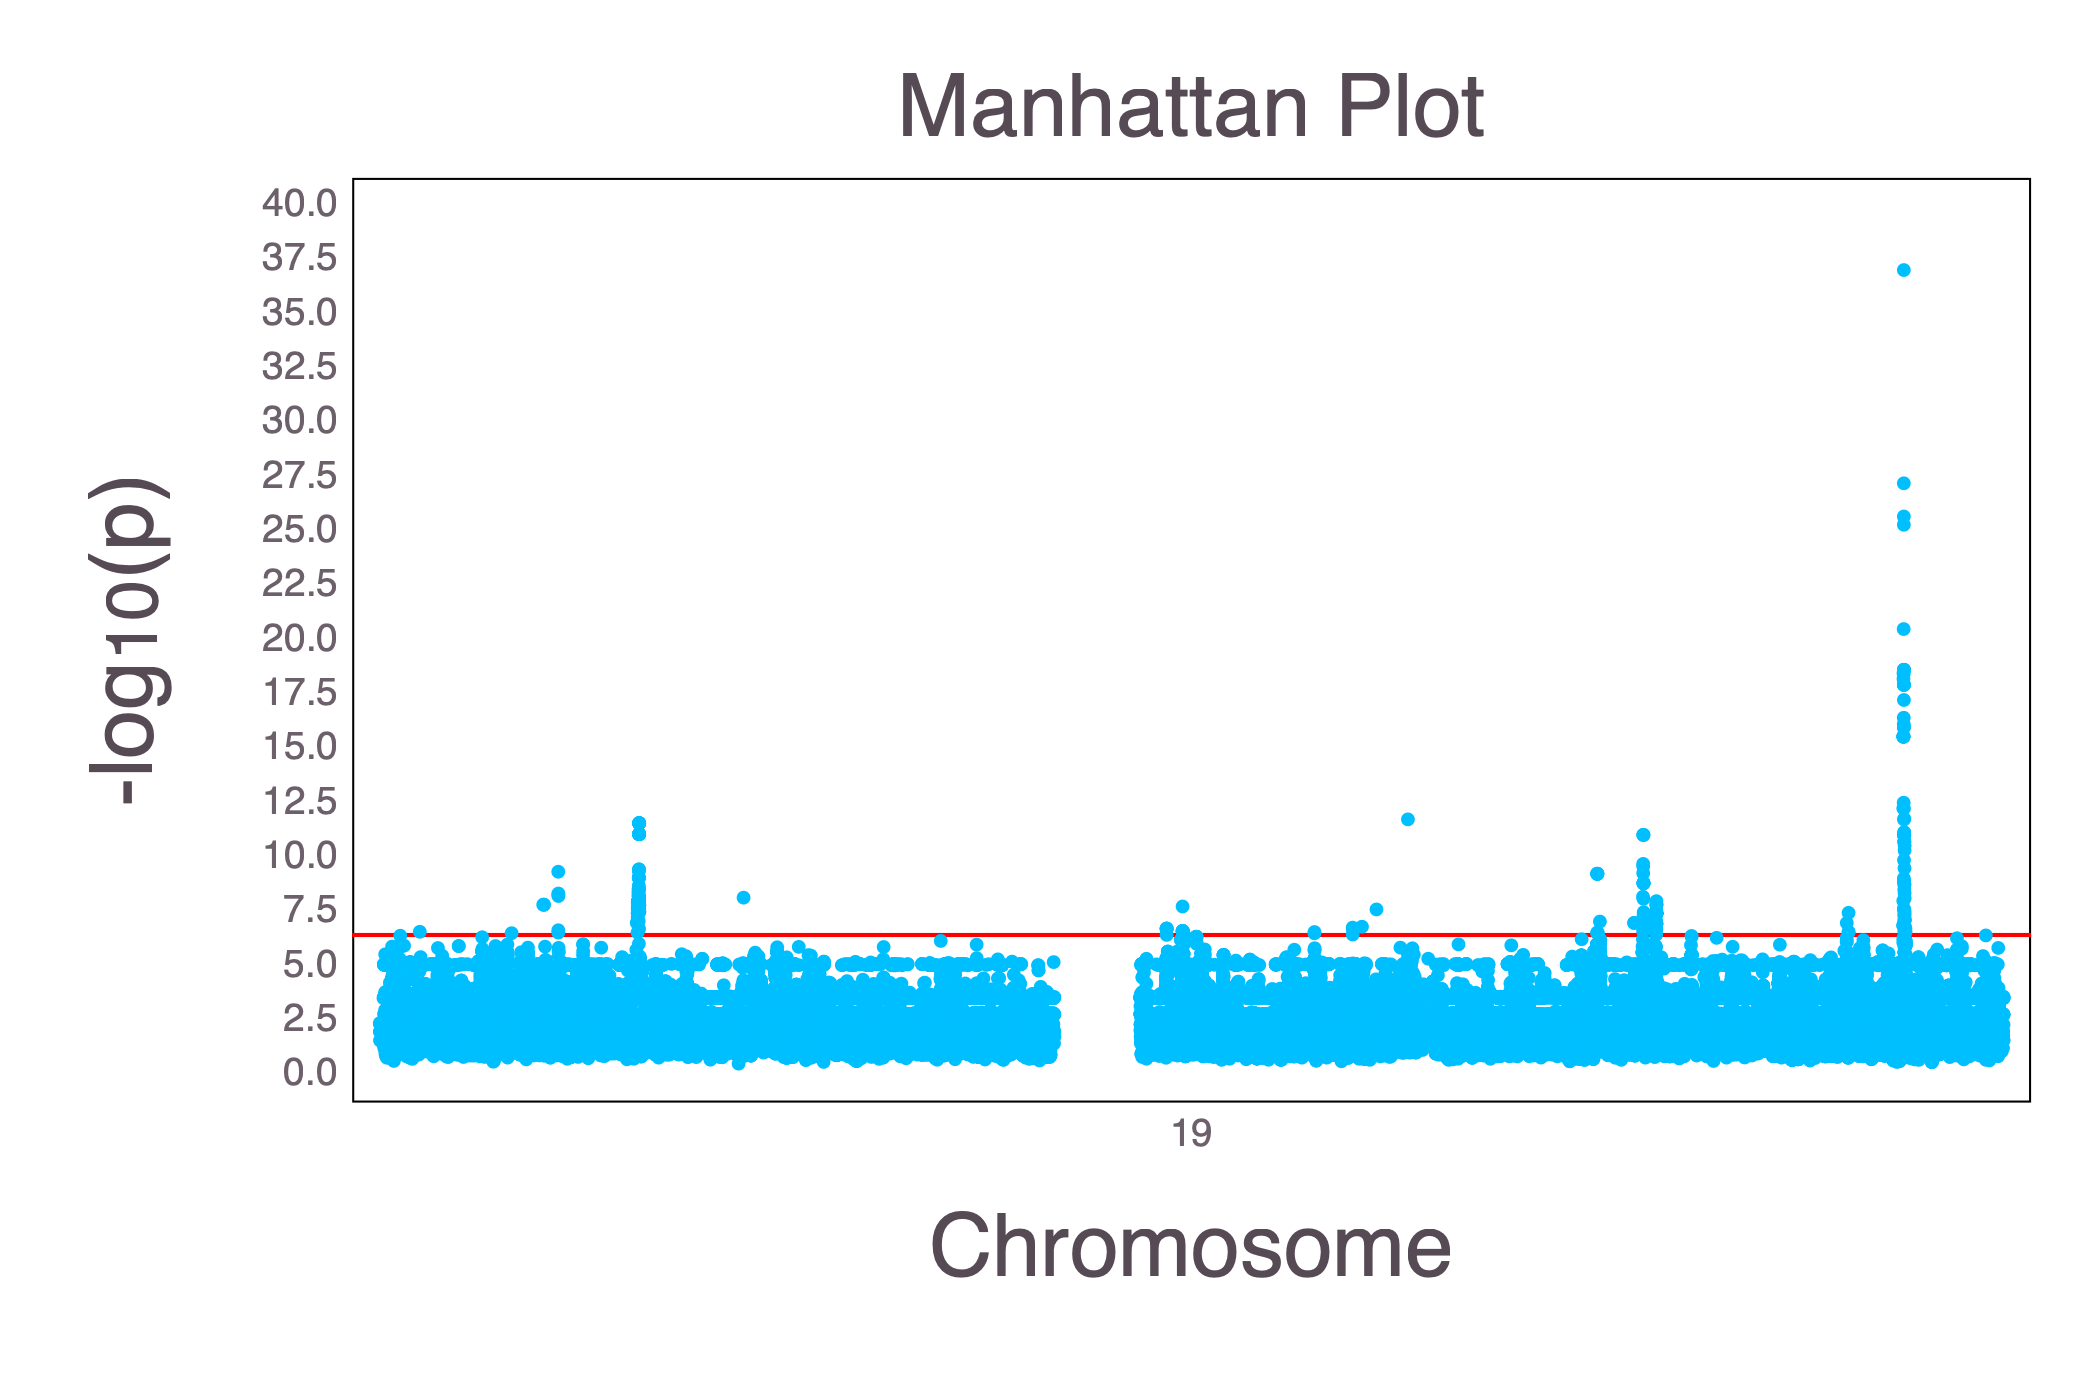

In [56]:
 display("image/png", read("lmmGWAS_manhattan.png")) 

In [100]:
df=filter(row -> row[:5] < 0.000005, plot_frame)

,snpid,AdjBasepairs,Chromosome,MAF,Pvalue
,String,Int64,Int64,Float64,Float64
1,rs187757872,55480864,19,0.231132,2.07651e-6
2,rs172006,55484559,19,0.231132,2.11219e-6
3,rs35121332,55487042,19,0.264151,2.50745e-6
4,rs59004768,55488728,19,0.271226,1.08757e-6
5,rs55799796,55493441,19,0.285377,9.61379e-8
6,rs3826883,55494188,19,0.268868,1.87895e-7
7,rs34804158,55494651,19,0.283019,1.51944e-7
8,rs10412915,55494740,19,0.292453,4.79259e-9
9,rs11672206,55495215,19,0.275943,2.69166e-6


In [101]:
sort(df, :5)

,snpid,AdjBasepairs,Chromosome,MAF,Pvalue
,String,Int64,Int64,Float64,Float64
1,rs10412915,55494740,19,0.292453,4.79259e-9
2,rs55799796,55493441,19,0.285377,9.61379e-8
3,rs34804158,55494651,19,0.283019,1.51944e-7
4,rs3826883,55494188,19,0.268868,1.87895e-7
5,rs59004768,55488728,19,0.271226,1.08757e-6
6,rs2116886,55497039,19,0.290094,1.89318e-6
7,rs71367132,55497506,19,0.290094,1.89318e-6
8,rs1036231,55497843,19,0.290094,1.89318e-6
9,rs1036232,55497943,19,0.290094,1.89318e-6


In [103]:
ind_rs10412915 = findall(x -> x == "rs10412915", snpid)[1]
ind_rs3826883 = findall(x -> x == "rs3826883", snpid)[1]
ind_rs55799796 = findall(x -> x == "rs55799796", snpid)[1]
ind_rs34804158 = findall(x -> x == "rs34804158", snpid)[1]
ind_rs775902 = findall(x -> x == "rs775902", snpid)[1]
ind_rs11672206 = findall(x -> x == "rs11672206", snpid)[1]
ind_rs11667481 = findall(x -> x == "rs11667481", snpid)[1]
ind_rs11671837 = findall(x -> x == "rs11671837", snpid)[1]
ind_rs7253480 = findall(x -> x == "rs7253480", snpid)[1]
ind_rs59004768 = findall(x -> x == "rs59004768", snpid)[1]



snp_10_index=[ind_rs10412915,ind_rs3826883,ind_rs55799796,ind_rs34804158,
              ind_rs775902, ind_rs11672206, ind_rs11667481,ind_rs11671837,
             ind_rs7253480,  ind_rs59004768 ]



snp_10_index[1]


236074

In [82]:
ind_rs10412915 = findall(x -> x == "rs10412915", snpid)[1]
ind_rs3826883 = findall(x -> x == "rs3826883", snpid)[1]
ind_rs55799796 = findall(x -> x == "rs55799796", snpid)[1]
ind_rs34804158 = findall(x -> x == "rs34804158", snpid)[1]
ind_rs775902 = findall(x -> x == "rs775902", snpid)[1]
ind_rs11672206 = findall(x -> x == "rs11672206", snpid)[1]
ind_rs11667481 = findall(x -> x == "rs11667481", snpid)[1]
ind_rs11671837 = findall(x -> x == "rs11671837", snpid)[1]
ind_rs7253480 = findall(x -> x == "rs7253480", snpid)[1]
ind_rs59004768 = findall(x -> x == "rs59004768", snpid)[1]

ind_rs35121332 = findall(x -> x == "rs35121332", snpid)[1]
ind_rs187757872 = findall(x -> x == "rs187757872", snpid)[1]
ind_rs11672206 = findall(x -> x == "rs11672206", snpid)[1]
ind_rs11667481 = findall(x -> x == "rs11667481", snpid)[1]
ind_rs11671837 = findall(x -> x == "rs11671837", snpid)[1]

ind_rs7253480 = findall(x -> x == "rs7253480", snpid)[1]
ind_rs775902 = findall(x -> x == "rs775902", snpid)[1]
ind_rs34261211 = findall(x -> x == "rs34261211", snpid)[1]
ind_rs34548796 = findall(x -> x == "rs34548796", snpid)[1]
ind_rs11672240 = findall(x -> x == "rs11672240", snpid)[1]








snp_20_index=[ind_rs10412915,ind_rs3826883,ind_rs55799796,ind_rs34804158,
              ind_rs775902, ind_rs11672206, ind_rs11667481,ind_rs11671837,
             ind_rs7253480,  ind_rs59004768, ind_rs35121332,ind_rs187757872,
                ind_rs11672206,ind_rs11667481 ,ind_rs11671837,ind_rs7253480,
                ind_rs775902 ,ind_rs34261211 ,ind_rs34548796 ,ind_rs11672240 ]



snp_20_index[1]

128049

In [141]:
Base.copyto!(genovec, @view(snpbinLMM[:, snp_10_index[1]]), 
    model=ADDITIVE_MODEL, center=true, scale=true, impute=true)

212-element Array{Float64,1}:
 -0.4812265031857878
 -0.4812265031857878
 -0.4812265031857878
 -0.4812265031857878
 -0.4812265031857878
  4.1560470729681676
 -0.4812265031857878
 -0.4812265031857878
  1.8374102848911897
  1.8374102848911897
  1.8374102848911897
  1.8374102848911897
  1.8374102848911897
  ⋮
 -0.4812265031857878
 -0.4812265031857878
  1.8374102848911897
 -0.4812265031857878
 -0.4812265031857878
 -0.4812265031857878
 -0.4812265031857878
 -0.4812265031857878
 -0.4812265031857878
 -0.4812265031857878
 -0.4812265031857878
 -0.4812265031857878

In [18]:

using JLD

In [13]:
save("X.jld", "data", X)
save("Trait1.jld", "data", Trait1)
save("V_1.jld", "data", V_1)
save("V_2.jld", "data", V_2)

In [23]:

T = eltype(sex)
genovec  = zeros(T, n)
Base.copyto!(genovec, @view(snpbinLMM[:, snp_10_index[10]]))
V_3=genovec*transpose(genovec)
save("V_3_10.jld", "data", V_3)


In [3]:
function lmm_woodbury(
    y::AbstractVector{T}, 
    X::AbstractMatrix{T},
    Z::Vector{<:AbstractMatrix{T}};
    verbose::Bool = false, 
    maxiter::Integer = 5000, 
    funtol::Number = 1e-8,
    β::Vector{T} = X \ y,
    σ2::Vector{T} = ones(T, length(Z) + 1),
    algo::Symbol = :MM
    ) where T <: LinearAlgebra.BlasFloat
    
    # dimensions
    n, p = size(X)
    m    = length(Z) # no. non-identity variance components  
    qi   = [size(Z[i], 2) for i in 1:m]
    qidx = [[1:qi[1]]; [(sum(qi[1:i-1])+1):sum(qi[1:i]) for i in 2:m]]
    q    = sum(qi)
    # pre-compute fixed quantities
    ztx = [Z[i]' * X    for i in 1:m]           # ztx[i] = Z[i]' * X
    zty = [Z[i]' * y    for i in 1:m]
    ztz = [Z[i]' * Z[j] for i in 1:m, j in 1:m] # ztz[i, j] = Z[i]'Z[j]
    zi2 = [vecnorm(Z[i])^2 for i in 1:m]
    xtx = X'X
    xty = X'y
    # pre-allocate working arrays

    storagen  = zeros(T, n)    # n-by-1 vector
    σztr      = zeros(T, q)    # q-by-1 vector
    storageq  = zeros(T, q)    # q-by-1 vector
    storagep  = zeros(T, p)    # p-by-1 vector
    M         = zeros(T, q, q) # q-by-q matrix
    storageqq = zeros(T, q, q) # q-by-q matrix
    storageqp = zeros(T, q, p) # q-by-p matrix
    storagepp = zeros(T, p, p) # p-by-p matrix
    # pre-allocate views/pointers
    storageqi   = [view(storageq , qidx[i])    for i in 1:m]
    storageqpi  = [view(storageqp, qidx[i], :) for i in 1:m]
    storageqqi  = [view(storageqq, qidx[i], :) for i in 1:m]
    storageqqj  = [view(storageqq, :, qidx[j]) for j in 1:m]
    storageqqij = [view(storageqq, qidx[i], qidx[j]) for i in 1:m, j in 1:m]
    # calculate initial objective value
    σ = sqrt.(σ2)
    res = y - X * β
    update_σztr!(σztr, Z, res, σ, qidx)
    update_woodbury!(storageqp, storageq, storageqq, M, ztx, zty, ztz, σ, qidx)
    Mchol = cholfact!(M, :L)
    A_ldiv_B!(Mchol[:L], σztr)
    loglconst = - n * log(2π)
    logl = (loglconst - - (n - q) * log(σ2[end]) - logdet(Mchol) - 
        (vecnorm(res)^2 - vecnorm(σztr)^2) / σ2[end]) / 2
    verbose && println("iter=", 0, " logl=", logl)
    verbose && println("β=", β," σ2=", σ2)

    
    niter = maxiter
    for iter in 1:maxiter
        # storagen = Ω^{-1} * res
        copy!(storageq, σztr)
        At_ldiv_B!(Mchol[:L], storageq) # storageq = inv(L) * σztr
        copy!(storagen, res)
        for i in 1:m
            BLAS.gemv!('N', -σ[i], Z[i], storageqi[i], T(1), storagen)
        end
        # storageqq = inv(L) * diag(σ) * Z' * Z
        A_ldiv_B!(Mchol[:L], storageqq)
        if algo == :MM 
            # update variance components σ1,..., σm
            for i in 1:m
                At_mul_B!(storageqi[i], Z[i], storagen)
                qf = (vecnorm(storageqi[i]) / σ2[end])^2 # quadratic form
                tr = (zi2[i] - vecnorm(storageqqj[i])^2) / σ2[end] # trace term
                if algo == :MM
                    σ2[i] *= sqrt(qf / tr)
                elseif algo == :EM
                    σ2[i] += (qf - tr) / zrk[i] * σ2[i]^2
                end
            end
            # update σ0
            qf = (vecnorm(storagen) / σ2[end])^2
            At_ldiv_B!(Mchol[:L], storageqq) # storageqq is inv(M) * diag(σ) * Z' * Z
            tr = T(n)
            for i in 1:m
                for j in qidx[i]
                    tr -= σ[i] * storageqq[j, j]
                end
            end
            tr /= σ2[end]

            σ2[end] *= sqrt(qf / tr)

            σ .= sqrt.(σ2)
            
            # update M and other quantities
            update_woodbury!(storageqp, storageq, storageqq, M, ztx, zty, ztz, σ, qidx)
            Mchol = cholfact!(M, :L)
        end
        # update fixed effects
        A_ldiv_B!(Mchol[:L], storageqp) # storageqp is inv(L) * σztx 
        At_mul_B!(storagepp, storageqp, storageqp) 
        storagepp .= xtx .- storagepp # Gram matrix
        if !isposdef(storagepp)
            storagepp += 1e-3I
        end
        A_ldiv_B!(Mchol[:L], storageq) # storageq is inv(L) * σzty 
        copy!(β, xty)
        BLAS.gemv!('T', T(-1), storageqp, storageq, T(1), β) # rhs
        A_ldiv_B!(cholfact!(Symmetric(storagepp)), β)
        # update residuals
        copy!(res, y)
        BLAS.gemv!('N', T(-1), X, β, T(1), res)
        update_σztr!(σztr, Z, res, σ, qidx)
        A_ldiv_B!(Mchol[:L], σztr)
        # check convergence
        loglold = logl
        logl = (loglconst - (n - q) * log(σ2[end]) - logdet(Mchol) - 
            (vecnorm(res)^2 - vecnorm(σztr)^2) / σ2[end]) / 2
        verbose && println("iter=", iter, " logl=", logl)
        verbose && println("β=", β," σ2=", σ2)
        if abs(logl - loglold) < funtol * (abs(logl) + 1)
            niter = iter
            break
        end
    end
    # output
    return β, σ2, niter, logl
end

"""
    update_woodbury!()

Update quantities in Woodbury formula.
"""
function update_woodbury!(
    σztx::Matrix{T},
    σzty::Vector{T},
    σztz::Matrix{T},
    M::Matrix{T},
    ztx::Vector{<:AbstractMatrix{T}},
    zty::Vector{<:AbstractVector{T}},
    ztz::Matrix{<:AbstractMatrix{T}},
    σ::Vector{T},
    qidx::Vector{<:UnitRange}
    ) where T <: AbstractFloat
    m = length(qidx)
    for j in 1:m
        σztx[qidx[j], :] = σ[j] * ztx[j]
        σzty[qidx[j]] = σ[j] * zty[j]
        for i in 1:m
            σztz[qidx[i], qidx[j]] = σ[i] * ztz[i, j]
            M[qidx[i], qidx[j]]    = σ[i] * σ[j] * ztz[i, j]
        end
    end
    σ02 = σ[end] * σ[end]
    for i in 1:size(M, 1)
        M[i, i] += σ02
    end
    σztx, σzty, σztz, M
end

function update_σztr!(
    σztr::Vector{T},
    Z::Vector{<:AbstractMatrix{T}},
    r::Vector{T},
    σ::Vector{T},
    qidx::Vector{<:UnitRange}
    ) where T <: AbstractFloat
    m = length(qidx)
    for i in 1:m
        @views At_mul_B!(σztr[qidx[i]], Z[i], r)
        σztr[qidx[i]] .*= σ[i]
    end
    σztr
end



update_σztr! (generic function with 1 method)

In [99]:
using LinearAlgebra

In [82]:
using JLD

In [4]:
X=load("X.jld")["data"]
Trait1=load("Trait1.jld")["data"]
V_1=load("V_1.jld")["data"]
V_2=eye(212)


┌ Warning: `eye(m::Integer)` has been deprecated in favor of `I` and `Matrix` constructors. For a direct replacement, consider `Matrix(1.0I, m, m)` or `Matrix{Float64}(I, m, m)`. If `Float64` element type is not necessary, consider the shorter `Matrix(I, m, m)` (with default `eltype(I)` `Bool`).
│   caller = top-level scope at In[4]:4
└ @ Core In[4]:4


212×212 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [83]:
V_3_1=load("V_3_1.jld")["data"]
V_3_2=load("V_3_2.jld")["data"]
V_3_3=load("V_3_3.jld")["data"]
V_3_4=load("V_3_4.jld")["data"]
V_3_5=load("V_3_5.jld")["data"]
V_3_6=load("V_3_6.jld")["data"]
V_3_7=load("V_3_7.jld")["data"]
V_3_8=load("V_3_8.jld")["data"]
V_3_9=load("V_3_9.jld")["data"]
V_3_10=load("V_3_10.jld")["data"]

212×212 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [10]:
Z = Array{Matrix{Float64}}(2)
Z[1]=V_1
Z[2]=V_3_5

βhat, σ2hat, iter, obj = lmm_woodbury(Trait1, X, Z; algo = :MM)


┌ Warning: `Array{T}(m::Int) where T` is deprecated, use `Array{T}(undef, m)` instead.
│   caller = top-level scope at In[10]:1
└ @ Core In[10]:1


([40.2138, -6.343], [1.79592, 3.37506e-62, 3.48673], 33, -480.806236051506)

In [24]:
Z[1]

212×212 Array{Float64,2}:
  0.103381   0.103381   0.103381  …   0.569697   0.103381   0.103381
  0.103381   0.103381   0.103381      0.569697   0.103381   0.103381
  0.103381   0.103381   0.103381      0.569697   0.103381   0.103381
  0.569697   0.569697   0.569697      3.13939    0.569697   0.569697
  0.103381   0.103381   0.103381      0.569697   0.103381   0.103381
 -0.362934  -0.362934  -0.362934  …  -2.0       -0.362934  -0.362934
  0.103381   0.103381   0.103381      0.569697   0.103381   0.103381
  0.569697   0.569697   0.569697      3.13939    0.569697   0.569697
 -0.362934  -0.362934  -0.362934     -2.0       -0.362934  -0.362934
  0.103381   0.103381   0.103381      0.569697   0.103381   0.103381
  0.103381   0.103381   0.103381  …   0.569697   0.103381   0.103381
  0.103381   0.103381   0.103381      0.569697   0.103381   0.103381
  0.103381   0.103381   0.103381      0.569697   0.103381   0.103381
  ⋮                               ⋱              ⋮                  
 -0.3629

In [25]:
Z[2]

212×212 Array{Float64,2}:
  0.996528     0.0161756    0.0328655   …   0.049365     0.00363711
  0.0161756    0.996108    -0.0425197      -0.0571855   -0.0453049 
  0.0328655   -0.0425197    0.998884       -0.0439322   -0.0149707 
  0.507253    -0.00321064   0.565085        0.0122539   -0.00678249
  0.252195     0.506729     0.257862       -0.0316892   -0.0126792 
 -0.0299421   -0.00532146  -0.00486768  …   0.00769513   0.0291872 
 -0.0442715    0.0200984   -0.0214025      -0.0296887   -0.00255567
 -0.0325799   -0.0149851   -0.0307441      -0.0326611   -0.00516785
 -0.033358     0.00707175  -0.0257688      -0.0664979   -0.0141568 
 -0.0352202   -0.0199382   -0.0316945      -0.0135175   -0.0244678 
 -0.0325117    0.0187718    0.0128462   …  -0.0102176    0.0337555 
 -0.0334974    0.00829089  -0.0187308      -0.0269726    0.0041904 
 -0.062296     0.00224774  -0.0215881       0.0076621    0.0397269 
  ⋮                                     ⋱   ⋮                      
 -0.0173147   -0.00671

In [19]:
function mm_vcm(
        y,X,maxIter,tol,gamma_t,V)
    gamma_t=zeros(num_gamma,1)
    beta_t=zeros(2,1)
    for i in 1:num_gamma
        gamma_t[i]=var(y)/num_gamma   
    end
    lb=zeros(maxIter,1)
    lb[1]=Inf
    Sigma_t=zeros(212,212)
    for i in 1:num_gamma
        Sigma_t=Sigma_t+gamma_t[i]*V[i]
    end
    for iter in 2:maxIter
        Sigma_t_inv=inv(Sigma_t)
        storagep=Sigma_t_inv*X
        storagepp=transpose(X)*Sigma_t_inv*X
        storagen=Sigma_t_inv*y
        storagenp=transpose(X)*Sigma_t_inv*y
        
        beta_t = inv(storagepp)*storagenp
        res_t = y-X*beta_t 
    
        for i in 1:num_gamma
            storage_sigma=Sigma_t_inv*res_t
            qf=transpose(storage_sigma)*V[i]*storage_sigma
            tr_sigma=tr(Sigma_t_inv*V[i])
            gamma_t[i]=gamma_t[i]*sqrt(qf/tr_sigma)
            
        end
        Sigma_t=zeros(212,212)
        for i in 1:num_gamma
            Sigma_t=Sigma_t+gamma_t[i]*V[i]
        end
        constant = - n/2*log10(2*pi)
        sigma_t_chol = cholesky(Sigma_t)
        chol_res = inv(sigma_t_chol.L)*res_t
        lb[iter] = constant-1/2*log10(det(Sigma_t))-1/2*transpose(chol_res)*chol_res
        if abs(lb[iter] - lb[iter-1]) < tol
            lb=lb[1:iter]
            break
        end
        
    end
    return beta_t, gamma_t
    
end

mm_vcm (generic function with 1 method)

In [4]:
num_gamma=2
V_list=[V_1,I(n)]
gamma_t=zeros(num_gamma,1)

LoadError: UndefVarError: n not defined

In [40]:
mm_vcm(Trait1,X,1000,1e-30,gamma_t,V_list)

([40.1915167257678, -6.294352431575248], [4.885060056042396; 1.9220877760603097])

In [92]:
T = eltype(sex)
genovec  = zeros(T, n)
Base.copyto!(genovec, @view(snpbinLMM[:, snp_10_index[1]]), 
        model=ADDITIVE_MODEL, center=true, scale=true, impute=true)

V_3=genovec*transpose(genovec)

T = eltype(sex)
genovec  = zeros(T, n)
Base.copyto!(genovec, @view(snpbinLMM[:, snp_10_index[2]]), 
        model=ADDITIVE_MODEL, center=true, scale=true, impute=true)

V_4=genovec*transpose(genovec)


genovec  = zeros(T, n)
Base.copyto!(genovec, @view(snpbinLMM[:, snp_10_index[9]]), 
        model=ADDITIVE_MODEL, center=true, scale=true, impute=true)

V_5=genovec*transpose(genovec)
    


num_gamma=4
V_list=[V_1,I(n),V_3,V_5]
gamma_t=zeros(num_gamma,1)

beta_estimate, gamma_estimate=mm_vcm(Trait1,X,1000,1e-30,gamma_t,V_list)
gamma_estimate

4×1 Array{Float64,2}:
 4.7591574430078945
 1.8974076282668095
 0.12659105931136116
 0.015103659018355958

In [242]:
for i in 1:10
    T = eltype(sex)
    genovec  = zeros(T, n)
    Base.copyto!(genovec, @view(snpbinLMM[:, snp_10_index[i]]), 
        model=ADDITIVE_MODEL, center=true, scale=true, impute=true)

    V_3=genovec*transpose(genovec)
    num_gamma=3
    V_list=[V_1,I(n),V_3]
    gamma_t=zeros(num_gamma,1)
    beta_estimate, gamma_estimate=mm_vcm(Trait1,X,1000,1e-30,gamma_t,V_list)
    print(beta_estimate)
    print(gamma_estimate)
end

[40.04084264955176, -6.373200206520906][4.769179321304574; 1.902847288852883; 0.12963877166373253][40.04084264955176, -6.373200206520906][4.852179970148843; 1.9081183942388453; 0.058113458284370235][40.04084264955176, -6.373200206520906][4.88505946257596; 1.9220881077151677; 4.841270186228966e-71][40.04084264955176, -6.373200206520906][4.88506027313342; 1.9220876547404138; 1.0124596195885627e-24][40.04084264955176, -6.373200206520906][4.885059786795568; 1.922087926527145; 4.5934433482740675e-35][40.04084264955176, -6.373200206520906][4.885060273059132; 1.9220876547819306; 5.239930620420489e-36][40.04084264955176, -6.373200206520906][4.885060274132225; 1.922087654182239; 2.518848374593093e-124][40.04084264955176, -6.373200206520906][4.885060063727416; 1.9220877717655864; 4.9066356289657147e-23][40.04084264955176, -6.373200206520906][4.871499661380534; 1.9138336493885442; 0.020938195123514507][40.04084264955176, -6.373200206520906][4.885060273059132; 1.9220876547819306; 5.239930620420489

In [37]:
function info_matrix_new(v3,Sigma_inv)
    info_1=hcat(1/2/212*tr(V_1*Sigma_inv*V_1*Sigma_inv),1/2/212*tr(V_1*Sigma_inv*V_2*Sigma_inv),
    1/2/212*tr(V_1*Sigma_inv*v3*Sigma_inv))

    info_2=hcat(1/2/212*tr(V_2*Sigma_inv*V_1*Sigma_inv),1/2/212*tr(V_2*Sigma_inv*V_2*Sigma_inv),
    1/2/212*tr(V_2*Sigma_inv*v3*Sigma_inv))

    info_3=hcat(1/2/212*tr(v3*Sigma_inv*V_1*Sigma_inv),1/2/212*tr(v3*Sigma_inv*V_2*Sigma_inv),
    1/2/212*tr(v3*Sigma_inv*v3*Sigma_inv))
    
    info_matrix_part=vcat(info_1,info_2,info_3)
    info_contained=vcat(hcat(1/212*transpose(X)*Sigma_inv*X,zeros(2,3)),hcat(zeros(3,2),info_matrix_part))
    return info_contained
end

info_matrix_new (generic function with 1 method)

In [38]:
function cubic_new(x)
    x
end


function quartic_new(x)
    x
end



quartic_new (generic function with 1 method)

In [39]:
function j_matrix_function_new(v3,Sigma,epsilon)
    L_matrix=cholesky(Sigma) ##use L_matrix.L
    
    mu_3=sum(cubic_new,inv(L_matrix.L)*epsilon)
    mu_4=sum(quartic_new,inv(L_matrix.L)*epsilon)
    
    sub_matrix_1=L_matrix.U*Sigma_inv*X
    sub_matrix_2=L_matrix.U*Sigma_inv*V_1*Sigma_inv*L_matrix.L
    sub_matrix_3=L_matrix.U*Sigma_inv*V_2*Sigma_inv*L_matrix.L

    
    sub_matrix_4=L_matrix.U*Sigma_inv*v3*Sigma_inv*L_matrix.L ##only one need to change
    J_trace_l=zeros(2,3)
    for l in 1:2
        trace_initial_1=trace_initial_2=trace_initial_3=0
        for k in 1:212
            trace_initial_1+=sub_matrix_1[k,l]*sub_matrix_2[k,k]  ##11   
            trace_initial_2+=sub_matrix_1[k,l]*sub_matrix_3[k,k]  ##12
            trace_initial_3+=sub_matrix_1[k,l]*sub_matrix_4[k,k]  ##13
        
        end
        J_trace_l[l,1]=trace_initial_1
        J_trace_l[l,2]=trace_initial_2
        J_trace_l[l,3]=trace_initial_3
    end
    
    J_trace_2=zeros(3,3)

    trace_initial_1=trace_initial_2=trace_initial_3=0
    for k in 1:212
        trace_initial_1+=sub_matrix_2[k,k]*sub_matrix_2[k,k]  ##11   
        trace_initial_2+=sub_matrix_2[k,k]*sub_matrix_3[k,k]  ##12
        trace_initial_3+=sub_matrix_2[k,k]*sub_matrix_4[k,k]  ##13        
    end
    J_trace_2[1,1]=trace_initial_1
    J_trace_2[1,2]=trace_initial_2
    J_trace_2[1,3]=trace_initial_3  ##may change

    trace_initial_1=trace_initial_2=trace_initial_3=0
    for k in 1:212
        trace_initial_1+=sub_matrix_3[k,k]*sub_matrix_2[k,k]  ##21   
        trace_initial_2+=sub_matrix_3[k,k]*sub_matrix_3[k,k]  ##22
        trace_initial_3+=sub_matrix_3[k,k]*sub_matrix_4[k,k]  ##23        
    end
    J_trace_2[2,1]=trace_initial_1
    J_trace_2[2,2]=trace_initial_2
    J_trace_2[2,3]=trace_initial_3 ##may change

    trace_initial_1=trace_initial_2=trace_initial_3=0
    for k in 1:212
        trace_initial_1+=sub_matrix_4[k,k]*sub_matrix_2[k,k]  ##11   
        trace_initial_2+=sub_matrix_4[k,k]*sub_matrix_3[k,k]  ##12
        trace_initial_3+=sub_matrix_4[k,k]*sub_matrix_4[k,k]  ##13        
    end
    J_trace_2[3,1]=trace_initial_1 ##may change
    J_trace_2[3,2]=trace_initial_2 ##may change
    J_trace_2[3,3]=trace_initial_3 ##may change


    
    J_matrix=zeros(5,5)
    J_matrix[1:2,3:5]=1/2/212*mu_3*J_trace_l
    J_matrix[3:5,1:2]=transpose(1/2/212*mu_3*J_trace_l)
    J_matrix[3:5,3:5]=1/4/n*(mu_4-3)*J_trace_2
    return J_matrix
      
    
end

j_matrix_function_new (generic function with 1 method)

In [90]:
num_gamma=3
V_list=[V_1,I(n),V_3]

3-element Array{AbstractArray{T,2} where T,1}:
 [0.9965278390545285 0.016175598960190257 … 0.049364950106970104 0.0036371137088662517; 0.016175598960190257 0.9961084147670148 … -0.057185470475839786 -0.0453049323225698; … ; 0.049364950106970104 -0.057185470475839786 … 1.1879972204215146 0.09941666080093772; 0.0036371137088662517 -0.0453049323225698 … 0.09941666080093772 0.9834853560929147]
 Bool[1 0 … 0 0; 0 1 … 0 0; … ; 0 0 … 1 0; 0 0 … 0 1]
 [0.23157894736842105 0.23157894736842105 … 0.23157894736842105 0.23157894736842105; 0.23157894736842105 0.23157894736842105 … 0.23157894736842105 0.23157894736842105; … ; 0.23157894736842105 0.23157894736842105 … 0.23157894736842105 0.23157894736842105; 0.23157894736842105 0.23157894736842105 … 0.23157894736842105 0.23157894736842105]

In [94]:
V=V_list

3-element Array{AbstractArray{T,2} where T,1}:
 [0.9965278390545285 0.016175598960190257 … 0.049364950106970104 0.0036371137088662517; 0.016175598960190257 0.9961084147670148 … -0.057185470475839786 -0.0453049323225698; … ; 0.049364950106970104 -0.057185470475839786 … 1.1879972204215146 0.09941666080093772; 0.0036371137088662517 -0.0453049323225698 … 0.09941666080093772 0.9834853560929147]
 Bool[1 0 … 0 0; 0 1 … 0 0; … ; 0 0 … 1 0; 0 0 … 0 1]
 [0.23157894736842105 0.23157894736842105 … 0.23157894736842105 0.23157894736842105; 0.23157894736842105 0.23157894736842105 … 0.23157894736842105 0.23157894736842105; … ; 0.23157894736842105 0.23157894736842105 … 0.23157894736842105 0.23157894736842105; 0.23157894736842105 0.23157894736842105 … 0.23157894736842105 0.23157894736842105]

In [95]:
for i in 1:20
    T = eltype(sex)
    genovec  = zeros(T, n)
    Base.copyto!(genovec, @view(snpbinLMM[:, snp_20_index[i]]), 
        model=ADDITIVE_MODEL, center=true, scale=true, impute=true)

    V_3=genovec*transpose(genovec) 
    num_gamma=3
    V_list=[V_1,I(n),V_3]
    gamma_t=zeros(num_gamma,1)
    beta_estimate, gamma_estimate=mm_vcm(Trait1,X,1000,1e-60,gamma_t,V_list)
    
    epsilon=Trait1-X*beta_estimate
    Sigma=zeros(212,212)
    for i in 1:num_gamma
        Sigma=Sigma+gamma_estimate[i]*V[i]
    end
    Sigma_inv=inv(Sigma)
    I_matrix=100*info_matrix_new(V_3,Sigma_inv)
    I_matrix_inv=inv(I_matrix)
    J_matrix=j_matrix_function_new(V_3,Sigma,epsilon)
    variance_matrix=I_matrix_inv+I_matrix_inv*J_matrix*I_matrix_inv
    
    sd=zeros(3,1)
    sd[1]=sqrt(variance_matrix[3,3])
    sd[2]=sqrt(variance_matrix[4,4])
    sd[3]=sqrt(variance_matrix[5,5])
    
    hratio=(gamma_estimate[1]+gamma_estimate[3])/sum(gamma_estimate)
    
    println(gamma_estimate)
    println(sd)
    println(hratio)
    
end

[4.769179321304574; 1.902847288852883; 0.12963877166373253]
[1.5072830476721042; 0.8014575604979581; 0.33488441859079116]
0.7202380325943962
[4.852179970148843; 1.9081183942388453; 0.058113458284370235]
[1.528198486523812; 0.8079692684776502; 0.08605536637372144]
0.7201520758992414
[4.88505946257596; 1.9220881077151677; 4.841270186228966e-71]
[1.5338229309923241; 0.8119882618080203; 0.08224248748227866]
0.7176367798894414
[4.88506027313342; 1.9220876547404138; 1.0124596195885627e-24]
[1.5338461774385443; 0.8119853669740364; 0.07383683379876894]
0.7176368612661008
[4.885059786795568; 1.922087926527145; 4.5934433482740675e-35]
[1.5352785512277638; 0.8119886173252199; 0.06386474171459657]
0.7176368124397681
[4.885060273059132; 1.9220876547819306; 5.239930620420489e-36]
[1.535278595531955; 0.8119885815754594; 0.06386474329167068]
0.7176368612586425
[4.885060274132225; 1.922087654182239; 2.518848374593093e-124]
[1.5338740327588893; 0.8119821676751587; 0.07860536718652067]
0.7176368613663766

In [108]:
num_gamma=3

3

In [110]:
for i in 2:2
    T = eltype(sex)
    genovec  = zeros(T, n)
    Base.copyto!(genovec, @view(snpbinLMM[:, snp_10_index[i]]), 
        model=ADDITIVE_MODEL, center=true, scale=true, impute=true)

    V_3=genovec*transpose(genovec) 
    num_gamma=3
    
    col_index=findall(x->x=="rs3826883", snpLMM_alt)
    V_1=grm(snpbinLMM; method = :GRM, minmaf=0.05,cinds=1:size(snpbinLMM, 2) .!= col_index[1][1])
    
    V_list=[V_1,I(n),V_3]
    gamma_t=zeros(num_gamma,1)
    beta_estimate, gamma_estimate=mm_vcm(Trait1,X,1000,1e-60,gamma_t,V_list)
    
    
    
    println(gamma_estimate)

    
end

[8.214225405763727; 1.6624017852001185; 1.272902465204686]


Totally NEW!!!!!!

In [3]:
pedLMM = readdlm("SNP_29a.fam", ','; header = false)
Trait1 = convert(Vector{Float64}, pedLMM[:, 7])
# Trait2 = convert(Vector{Float64}, pedLMM[:, 8])
# Y = [Trait1 Trait2]
sex = map(x -> strip(x) == "F" ? 1.0 : 0.0,  pedLMM[:, 5])

snpbinLMM = SnpArray("SNP_29a.bed")

snpLMM_alt = readdlm("SNP_29a.bim"; header = false) ##no maf
snpLMM_alt[2231,2]="rs549777"
snpLMM_alt[2852,2]="rs621712"
snpLMM_alt[9201,2]="rs1816523"
snpLMM_alt[15063,2]="rs2939233"
snpLMM_alt[22568,2]="rs4511278"
snpLMM_alt[22569,2]="rs4511350"
snpLMM_alt[22577,2]="rs4511830"
snpLMM_alt[22578,2]="rs4511927"
snpLMM_alt[22586,2]="rs4512514"
snpLMM_alt[24082,2]="rs4816627"
snpLMM_alt[26206,2]="rs5260878"

snpLMM = readdlm("SNP_29a.bim"; header = false)
snpLMM[2231,2]="rs549777"
snpLMM[2852,2]="rs621712"
snpLMM[9201,2]="rs1816523"
snpLMM[15063,2]="rs2939233"
snpLMM[22568,2]="rs4511278"
snpLMM[22569,2]="rs4511350"
snpLMM[22577,2]="rs4511830"
snpLMM[22578,2]="rs4511927"
snpLMM[22586,2]="rs4512514"
snpLMM[24082,2]="rs4816627"
snpLMM[26206,2]="rs5260878"

snpLMM = snpLMM[maf(snpbinLMM) .> 0.05,:]
snpid = map(x -> strip(string(x)), snpLMM[:, 2])

n, snps = size(snpbinLMM[:,maf(snpbinLMM) .> 0.05])
X = [ones(n) sex]
p = size(X,2)  # no. covariates
n, snps, p


(212, 137741, 2)

In [340]:
snpLMM

137741×6 Array{Any,2}:
 19  "rs56343121"   0     91106  1  2
 19  "rs56182540"   0     95981  1  2
 19  "rs7260412"    0    105021  1  2
 19  "rs8106297"    0    107958  1  2
 19  "rs8106302"    0    107962  1  2
 19  "rs186451972"  0    108003  1  2
 19  "rs76534612"   0    226776  1  2
 19  "rs1975526"    0    240867  1  2
 19  "rs62103026"   0    244421  1  2
 19  "rs62103027"   0    244426  1  2
 19  "rs67286684"   0    245631  1  2
 19  "rs59441037"   0    245844  1  2
 19  "rs57114567"   0    245867  1  2
  ⋮                                 ⋮
 19  "rs140264059"  0  59111982  1  2
 19  "rs62114717"   0  59112097  1  2
 19  "rs188169422"  0  59116080  1  2
 19  "rs139879509"  0  59117949  1  2
 19  "rs143250448"  0  59117982  1  2
 19  "rs145384750"  0  59118028  1  2
 19  "rs149215836"  0  59118040  1  2
 19  "rs139221927"  0  59118044  1  2
 19  "rs181848453"  0  59118114  1  2
 19  "rs186913222"  0  59118616  1  2
 19  "rs141816674"  0  59118779  1  2
 19  "rs150801216"  0  5911

In [342]:
string("rs",strip(string(664)))

"rs664"

In [343]:
snpLMM_alt = readdlm("SNP_29a.bim"; header = false)
stringtry = map(x -> string("rs",strip(string(x))), snpLMM[:, 4])

137741-element Array{String,1}:
 "rs91106"
 "rs95981"
 "rs105021"
 "rs107958"
 "rs107962"
 "rs108003"
 "rs226776"
 "rs240867"
 "rs244421"
 "rs244426"
 "rs245631"
 "rs245844"
 "rs245867"
 ⋮
 "rs59111982"
 "rs59112097"
 "rs59116080"
 "rs59117949"
 "rs59117982"
 "rs59118028"
 "rs59118040"
 "rs59118044"
 "rs59118114"
 "rs59118616"
 "rs59118779"
 "rs59118783"

Use this!!!! Now SNP ID is "rs"+location ID

In [4]:
pedLMM = readdlm("SNP_29a.fam", ','; header = false)
Trait1 = convert(Vector{Float64}, pedLMM[:, 7])
# Trait2 = convert(Vector{Float64}, pedLMM[:, 8])
# Y = [Trait1 Trait2]
sex = map(x -> strip(x) == "F" ? 1.0 : 0.0,  pedLMM[:, 5])

snpbinLMM = SnpArray("SNP_29a.bed")

snpLMM_alt = readdlm("SNP_29a.bim"; header = false) ##no maf
snpLMM_alt[:,2]= map(x -> string("rs",strip(string(x))), snpLMM_alt[:, 4])

snpLMM = readdlm("SNP_29a.bim"; header = false)
snpLMM[:,2]= map(x -> string("rs",strip(string(x))), snpLMM[:, 4])


snpLMM = snpLMM[maf(snpbinLMM) .> 0.05,:]
snpid = map(x -> strip(string(x)), snpLMM[:, 2])


row_index=Array((1:253141))
col_index_save=row_index[maf(snpbinLMM) .> 0.05]

n, snps = size(snpbinLMM[:,maf(snpbinLMM) .> 0.05])
X = [ones(n) sex]
p = size(X,2)  # no. covariates
n, snps, p


(212, 137741, 2)

In [356]:
row_index=Array((1:253141))


253141-element Array{Int64,1}:
      1
      2
      3
      4
      5
      6
      7
      8
      9
     10
     11
     12
     13
      ⋮
 253130
 253131
 253132
 253133
 253134
 253135
 253136
 253137
 253138
 253139
 253140
 253141

In [359]:
col_index_save=row_index[maf(snpbinLMM) .> 0.05]

137741-element Array{Int64,1}:
      2
      4
      5
      8
      9
     11
     26
     32
     34
     35
     36
     37
     38
      ⋮
 253126
 253127
 253130
 253132
 253133
 253134
 253135
 253136
 253137
 253139
 253140
 253141

In [360]:
col_index_save[1]

2

##col_index_save=zeros(snps,1)

!!DO NOT RUN THE NEXT STATEMENT!!!!

In [352]:
findall(x->x==0, col_index_save)


120159-element Array{CartesianIndex{2},1}:
 CartesianIndex(17583, 1)
 CartesianIndex(17584, 1)
 CartesianIndex(17585, 1)
 CartesianIndex(17586, 1)
 CartesianIndex(17587, 1)
 CartesianIndex(17588, 1)
 CartesianIndex(17589, 1)
 CartesianIndex(17590, 1)
 CartesianIndex(17591, 1)
 CartesianIndex(17592, 1)
 CartesianIndex(17593, 1)
 CartesianIndex(17594, 1)
 CartesianIndex(17595, 1)
 ⋮
 CartesianIndex(137730, 1)
 CartesianIndex(137731, 1)
 CartesianIndex(137732, 1)
 CartesianIndex(137733, 1)
 CartesianIndex(137734, 1)
 CartesianIndex(137735, 1)
 CartesianIndex(137736, 1)
 CartesianIndex(137737, 1)
 CartesianIndex(137738, 1)
 CartesianIndex(137739, 1)
 CartesianIndex(137740, 1)
 CartesianIndex(137741, 1)

In [358]:
col_index_save

137741×1 Array{Float64,2}:
  2.0
  4.0
  5.0
  8.0
  9.0
 11.0
 26.0
 32.0
 34.0
 35.0
 36.0
 37.0
 38.0
  ⋮
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [347]:
snpid[2]

"rs95981"

In [351]:

for i in 17583:snps
    col_index=findall(x->x==snpid[i], snpLMM_alt)
    col_index_save[i]=col_index[1][1]
    print(col_index_save[i])
end

26267.026268.026273.026276.026277.026279.026280.026281.026282.026283.026285.026287.026288.026289.026290.026291.026292.026295.026297.026301.026302.026303.026304.026305.026308.026310.026311.026313.026315.026317.026319.026320.026324.026328.026329.026330.026331.026332.026333.026334.026335.026336.026337.026338.026339.026340.026341.026344.026348.026349.026350.026352.026353.026360.026361.026362.026363.026364.026365.026366.026368.026370.026371.026372.026374.026380.026382.026383.026384.026386.026389.026392.026393.026394.026395.026396.026398.026401.026402.026404.026405.026408.026410.026412.026413.026414.026416.026418.026422.026424.026427.026431.026437.026440.026442.026444.026446.026448.026449.026450.026451.026454.026455.026456.026458.026459.026460.026465.026466.026467.026470.026471.026474.026475.026476.026479.026485.026487.026488.026489.026494.026495.026497.026498.026499.026501.026502.026503.026506.026507.026511.026512.026513.026514.026515.026516.026518.026519.026520.026522.026526.026528.026530.

28516.028517.028518.028519.028521.028523.028526.028527.028528.028530.028531.028535.028540.028541.028542.028548.028550.028552.028558.028560.028562.028563.028564.028572.028573.028574.028579.028586.028587.028591.028592.028594.028596.028601.028606.028609.028610.028616.028618.028620.028621.028622.028626.028630.028631.028634.028636.028638.028642.028645.028647.028649.028651.028655.028657.028662.028667.028671.028676.028679.028682.028685.028687.028688.028689.028693.028698.028706.028707.028708.028709.028711.028712.028714.028717.028718.028722.028723.028724.028725.028726.028728.028729.028730.028731.028735.028736.028741.028742.028743.028744.028746.028749.028756.028759.028761.028763.028765.028768.028769.028771.028776.028779.028780.028785.028792.028794.028795.028796.028797.028799.028804.028805.028806.028807.028808.028809.028810.028811.028813.028814.028816.028817.028819.028823.028827.028828.028830.028831.028832.028833.028834.028835.028836.028837.028839.028841.028843.028844.028845.028848.028849.028852.

31266.031267.031268.031269.031270.031271.031275.031276.031278.031281.031282.031283.031285.031288.031290.031291.031292.031293.031295.031299.031302.031305.031306.031307.031308.031309.031310.031311.031312.031313.031314.031316.031317.031318.031319.031321.031322.031326.031336.031338.031339.031341.031342.031343.031344.031345.031346.031347.031348.031349.031350.031351.031357.031359.031363.031364.031367.031368.031369.031370.031373.031376.031377.031380.031381.031382.031383.031385.031386.031388.031391.031394.031396.031398.031400.031401.031403.031405.031407.031414.031416.031417.031418.031419.031420.031425.031426.031431.031432.031433.031435.031436.031438.031439.031441.031442.031443.031445.031448.031449.031451.031452.031453.031458.031459.031464.031473.031477.031482.031484.031487.031494.031511.031513.031514.031528.031531.031532.031533.031534.031536.031538.031539.031540.031541.031542.031544.031548.031550.031554.031558.031561.031562.031563.031564.031565.031569.031570.031571.031573.031575.031585.031592.

LoadError: InterruptException:

In [ ]:
save("col_index_save.jld", "data", col_index_save)

In [335]:
snpid[14497]

"5260878"

In [348]:

findall(x->x=="rs95981", snpLMM_alt)


1-element Array{CartesianIndex{2},1}:
 CartesianIndex(4, 2)

In [349]:
snpLMM_alt[4,:]

6-element Array{Any,1}:
    19
      "rs95981"
     0
 95981
     1
     2

In [279]:
snpid[5105]


"1816523"

In [246]:
snpLMM_alt[2231,2]="rs549777"

"rs549777"

In [247]:
snpLMM_alt[2231,:]

6-element Array{Any,1}:
     19
       "rs549777"
      0
 549777
      1
      2

In [242]:

findall(x->strip(string(x))=="549777", snpLMM_alt)

2-element Array{CartesianIndex{2},1}:
 CartesianIndex(2231, 2)
 CartesianIndex(2231, 4)

In [5]:
col_index=findall(x->x==snpid[1], snpLMM_alt)
V_1_old=grm(snpbinLMM; method = :GRM, minmaf=0.05,cinds=1:size(snpbinLMM, 2) .!= col_index[1][1])
                ###V_1 need to change
V_1=2V_1_old

snp_index=1
snpsidx = vcat(1:size(snpbinLMM,2))[maf(snpbinLMM) .> 0.05]
T = eltype(sex)
genovec  = zeros(T, n)
Base.copyto!(genovec, @view(snpbinLMM[:, snpsidx[snp_index]]), 
        model=ADDITIVE_MODEL, center=true, scale=true, impute=true)

V_3=genovec*transpose(genovec) 


212×212 Array{Float64,2}:
  0.179949   0.179949   0.179949  …   0.179949   0.179949   0.179949
  0.179949   0.179949   0.179949      0.179949   0.179949   0.179949
  0.179949   0.179949   0.179949      0.179949   0.179949   0.179949
  0.179949   0.179949   0.179949      0.179949   0.179949   0.179949
  0.179949   0.179949   0.179949      0.179949   0.179949   0.179949
  0.179949   0.179949   0.179949  …   0.179949   0.179949   0.179949
 -0.910026  -0.910026  -0.910026     -0.910026  -0.910026  -0.910026
  0.179949   0.179949   0.179949      0.179949   0.179949   0.179949
 -0.910026  -0.910026  -0.910026     -0.910026  -0.910026  -0.910026
 -0.910026  -0.910026  -0.910026     -0.910026  -0.910026  -0.910026
 -0.910026  -0.910026  -0.910026  …  -0.910026  -0.910026  -0.910026
  0.179949   0.179949   0.179949      0.179949   0.179949   0.179949
 -0.910026  -0.910026  -0.910026     -0.910026  -0.910026  -0.910026
  ⋮                               ⋱              ⋮         
  0.179949   0.17

In [13]:
nulldata    = VarianceComponentVariate(Trait1, X, (V_1, Matrix{Float64}(I, n, n)))
nulldatarot = TwoVarCompVariateRotate(nulldata)
nullmodel   = VarianceComponentModel(nulldata)
logl_null,newvcmodel,_,Σcov, = mle_mm!(nullmodel, nulldatarot; verbose = true)

newvcmodel.B
newvcmodel.Σ


     MM Algorithm
  Iter      Objective  
--------  -------------
       0  -1.487536e+05
       1  -6.267767e+02
       2  -5.433439e+02
       3  -5.134418e+02
       4  -5.029523e+02
       5  -4.984667e+02
       6  -4.957331e+02
       7  -4.935808e+02
       8  -4.917270e+02
       9  -4.901153e+02
      10  -4.887335e+02
      20  -4.832204e+02
      30  -4.825718e+02
      40  -4.824907e+02
      50  -4.824798e+02
      60  -4.824783e+02
      70  -4.824781e+02



([4.9007196620890925], [1.8530948184022547])

In [14]:
newvcmodel.Σ[1][1]

4.9007196620890925

In [15]:
Sigma=V_1*UniformScaling(newvcmodel.Σ[1][1])+I(n)*UniformScaling(newvcmodel.Σ[2][1])
Sigma_inv=inv(Sigma)
epsilon=Trait1-X*newvcmodel.B

212×1 Array{Float64,2}:
 -4.683582413111996
 -2.087432413111994
 -2.3767855298098226
 -5.117855529809823
 -5.560202413111995
  2.290067586888007
  2.682774470190175
  0.784944470190176
  1.6611575868880024
  7.862264470190176
  3.7164375868880057
  6.169304470190177
  1.168597586888005
  ⋮
 -1.3384555298098206
  2.016924470190176
  0.062074470190175646
  2.2012275868880025
 -2.4710055298098226
  0.2618244701901773
 -3.5997955298098248
 -0.03297552980982488
  3.9239744701901813
 -2.4019755298098246
 -1.2356155298098201
  0.31490447019017864

In [16]:
num_gamma=2
V_list=[V_1,I(n)]
gamma_t=zeros(num_gamma,1)
beta_estimate, gamma_estimate=mm_vcm(Trait1,X,1000,1e-60,gamma_t,V_list)

([40.19819828950973, -6.308955436866825], [4.906162888556458; 1.849875305638971])

In [17]:
Sigma=V_1*UniformScaling(gamma_estimate[1])+I(n)*UniformScaling(gamma_estimate[2])
Sigma_inv=inv(Sigma)
epsilon=Trait1-X*beta_estimate

score_v1=1/2*transpose(epsilon)*Sigma_inv*V_1*Sigma_inv*epsilon-tr(Sigma_inv*V_1*Sigma_inv)
score_v2=1/2*transpose(epsilon)*Sigma_inv*I(n)*Sigma_inv*epsilon-tr(Sigma_inv*I(n)*Sigma_inv)
score_v3=1/2*transpose(epsilon)*Sigma_inv*V_3*Sigma_inv*epsilon-tr(Sigma_inv*V_3*Sigma_inv)   ##need to change

29.079162975312155

In [18]:
function score_function(v1,v3)
    
    score_v1=1/2*transpose(epsilon)*Sigma_inv*v1*Sigma_inv*epsilon-[tr(Sigma_inv*v1*Sigma_inv)]
    score_v2=1/2*transpose(epsilon)*Sigma_inv*I(n)*Sigma_inv*epsilon-[tr(Sigma_inv*I(n)*Sigma_inv)]
    score_v3=1/2*transpose(epsilon)*Sigma_inv*v3*Sigma_inv*epsilon-[tr(Sigma_inv*v3*Sigma_inv)]  ##need to change
    score_func=vcat(transpose(X)*Sigma_inv*epsilon,score_v1,score_v2,score_v3)
    return score_func
    
end

score_function (generic function with 1 method)

In [197]:
score_function(v1,v3)
    

5×1 Array{Float64,2}:
  3.803474515666017e-12
  2.5815695164770993e-12
  8.557555551970793
 10.492094830711311
 29.109329658994163

In [6]:
function new_info_matrix(v1,v3)
    info_1=hcat(1/2/212*tr(v1*Sigma_inv*v1*Sigma_inv),1/2/212*tr(v1*Sigma_inv*V_2*Sigma_inv),
    1/2/212*tr(v1*Sigma_inv*v3*Sigma_inv))

    info_2=hcat(1/2/212*tr(V_2*Sigma_inv*v1*Sigma_inv),1/2/212*tr(V_2*Sigma_inv*V_2*Sigma_inv),
    1/2/212*tr(V_2*Sigma_inv*v3*Sigma_inv))

    info_3=hcat(1/2/212*tr(v3*Sigma_inv*v1*Sigma_inv),1/2/212*tr(v3*Sigma_inv*V_2*Sigma_inv),
    1/2/212*tr(v3*Sigma_inv*v3*Sigma_inv))
    
    info_matrix_part=vcat(info_1,info_2,info_3)
    info_contained=vcat(hcat(1/212*transpose(X)*Sigma_inv*X,zeros(2,3)),hcat(zeros(3,2),info_matrix_part))
    return info_contained
end

new_info_matrix (generic function with 1 method)

In [198]:
quasi_score=1/212*transpose(score_function(V_1,V_3))*inv(new_info_matrix(V_1,V_3))*score_function(V_1,V_3)

1×1 Array{Float64,2}:
 42.435016207725454

In [199]:
new_info_matrix(v1,v3)

5×5 Array{Float64,2}:
 0.539638  0.24691   0.0         0.0         0.0
 0.24691   0.160525  0.0         0.0         0.0
 0.0       0.0       0.00856204  0.0109407   0.00701458
 0.0       0.0       0.0109407   0.0278541   0.00950203
 0.0       0.0       0.00701458  0.00950203  1.14582

In [137]:
info_contained_1_part=new_info_matrix(V_1,V_3)[1:4,1:4]
info_contained_1=vcat(hcat(inv(info_contained_1_part),zeros(4,1)),hcat(zeros(1,4),zeros(1,1)))

5×5 Array{Float64,2}:
  6.25209  -9.62133    0.0      -0.0     0.0
 -9.62133  21.0281     0.0      -0.0     0.0
  0.0       0.0      234.622   -92.0805  0.0
  0.0       0.0      -92.0805   72.0039  0.0
  0.0       0.0        0.0       0.0     0.0

In [23]:
L_matrix=cholesky(Sigma) ##use L_matrix.L
sub_matrix_1=L_matrix.U*Sigma_inv*X
sub_matrix_2=L_matrix.U*Sigma_inv*V_1*Sigma_inv*L_matrix.L## need to change
sub_matrix_3=L_matrix.U*Sigma_inv*V_2*Sigma_inv*L_matrix.L
sub_matrix_4=L_matrix.U*Sigma_inv*V_3*Sigma_inv*L_matrix.L ## need to change

212×212 Array{Float64,2}:
  0.0206174    0.0216488    0.0221598   …   0.00626325   0.0144726
  0.0216488    0.0227317    0.0232683       0.00657656   0.0151965
  0.0221598    0.0232683    0.0238176       0.00673181   0.0155553
  0.00968122   0.0101655    0.0104055       0.002941     0.00679581
  0.00684357   0.00718591   0.00735554      0.00207897   0.00480389
  0.0249578    0.0262063    0.026825    …   0.0075818    0.0175194
 -0.121194    -0.127257    -0.130261       -0.0368169   -0.0850732
  0.020964     0.0220127    0.0225323       0.00636854   0.0147158
 -0.103525    -0.108703    -0.111269       -0.0314492   -0.07267
 -0.09391     -0.0986077   -0.100935       -0.0285284   -0.0659208
 -0.0876676   -0.092053    -0.0942261   …  -0.0266321   -0.0615389
  0.0938604    0.0985556    0.100882        0.0285133    0.065886
 -0.090402    -0.0949242   -0.097165       -0.0274627   -0.0634584
  ⋮                                     ⋱   ⋮           
  0.0300788    0.0315835    0.032329    …   0.0

In [28]:
L_matrix=cholesky(Sigma)

Cholesky{Float64,Array{Float64,2}}
U factor:
212×212 UpperTriangular{Float64,Array{Float64,2}}:
 2.87845  -1.03486   0.441352  …  -0.308668    0.4674     -1.04181
  ⋅        3.54411  -0.74777       0.47825    -0.742221    1.71118
  ⋅         ⋅        2.60773      -0.127032    0.141581   -0.489556
  ⋅         ⋅         ⋅           -0.0652244   0.0875741  -0.236225
  ⋅         ⋅         ⋅            0.0740135  -0.0795552   0.147983
  ⋅         ⋅         ⋅        …   0.113855   -0.142594    0.386297
  ⋅         ⋅         ⋅            0.066235   -0.157172    0.313128
  ⋅         ⋅         ⋅           -0.14599     0.134887   -0.426487
  ⋅         ⋅         ⋅            0.039679   -0.113011    0.0869614
  ⋅         ⋅         ⋅            0.106072   -0.126692    0.332493
  ⋅         ⋅         ⋅        …   0.23473    -0.294789    0.790408
  ⋅         ⋅         ⋅            0.134769   -0.223701    0.542077
  ⋅         ⋅         ⋅            0.11028    -0.152431    0.454309
 ⋮                   

In [29]:
function cubic(x)
    x^3
end
mu_3=sum(cubic,inv(L_matrix.L)*epsilon)

function quartic(x)
    x^4
end
mu_4=sum(quartic,inv(L_matrix.L)*epsilon)

626.3726004705486

In [8]:
function new_j_matrix_function(v1,v3)
    L_matrix=cholesky(Sigma) ##use L_matrix.L
    sub_matrix_1=L_matrix.U*Sigma_inv*X
    sub_matrix_2=L_matrix.U*Sigma_inv*v1*Sigma_inv*L_matrix.L## need to change
    sub_matrix_3=L_matrix.U*Sigma_inv*V_2*Sigma_inv*L_matrix.L
    sub_matrix_4=L_matrix.U*Sigma_inv*v3*Sigma_inv*L_matrix.L ## need to change
    
    J_trace_l=zeros(2,3)
    for l in 1:2
        trace_initial_1=trace_initial_2=trace_initial_3=0
        for k in 1:212
            trace_initial_1+=sub_matrix_1[k,l]*sub_matrix_2[k,k]  ##11   
            trace_initial_2+=sub_matrix_1[k,l]*sub_matrix_3[k,k]  ##12
            trace_initial_3+=sub_matrix_1[k,l]*sub_matrix_4[k,k]  ##13
        
        end
        J_trace_l[l,1]=trace_initial_1
        J_trace_l[l,2]=trace_initial_2
        J_trace_l[l,3]=trace_initial_3
    end
    
    J_trace_2=zeros(3,3)

    trace_initial_1=trace_initial_2=trace_initial_3=0
    for k in 1:212
        trace_initial_1+=sub_matrix_2[k,k]*sub_matrix_2[k,k]  ##11   
        trace_initial_2+=sub_matrix_2[k,k]*sub_matrix_3[k,k]  ##12
        trace_initial_3+=sub_matrix_2[k,k]*sub_matrix_4[k,k]  ##13        
    end
    J_trace_2[1,1]=trace_initial_1
    J_trace_2[1,2]=trace_initial_2
    J_trace_2[1,3]=trace_initial_3  ##may change

    trace_initial_1=trace_initial_2=trace_initial_3=0
    for k in 1:212
        trace_initial_1+=sub_matrix_3[k,k]*sub_matrix_2[k,k]  ##21   
        trace_initial_2+=sub_matrix_3[k,k]*sub_matrix_3[k,k]  ##22
        trace_initial_3+=sub_matrix_3[k,k]*sub_matrix_4[k,k]  ##23        
    end
    J_trace_2[2,1]=trace_initial_1
    J_trace_2[2,2]=trace_initial_2
    J_trace_2[2,3]=trace_initial_3 ##may change

    trace_initial_1=trace_initial_2=trace_initial_3=0
    for k in 1:212
        trace_initial_1+=sub_matrix_4[k,k]*sub_matrix_2[k,k]  ##11   
        trace_initial_2+=sub_matrix_4[k,k]*sub_matrix_3[k,k]  ##12
        trace_initial_3+=sub_matrix_4[k,k]*sub_matrix_4[k,k]  ##13        
    end
    J_trace_2[3,1]=trace_initial_1 ##may change
    J_trace_2[3,2]=trace_initial_2 ##may change
    J_trace_2[3,3]=trace_initial_3 ##may change


    
    J_matrix=zeros(5,5)
    J_matrix[1:2,3:5]=1/2/212*mu_3*J_trace_l
    J_matrix[3:5,1:2]=transpose(1/2/212*mu_3*J_trace_l)
    J_matrix[3:5,3:5]=1/4/n*(mu_4-3)*J_trace_2
    return J_matrix
      
    
end

new_j_matrix_function (generic function with 1 method)

In [9]:
num_gamma=2

2

In [143]:
snpid

137741-element Array{SubString{String},1}:
 "rs56343121"
 "rs56182540"
 "rs7260412"
 "rs8106297"
 "rs8106302"
 "rs186451972"
 "rs76534612"
 "rs1975526"
 "rs62103026"
 "rs62103027"
 "rs67286684"
 "rs59441037"
 "rs57114567"
 ⋮
 "rs140264059"
 "rs62114717"
 "rs188169422"
 "rs139879509"
 "rs143250448"
 "rs145384750"
 "rs149215836"
 "rs139221927"
 "rs181848453"
 "rs186913222"
 "rs141816674"
 "rs150801216"

In [145]:
for i in 1:10

    V_1_old=grm(snpbinLMM; method = :GRM, minmaf=0.05,cinds=1:size(snpbinLMM, 2) .!= col_index_save[i])
                ###V_1 need to change
    V_1=2V_1_old

    snp_index=i
    snpsidx = vcat(1:size(snpbinLMM,2))[maf(snpbinLMM) .> 0.05]
    T = eltype(sex)
    genovec  = zeros(T, n)
    Base.copyto!(genovec, @view(snpbinLMM[:, snpsidx[snp_index]]), 
        model=ADDITIVE_MODEL, center=true, scale=true, impute=true)

    V_3=genovec*transpose(genovec) 
    
    V_list=[V_1,I(n)]
    gamma_t=zeros(num_gamma,1)
    beta_estimate, gamma_estimate=mm_vcm(Trait1,X,1000,1e-60,gamma_t,V_list)
    
    Sigma=V_1*UniformScaling(gamma_estimate[1])+I(n)*UniformScaling(gamma_estimate[2])
    Sigma_inv=inv(Sigma)
    epsilon=Trait1-X*beta_estimate
    
    quasi_score=1/212*transpose(score_function(V_1,V_3))*inv(new_info_matrix(V_1,V_3))*score_function(V_1,V_3)
    println(quasi_score)
    
    info_contained_1_part=new_info_matrix(V_1,V_3)[1:4,1:4]
    info_contained_1=vcat(hcat(inv(info_contained_1_part),zeros(4,1)),hcat(zeros(1,4),zeros(1,1)))
    
    mu_3=sum(cubic,inv(L_matrix.L)*epsilon)
    mu_4=sum(quartic,inv(L_matrix.L)*epsilon)
    
    chi_square_matrix=real(sqrt((new_info_matrix(V_1,V_3)+new_j_matrix_function(V_1,V_3))))*
                            (inv(new_info_matrix(V_1,V_3))-info_contained_1)*
                                real(sqrt((new_info_matrix(V_1,V_3)+new_j_matrix_function(V_1,V_3))))
    weights=(x->round.(real(x))).(eigvals(chi_square_matrix))
    println(weights)
    
    pvalue = ccdf(Gamma(0.5,2*weights[5]), quasi_score)
    println(pvalue)
end

2
42.39978972881928
[0.0, 0.0, 0.0, 0.0, 5.0]
0.0035908040329655964
4
40.64003670883832
[-0.0, 0.0, 0.0, 0.0, 6.0]
0.009252953909874727
5
40.60805320669442
[-0.0, -0.0, 0.0, 0.0, 6.0]
0.00928063198201391
8
40.87040240399249
[-0.0, 0.0, 0.0, 0.0, 9.0]
0.033089242259787675
9
40.59075693517647
[-0.0, -0.0, -0.0, -0.0, 9.0]
0.033695583840002936
11
40.874863294479404
[-0.0, -0.0, -0.0, 0.0, 5.0]
0.0042472309447915794
26
40.4352093895738
[-0.0, -0.0, 0.0, 0.0, 3.0]
0.00024132509562750526
32
40.80082286041796
[-0.0, -0.0, -0.0, -0.0, 2.0]
6.281628886806206e-6
34
40.58768865491354
[-0.0, -0.0, 0.0, 0.0, 2.0]
6.641391296746218e-6
35
40.58768865491354
[-0.0, -0.0, 0.0, 0.0, 2.0]
6.641391296746218e-6


In [20]:
V_2=I(n)

212×212 Diagonal{Bool,Array{Bool,1}}:
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

In [9]:
pedLMM = readdlm("SNP_29a.fam", ','; header = false)
Trait1 = convert(Vector{Float64}, pedLMM[:, 7])
# Trait2 = convert(Vector{Float64}, pedLMM[:, 8])
# Y = [Trait1 Trait2]
sex = map(x -> strip(x) == "F" ? 1.0 : 0.0,  pedLMM[:, 5])

snpbinLMM = SnpArray("SNP_29a.bed")

snpLMM_alt = readdlm("SNP_29a.bim"; header = false) ##no maf
snpLMM_alt[:,2]= map(x -> string("rs",strip(string(x))), snpLMM_alt[:, 4])

snpLMM = readdlm("SNP_29a.bim"; header = false)
snpLMM[:,2]= map(x -> string("rs",strip(string(x))), snpLMM[:, 4])


snpLMM = snpLMM[maf(snpbinLMM) .> 0.05,:]
snpid = map(x -> strip(string(x)), snpLMM[:, 2])


row_index=Array((1:253141))
col_index_save=row_index[maf(snpbinLMM) .> 0.05]

n, snps = size(snpbinLMM[:,maf(snpbinLMM) .> 0.05])
X = [ones(n) sex]
p = size(X,2)  # no. covariates
n, snps, p


(212, 137741, 2)

In [10]:
##pvalue = ones(snps)
T = eltype(sex)

Float64

In [26]:
##pvalue = ones(snps)
T = eltype(sex)
@time for i in 1:snps
    
    V_1_old=grm(snpbinLMM; method = :GRM, minmaf=0.05,cinds=1:size(snpbinLMM, 2) .!= col_index_save[i])
                ###V_1 need to change
    V_1=2V_1_old

    
    snpsidx = vcat(1:size(snpbinLMM,2))[maf(snpbinLMM) .> 0.05]
    
    genovec  = zeros(T, n)
    Base.copyto!(genovec, @view(snpbinLMM[:, snpsidx[i]]), 
        model=ADDITIVE_MODEL, center=true, scale=true, impute=true)

    V_3=genovec*transpose(genovec) 
    
    nulldata    = VarianceComponentVariate(Trait1, X, (V_1, Matrix{Float64}(I, n, n)))
    nulldatarot = TwoVarCompVariateRotate(nulldata)
    nullmodel   = VarianceComponentModel(nulldata)
    logl_null,newvcmodel,_,Σcov, = mle_mm!(nullmodel, nulldatarot; verbose = false)


    
    Sigma=V_1*UniformScaling(newvcmodel.Σ[1][1])+I(n)*UniformScaling(newvcmodel.Σ[2][1])
    Sigma_inv=inv(Sigma)
    L_matrix=cholesky(Sigma)
    epsilon=Trait1-X*newvcmodel.B
    
    info_matrix_save=new_info_matrix(V_1,V_3)
    info_matrix_save_inv=inv(new_info_matrix(V_1,V_3))
    j_matrix_save=new_j_matrix_function(V_1,V_3)
    score_function_save=score_function(V_1,V_3)
    
    
    quasi_score=1/212*transpose(score_function_save)*info_matrix_save_inv*score_function_save
    
    
    info_contained_1_part=info_matrix_save[1:4,1:4]
    info_contained_1=vcat(hcat(inv(info_contained_1_part),zeros(4,1)),hcat(zeros(1,4),zeros(1,1)))
    
    mu_3=sum(cubic,inv(L_matrix.L)*epsilon)
    mu_4=sum(quartic,inv(L_matrix.L)*epsilon)
    
    chi_square_matrix=(info_matrix_save+j_matrix_save)*(info_matrix_save_inv-info_contained_1)*(info_matrix_save+j_matrix_save)
    weights=(x->round.(real(x))).(eigvals(chi_square_matrix))
    
    
    pvalue[i] = ccdf(Gamma(0.5,2*weights[5]), quasi_score[1])
    if mod(i, 1000) == 1
            println(i)
    end 
end

1
1001
2001
3001
4001
5001
6001
7001
8001
9001
10001
11001
12001
13001
14001
15001
16001
17001
18001
19001
20001
21001
22001
23001
24001
25001
26001
27001
28001
29001
30001
31001
32001
33001
34001
35001
36001
37001
38001
39001
40001
41001
42001
43001
44001
45001
46001
47001
48001
49001
50001
51001
52001
53001
54001
55001
56001
57001
58001
59001
60001
61001
62001
63001
64001
65001
66001
67001
68001
69001
70001
71001
72001
73001
74001
75001
76001
77001
78001
79001
80001
81001
82001
83001
84001
85001
86001
87001
88001
89001
90001
91001
92001
93001
94001
95001
96001
97001
98001
99001
100001
101001
102001
103001
104001
105001
106001
107001
108001
109001
110001
111001
112001
113001
114001
115001
116001
117001
118001
119001
120001
121001
122001
123001
124001
125001
126001
127001
128001
129001
130001
131001
132001
133001
134001
135001
136001
137001
117349.135552 seconds (3.82 G allocations: 5.773 TiB, 0.62% gc time)


In [27]:
minimum(pvalue)

2.558447005478728e-13

In [201]:
i=1
col_index=findall(x->x==snpid[i], snpLMM_alt)
    
    V_1_old=grm(snpbinLMM; method = :GRM, minmaf=0.05,cinds=1:size(snpbinLMM, 2) .!= col_index[1][1])
                ###V_1 need to change
    V_1=2V_1_old

    
    snpsidx = vcat(1:size(snpbinLMM,2))[maf(snpbinLMM) .> 0.05]
    
    genovec  = zeros(T, n)
    Base.copyto!(genovec, @view(snpbinLMM[:, snpsidx[i]]), 
        model=ADDITIVE_MODEL, center=true, scale=true, impute=true)

    V_3=genovec*transpose(genovec) 
    
    nulldata    = VarianceComponentVariate(Trait1, X, (V_1, Matrix{Float64}(I, n, n)))
    nulldatarot = TwoVarCompVariateRotate(nulldata)
    nullmodel   = VarianceComponentModel(nulldata)
    logl_null,newvcmodel,_,Σcov, = mle_mm!(nullmodel, nulldatarot; verbose = true)


    
    Sigma=V_1*UniformScaling(newvcmodel.Σ[1][1])+I(n)*UniformScaling(newvcmodel.Σ[2][1])
    Sigma_inv=inv(Sigma)
    epsilon=Trait1-X*newvcmodel.B
    
    quasi_score=1/212*transpose(score_function(V_1,V_3))*inv(new_info_matrix(V_1,V_3))*score_function(V_1,V_3)
    
    
    info_contained_1_part=new_info_matrix(V_1,V_3)[1:4,1:4]
    info_contained_1=vcat(hcat(inv(info_contained_1_part),zeros(4,1)),hcat(zeros(1,4),zeros(1,1)))
    
    mu_3=sum(cubic,inv(L_matrix.L)*epsilon)
    mu_4=sum(quartic,inv(L_matrix.L)*epsilon)
    
    chi_square_matrix=(new_info_matrix(V_1,V_3)+new_j_matrix_function(V_1,V_3))*
                            (inv(new_info_matrix(V_1,V_3))-info_contained_1)*
                                (new_info_matrix(V_1,V_3)+new_j_matrix_function(V_1,V_3))
    
    
    


     MM Algorithm
  Iter      Objective  
--------  -------------
       0  -1.487536e+05
       1  -6.267767e+02
       2  -5.433439e+02
       3  -5.134418e+02
       4  -5.029523e+02
       5  -4.984667e+02
       6  -4.957331e+02
       7  -4.935808e+02
       8  -4.917270e+02
       9  -4.901153e+02
      10  -4.887335e+02
      20  -4.832204e+02
      30  -4.825718e+02
      40  -4.824907e+02
      50  -4.824798e+02
      60  -4.824783e+02
      70  -4.824781e+02



5×5 Array{Float64,2}:
  0.0427139   0.020522    -0.0249036   0.0658603   1.11386
  0.020522    0.00985981  -0.011965    0.0316427   0.535157
 -0.0249036  -0.011965     0.0145196  -0.0383986  -0.649417
  0.0658603   0.0316427   -0.0383986   0.10155     1.71746
  1.11386     0.535157    -0.649417    1.71746    29.0465

In [204]:
weights=(x->round.(real(x))).(eigvals(chi_square_matrix))
2*weights[5]

58.0

In [158]:
Sigma=V_1*UniformScaling(newvcmodel.Σ[1][1])+I(n)*UniformScaling(newvcmodel.Σ[1][1])

212×212 Array{Float64,2}:
 11.7756       0.00272931    0.0493752   …   0.146035     -0.023079
  0.00272931  10.9589       -0.16246        -0.17186      -0.0890916
  0.0493752   -0.16246      10.8329         -0.130983     -0.0452661
  2.58039     -0.033633      2.61326        -0.00469413   -0.0431002
  1.15002      2.78054       1.11455        -0.110657     -0.0658017
 -0.11144     -0.0120338    -0.0287379   …  -0.0139728     0.0932792
 -0.114184     0.0488965    -0.0812279      -0.10232      -0.0107852
 -0.129162    -0.0724232    -0.0938603      -0.0867662    -0.0204427
 -0.105105     0.0197091    -0.0991792      -0.205335     -0.0646828
 -0.119173    -0.0607254    -0.109892       -0.0653129    -0.0942663
 -0.117727     0.0645988    -0.00808951  …  -0.048262      0.0832897
 -0.112391     0.0117683    -0.0536269      -0.0876443     0.0308264
 -0.197518    -0.0310802    -0.0915452      -0.0168062     0.116134
  ⋮                                      ⋱   ⋮            
 -0.0110794   -0.073

In [206]:
quasi_score[1]

42.435016207725454

In [207]:
ccdf(Gamma(0.5,2*weights[5]), quasi_score)

1×1 Array{Float64,2}:
 0.2264095265858959

In [164]:
epsilon=Trait1-X*beta_estimate

212-element Array{Float64,1}:
 -4.683599388383374
 -2.087449388383373
 -2.37677121153731
 -5.117841211537311
 -5.5602193883833735
  2.2900506116166284
  2.6827887884626875
  0.7849587884626885
  1.6611406116166236
  7.862278788462689
  3.716420611616627
  6.169318788462689
  1.1685806116166262
  ⋮
 -1.338441211537308
  2.0169387884626886
  0.06208878846268817
  2.2012106116166237
 -2.47099121153731
  0.2618387884626898
 -3.5997812115373122
 -0.03296121153731235
  3.923988788462694
 -2.401961211537312
 -1.2356012115373076
  0.31491878846269117

In [12]:
using DataFrames
using CSV

In [30]:
# maf, = summarize(snpbinLMM)
plot_frame = DataFrame(snpid = snpLMM[:,2],
   AdjBasepairs = snpLMM[:,4], 
   Chromosome = snpLMM[:,1], 
   MAF = maf(snpbinLMM)[maf(snpbinLMM).>0.05],
   Pvalue = pvalue)

CSV.write("lmmGWAS_output_pVal_4.txt", plot_frame)

"lmmGWAS_output_pVal_4.txt"

In [13]:
plot_frame = CSV.read("lmmGWAS_output_pVal_4.txt")

,snpid,AdjBasepairs,Chromosome,MAF,Pvalue
,String,Int64,Int64,Float64,Float64
1,rs91106,91106,19,0.0825472,0.22641
2,rs95981,95981,19,0.0872642,0.389827
3,rs105021,105021,19,0.0849057,0.414378
4,rs107958,107958,19,0.0589623,0.570372
5,rs107962,107962,19,0.0589623,0.565505
6,rs108003,108003,19,0.0849057,0.36573
7,rs226776,226776,19,0.490566,0.0551105
8,rs240867,240867,19,0.419811,0.0540223
9,rs244421,244421,19,0.436321,0.0242397


In [32]:
using MendelPlots

manhattan(plot_frame; pvalvar = "Pvalue", chrvar = "Chromosome", 
    posvar = "AdjBasepairs", outfile = "lmmGWAS_manhattan.png", fontsize = 18pt, linecolor = "red")


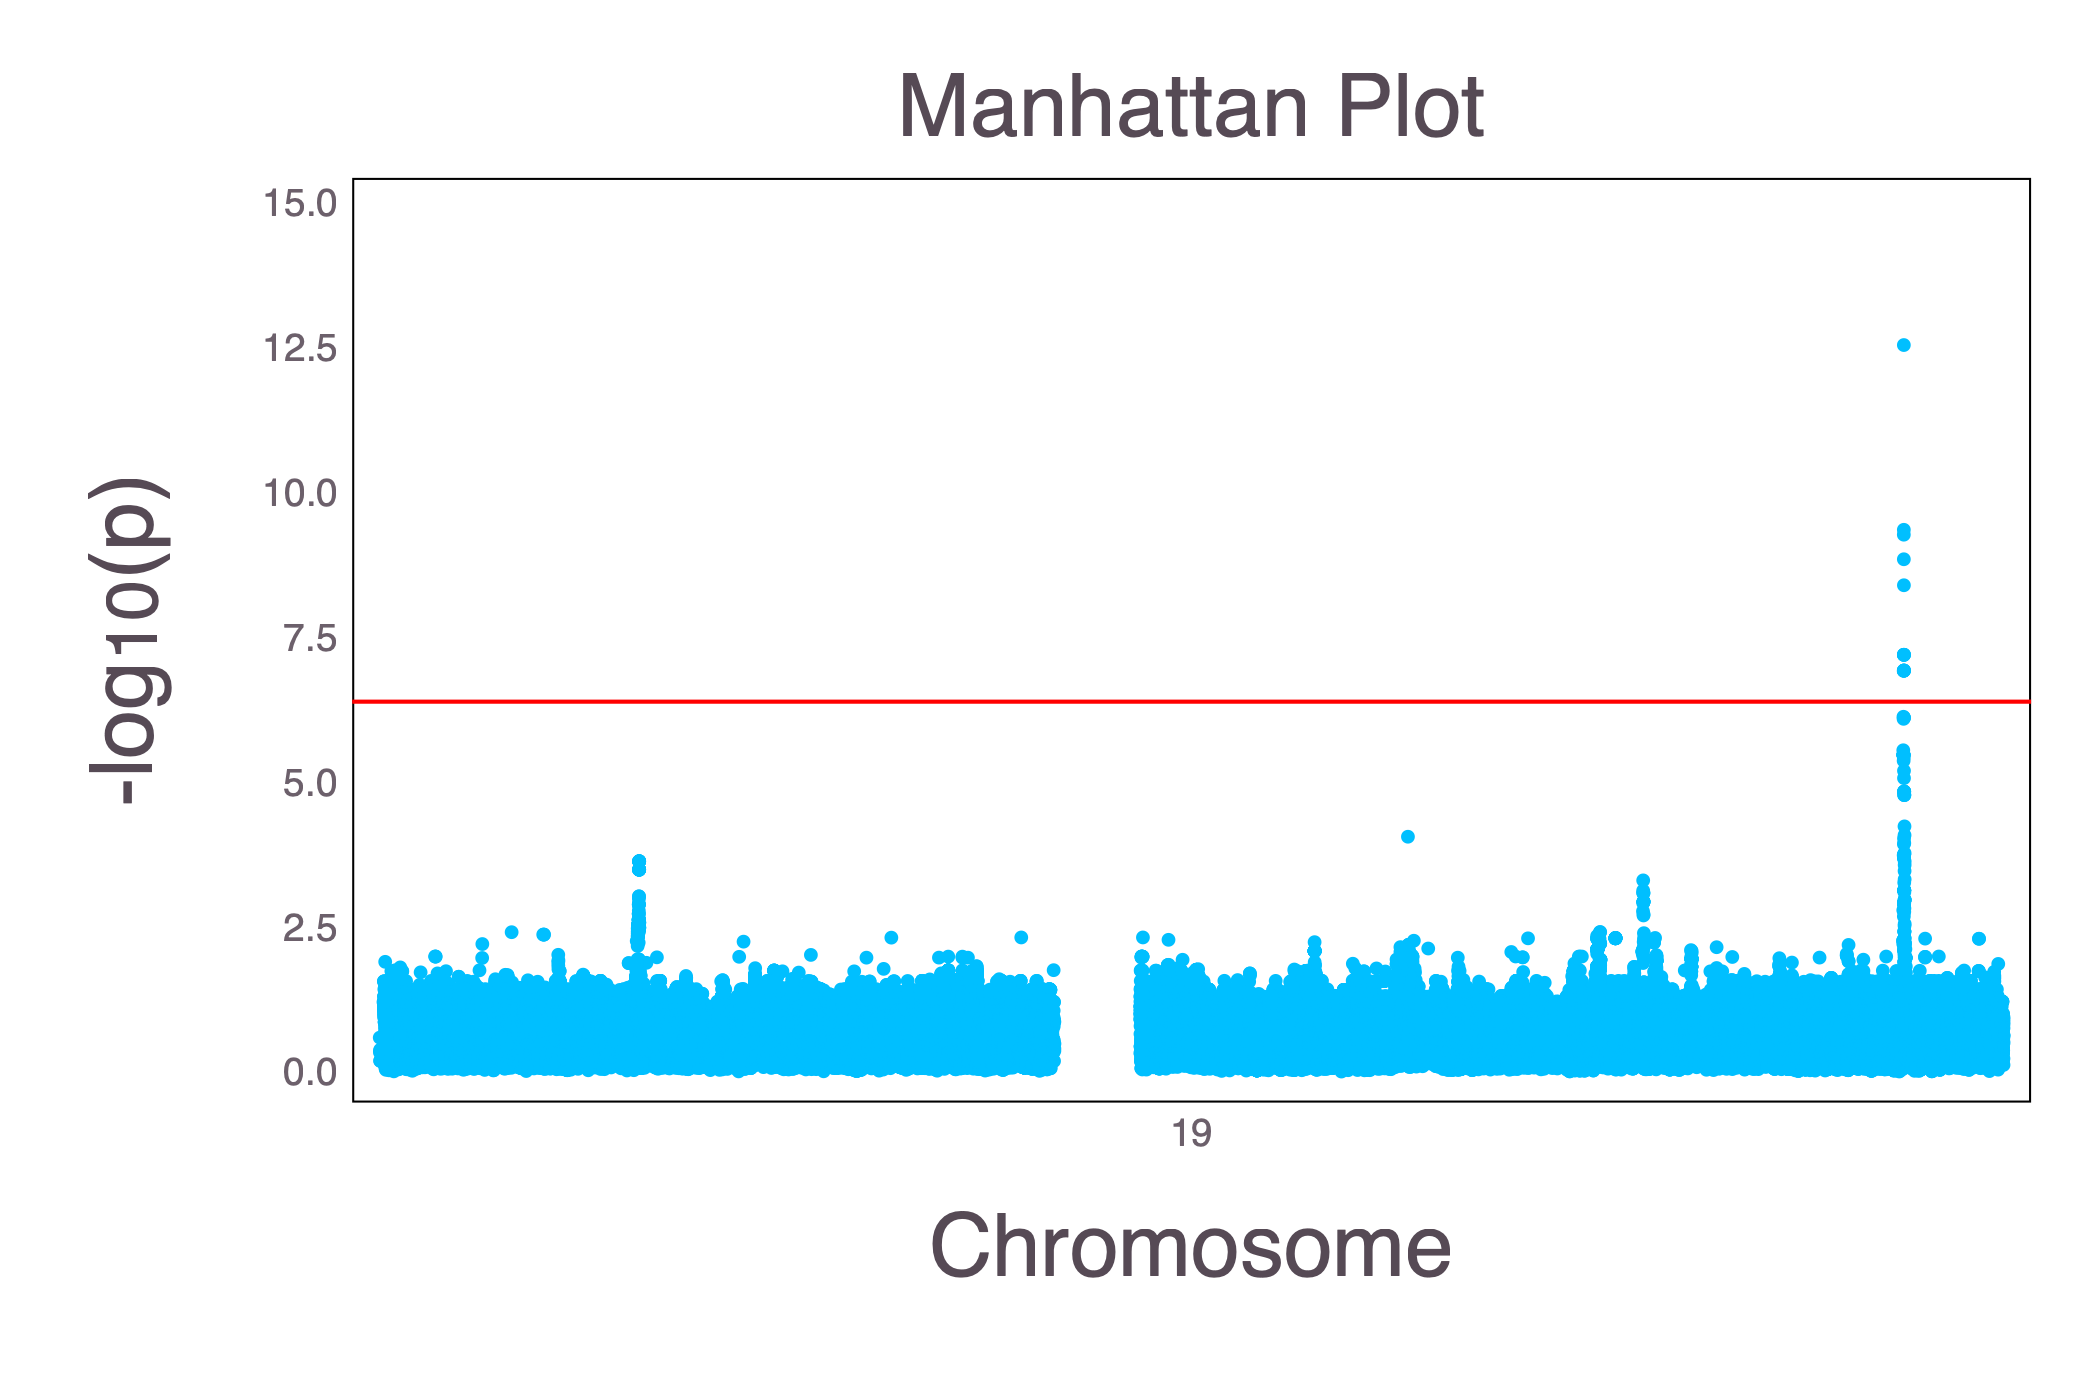

In [33]:
display("image/png", read("lmmGWAS_manhattan.png")) 

In [14]:
df=filter(row -> row[:5] < 0.000005, plot_frame)

,snpid,AdjBasepairs,Chromosome,MAF,Pvalue
,String,Int64,Int64,Float64,Float64
1,rs55474228,55474228,19,0.25,2.49982e-6
2,rs55475396,55475396,19,0.233491,2.99648e-6
3,rs55479392,55479392,19,0.233491,2.99648e-6
4,rs55479469,55479469,19,0.233491,2.99648e-6
5,rs55480444,55480444,19,0.233491,2.99648e-6
6,rs55480476,55480476,19,0.233491,2.99648e-6
7,rs55480864,55480864,19,0.231132,6.60762e-7
8,rs55481398,55481398,19,0.233491,2.99648e-6
9,rs55483587,55483587,19,0.233491,2.99648e-6


In [15]:
sort(df, :5)

,snpid,AdjBasepairs,Chromosome,MAF,Pvalue
,String,Int64,Int64,Float64,Float64
1,rs55494740,55494740,19,0.292453,2.55845e-13
2,rs55494188,55494188,19,0.268868,3.93445e-10
3,rs55493441,55493441,19,0.285377,4.77855e-10
4,rs55494651,55494651,19,0.283019,1.26768e-9
5,rs55496995,55496995,19,0.351415,3.55981e-9
6,rs55495215,55495215,19,0.275943,5.63669e-8
7,rs55498129,55498129,19,0.275943,5.63669e-8
8,rs55497826,55497826,19,0.275943,5.63669e-8
9,rs55498744,55498744,19,0.275943,5.63669e-8


In [16]:
ind_rs55494740 = findall(x -> x == "rs55494740", snpid)[1]
ind_rs55494188= findall(x -> x == "rs55494188", snpid)[1]
ind_rs55493441 = findall(x -> x == "rs55493441", snpid)[1]
ind_rs55494651 = findall(x -> x == "rs55494651", snpid)[1]
ind_rs55496995= findall(x -> x == "rs55496995", snpid)[1]


ind_rs55495215 = findall(x -> x == "rs55495215", snpid)[1]
ind_rs55498129 = findall(x -> x == "rs55498129", snpid)[1]
ind_rs55497826 = findall(x -> x == "rs55497826", snpid)[1]
ind_rs55498744 = findall(x -> x == "rs55498744", snpid)[1]
ind_rs55497039 = findall(x -> x == "rs55497039", snpid)[1]

ind_rs55497506 = findall(x -> x == "rs55497506", snpid)[1]
ind_rs55497943 = findall(x -> x == "rs55497943", snpid)[1]
ind_rs55497843 = findall(x -> x == "rs55497843", snpid)[1]
ind_rs55488728 = findall(x -> x == "rs55488728", snpid)[1]
ind_rs55480864 = findall(x -> x == "rs55480864", snpid)[1]

ind_rs55495293 = findall(x -> x == "rs55495293", snpid)[1]
ind_rs55495380 = findall(x -> x == "rs55495380", snpid)[1]
ind_rs55495593 = findall(x -> x == "rs55495593", snpid)[1]
ind_rs55484559 = findall(x -> x == "rs55484559", snpid)[1]
ind_rs55474228 = findall(x -> x == "rs55474228", snpid)[1]




snp_20_ind=["rs55494740","rs55494188","rs55493441","rs55494651",
              "rs55496995", "rs55495215", "rs55498129","rs55497826",
             "rs55498744",  "rs55497039", "rs55497506","rs55497943",
                "rs55497843","rs55488728" ,"rs55480864","rs55495293",
                "rs55495380" ,"rs55495593" , "rs55484559","rs55474228" ]




snp_20_index=[ind_rs55494740,ind_rs55494188,ind_rs55493441,ind_rs55494651,
              ind_rs55496995, ind_rs55495215, ind_rs55498129,ind_rs55497826,
             ind_rs55498744,  ind_rs55497039, ind_rs55497506,ind_rs55497943,
                ind_rs55497843,ind_rs55488728 ,ind_rs55480864,ind_rs55495293,
                ind_rs55495380 ,ind_rs55495593 , ind_rs55484559,ind_rs55474228 ]



snp_20_index[1]

128049

In [40]:
function new_info_matrix_new(v1,v3,Sigma_inv)
    info_1=hcat(1/2/212*tr(v1*Sigma_inv*v1*Sigma_inv),1/2/212*tr(v1*Sigma_inv*V_2*Sigma_inv),
    1/2/212*tr(v1*Sigma_inv*v3*Sigma_inv))

    info_2=hcat(1/2/212*tr(V_2*Sigma_inv*v1*Sigma_inv),1/2/212*tr(V_2*Sigma_inv*V_2*Sigma_inv),
    1/2/212*tr(V_2*Sigma_inv*v3*Sigma_inv))

    info_3=hcat(1/2/212*tr(v3*Sigma_inv*v1*Sigma_inv),1/2/212*tr(v3*Sigma_inv*V_2*Sigma_inv),
    1/2/212*tr(v3*Sigma_inv*v3*Sigma_inv))
    
    info_matrix_part=vcat(info_1,info_2,info_3)
    info_contained=vcat(hcat(1/212*transpose(X)*Sigma_inv*X,zeros(2,3)),hcat(zeros(3,2),info_matrix_part))
    return info_contained
end

new_info_matrix_new (generic function with 1 method)

In [78]:
function new_j_matrix_function_new(v1,v3,Sigma,epsilon)
    L_matrix=cholesky(Sigma) ##use L_matrix.L
    
    mu_3=sum(cubic,inv(L_matrix.L)*epsilon)
    mu_4=sum(quartic,inv(L_matrix.L)*epsilon)
    
    sub_matrix_1=L_matrix.U*Sigma_inv*X
    sub_matrix_2=L_matrix.U*Sigma_inv*v1*Sigma_inv*L_matrix.L## need to change
    sub_matrix_3=L_matrix.U*Sigma_inv*V_2*Sigma_inv*L_matrix.L
    sub_matrix_4=L_matrix.U*Sigma_inv*v3*Sigma_inv*L_matrix.L ## need to change
    
    J_trace_l=zeros(2,3)
    for l in 1:2
        trace_initial_1=trace_initial_2=trace_initial_3=0
        for k in 1:212
            trace_initial_1+=sub_matrix_1[k,l]*sub_matrix_2[k,k]  ##11   
            trace_initial_2+=sub_matrix_1[k,l]*sub_matrix_3[k,k]  ##12
            trace_initial_3+=sub_matrix_1[k,l]*sub_matrix_4[k,k]  ##13
        
        end
        J_trace_l[l,1]=trace_initial_1
        J_trace_l[l,2]=trace_initial_2
        J_trace_l[l,3]=trace_initial_3
    end
    
    J_trace_2=zeros(3,3)

    trace_initial_1=trace_initial_2=trace_initial_3=0
    for k in 1:212
        trace_initial_1+=sub_matrix_2[k,k]*sub_matrix_2[k,k]  ##11   
        trace_initial_2+=sub_matrix_2[k,k]*sub_matrix_3[k,k]  ##12
        trace_initial_3+=sub_matrix_2[k,k]*sub_matrix_4[k,k]  ##13        
    end
    J_trace_2[1,1]=trace_initial_1
    J_trace_2[1,2]=trace_initial_2
    J_trace_2[1,3]=trace_initial_3  ##may change

    trace_initial_1=trace_initial_2=trace_initial_3=0
    for k in 1:212
        trace_initial_1+=sub_matrix_3[k,k]*sub_matrix_2[k,k]  ##21   
        trace_initial_2+=sub_matrix_3[k,k]*sub_matrix_3[k,k]  ##22
        trace_initial_3+=sub_matrix_3[k,k]*sub_matrix_4[k,k]  ##23        
    end
    J_trace_2[2,1]=trace_initial_1
    J_trace_2[2,2]=trace_initial_2
    J_trace_2[2,3]=trace_initial_3 ##may change

    trace_initial_1=trace_initial_2=trace_initial_3=0
    for k in 1:212
        trace_initial_1+=sub_matrix_4[k,k]*sub_matrix_2[k,k]  ##11   
        trace_initial_2+=sub_matrix_4[k,k]*sub_matrix_3[k,k]  ##12
        trace_initial_3+=sub_matrix_4[k,k]*sub_matrix_4[k,k]  ##13        
    end
    J_trace_2[3,1]=trace_initial_1 ##may change
    J_trace_2[3,2]=trace_initial_2 ##may change
    J_trace_2[3,3]=trace_initial_3 ##may change


    
    J_matrix=zeros(5,5)
    J_matrix[1:2,3:5]=1/2/212*mu_3*J_trace_l
    J_matrix[3:5,1:2]=transpose(1/2/212*mu_3*J_trace_l)
    J_matrix[3:5,3:5]=1/4/n*(mu_4-3)*J_trace_2
    return J_matrix
      
    
end

new_j_matrix_function_new (generic function with 1 method)

In [17]:
num_gamma=3
V_list=[V_1,I(n),V_3]

3-element Array{AbstractArray{T,2} where T,1}:
 [1.402833844205457 0.0005569195701568374 … 0.0297985872125697 -0.0047093040256291135; 0.0005569195701568374 1.2361753116803273 … -0.035068235690409934 -0.018179291990383296; … ; 0.0297985872125697 -0.035068235690409934 … 1.5596329535283193 0.07593617552832234; -0.0047093040256291135 -0.018179291990383296 … 0.07593617552832234 1.225718803222995]
 Bool[1 0 … 0 0; 0 1 … 0 0; … ; 0 0 … 1 0; 0 0 … 0 1]
 [0.1799485861182518 0.1799485861182518 … 0.1799485861182518 0.1799485861182518; 0.1799485861182518 0.1799485861182518 … 0.1799485861182518 0.1799485861182518; … ; 0.1799485861182518 0.1799485861182518 … 0.1799485861182518 0.1799485861182518; 0.1799485861182518 0.1799485861182518 … 0.1799485861182518 0.1799485861182518]

In [46]:
col_index=findall(x->x==snpid[1], snpLMM_alt)
    
    

1-element Array{CartesianIndex{2},1}:
 CartesianIndex(2, 2)

In [73]:
V_3=grm(snpbinLMM; method = :GRM, minmaf=0.05,cinds=col_index[1][1]:col_index[1][1])



212×212 Array{Float64,2}:
  0.367742  -1.0        0.367742  …  -0.316129   0.367742  -0.316129
 -1.0        2.7193    -1.0           0.859649  -1.0        0.859649
  0.367742  -1.0        0.367742     -0.316129   0.367742  -0.316129
  0.367742  -1.0        0.367742     -0.316129   0.367742  -0.316129
 -0.316129   0.859649  -0.316129      0.27176   -0.316129   0.27176
 -0.316129   0.859649  -0.316129  …   0.27176   -0.316129   0.27176
  0.367742  -1.0        0.367742     -0.316129   0.367742  -0.316129
  0.367742  -1.0        0.367742     -0.316129   0.367742  -0.316129
 -0.316129   0.859649  -0.316129      0.27176   -0.316129   0.27176
 -0.316129   0.859649  -0.316129      0.27176   -0.316129   0.27176
 -0.316129   0.859649  -0.316129  …   0.27176   -0.316129   0.27176
 -0.316129   0.859649  -0.316129      0.27176   -0.316129   0.27176
 -0.316129   0.859649  -0.316129      0.27176   -0.316129   0.27176
  ⋮                               ⋱              ⋮         
  0.367742  -1.0        

In [49]:
snpbinLMM

212×253141 SnpArray:
 0x03  0x03  0x00  0x03  0x03  0x03  …  0x02  0x02  0x00  0x00  0x03  0x00
 0x03  0x03  0x00  0x02  0x02  0x03     0x00  0x03  0x00  0x00  0x03  0x00
 0x03  0x03  0x00  0x03  0x03  0x03     0x03  0x02  0x00  0x00  0x03  0x00
 0x03  0x03  0x00  0x03  0x03  0x03     0x02  0x03  0x00  0x00  0x03  0x00
 0x03  0x03  0x00  0x03  0x03  0x03     0x00  0x03  0x00  0x00  0x03  0x00
 0x03  0x03  0x00  0x03  0x03  0x03  …  0x00  0x00  0x00  0x00  0x00  0x03
 0x03  0x02  0x00  0x03  0x03  0x03     0x02  0x03  0x00  0x03  0x00  0x03
 0x03  0x03  0x00  0x03  0x03  0x03     0x02  0x03  0x00  0x03  0x00  0x03
 0x03  0x02  0x00  0x03  0x03  0x03     0x02  0x02  0x00  0x02  0x00  0x03
 0x03  0x02  0x00  0x03  0x03  0x03     0x03  0x03  0x00  0x03  0x00  0x03
 0x03  0x02  0x00  0x03  0x03  0x03  …  0x00  0x02  0x00  0x02  0x00  0x03
 0x03  0x03  0x00  0x03  0x03  0x03     0x00  0x02  0x00  0x02  0x00  0x03
 0x03  0x02  0x00  0x03  0x03  0x03     0x02  0x02  0x00  0x02  0x00  0x03
    

In [53]:
@view(snpbinLMM[:, snp_20_index[1]])

212-element view(::SnpArray, :, 128049) with eltype UInt8:
 0x00
 0x00
 0x00
 0x00
 0x00
 0x03
 0x00
 0x00
 0x02
 0x02
 0x02
 0x02
 0x02
    ⋮
 0x00
 0x00
 0x02
 0x00
 0x00
 0x00
 0x00
 0x00
 0x00
 0x00
 0x00
 0x00

In [56]:
snpLMM_alt

253141×6 Array{Any,2}:
 19  "rs90974"     0     90974  1  2
 19  "rs91106"     0     91106  1  2
 19  "rs93542"     0     93542  1  2
 19  "rs95981"     0     95981  1  2
 19  "rs105021"    0    105021  1  2
 19  "rs107866"    0    107866  1  2
 19  "rs107894"    0    107894  1  2
 19  "rs107958"    0    107958  1  2
 19  "rs107962"    0    107962  1  2
 19  "rs107987"    0    107987  1  2
 19  "rs108003"    0    108003  1  2
 19  "rs108032"    0    108032  1  2
 19  "rs108090"    0    108090  1  2
  ⋮                                ⋮
 19  "rs59116080"  0  59116080  1  2
 19  "rs59117729"  0  59117729  1  2
 19  "rs59117949"  0  59117949  1  2
 19  "rs59117982"  0  59117982  1  2
 19  "rs59118028"  0  59118028  1  2
 19  "rs59118040"  0  59118040  1  2
 19  "rs59118044"  0  59118044  1  2
 19  "rs59118114"  0  59118114  1  2
 19  "rs59118148"  0  59118148  1  2
 19  "rs59118616"  0  59118616  1  2
 19  "rs59118779"  0  59118779  1  2
 19  "rs59118783"  0  59118783  1  2

In [66]:
col_index=findall(x->x==snp_20_ind[2], snpLMM_alt)

1-element Array{CartesianIndex{2},1}:
 CartesianIndex(236067, 2)

In [67]:
snpLMM_alt[236067,:]

6-element Array{Any,1}:
       19
         "rs55494188"
        0
 55494188
        1
        2

In [68]:
for i in 2:2
    T = eltype(sex)
    genovec  = zeros(T, n)
    Base.copyto!(genovec, @view(snpbinLMM[:, snp_20_index[i]]), 
        model=ADDITIVE_MODEL, center=true, scale=true, impute=true)

    V_3=genovec*transpose(genovec) 
    num_gamma=3
    
    col_index=findall(x->x=="rs55494188", snpLMM_alt)
    V_1=grm(snpbinLMM; method = :GRM, minmaf=0.05,cinds=1:size(snpbinLMM, 2) .!= col_index[1][1])
    
    V_list=[2V_1,I(n),V_3]
    gamma_t=zeros(num_gamma,1)
    beta_estimate, gamma_estimate=mm_vcm(Trait1,X,1000,1e-60,gamma_t,V_list)
    
    
    
    println(gamma_estimate)

    
end

[4.8199632037263465; 1.8615198813034324; 0.07134151696761348]


In [71]:
1:size(snpbinLMM, 2).!= col_index[1][1]

253141-element BitArray{1}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [24]:
i=1
col_index=findall(x->x==snp_20_ind[i], snpLMM_alt)
    
V_3_old=grm(snpbinLMM; method = :GRM, minmaf=0.05,cinds=col_index[1][1]:col_index[1][1])
    
V_3=2V_3_old
    
V_1_old=grm(snpbinLMM; method = :GRM, minmaf=0.05,cinds=1:size(snpbinLMM, 2) .!= col_index[1][1])
                ###V_1 need to change
V_1=2V_1_old

V_2=I(n)
    
num_gamma=3
V_list=[V_1,I(n),V_3]
gamma_t=zeros(num_gamma,1)
beta_estimate, gamma_estimate=mm_vcm(Trait1,X,1000,1e-60,gamma_t,V_list)
epsilon=Trait1-X*beta_estimate
Sigma=zeros(212,212)
for j in 1:num_gamma
    Sigma=Sigma+gamma_estimate[j]*V_list[j]
end  
Sigma_inv=inv(Sigma)

212×212 Array{Float64,2}:
  0.163095      0.0064268     0.0208426   …  -0.000541032   0.00256558
  0.0064268     0.183047      0.00999362      0.00532349   -0.000631989
  0.0208426     0.00999362    0.18547         0.00307205    0.00309284
 -0.0572072     0.0242172    -0.064719        0.00166276    0.00303986
 -0.00862549   -0.0773738    -0.0100119       0.00344538    0.00175099
  0.0017768     0.00443356    0.0011801   …   0.000435095   0.00245076
  0.00170063    0.00362733    0.00227426      0.00104457    0.00486197
  0.00256855    0.00480719    0.00271378      0.00244175    0.00308727
  0.00138501    0.00219737    0.00238416      0.00557777    0.00478551
  0.00261495    0.00124249    0.00285742      0.00186173    0.00249838
  0.0033427    -0.00316474    0.00126968  …   0.0033467    -0.00252611
  0.00339612   -0.00313931    0.00265688      0.00489934   -0.00262055
  0.00597488   -0.00149299    0.00490097      0.00305013   -0.0037166
  ⋮                                       ⋱   ⋮    

In [33]:
for i in 1:20
    ##T = eltype(sex)
    ##genovec  = zeros(T, n)
    ##Base.copyto!(genovec, @view(snpbinLMM[:, snp_20_index[i]]), 
        ##model=ADDITIVE_MODEL, center=true, scale=true, impute=true)

    ##V_3=genovec*transpose(genovec) 
    
    col_index=findall(x->x==snp_20_ind[i], snpLMM_alt)
    
    V_3_old=grm(snpbinLMM; method = :GRM, minmaf=0.05,cinds=col_index[1][1]:col_index[1][1])
    
    V_3=2V_3_old
    
    V_1_old=grm(snpbinLMM; method = :GRM, minmaf=0.05,cinds=1:size(snpbinLMM, 2) .!= col_index[1][1])
                ###V_1 need to change
    V_1=2V_1_old
    
    
    num_gamma=3
    V_list=[V_1,I(n),V_3]
    gamma_t=zeros(num_gamma,1)
    beta_estimate, gamma_estimate=mm_vcm(Trait1,X,1000,1e-60,gamma_t,V_list)
    
    
    println(snp_20_ind[i])
    println("&",round(gamma_estimate[3],digits=4),"&",round(gamma_estimate[1],digits=4),"&",
                            round(gamma_estimate[2],digits=4),"&")
    
    epsilon=Trait1-X*beta_estimate
    Sigma=zeros(212,212)
    for j in 1:num_gamma
        Sigma=Sigma+gamma_estimate[j]*V_list[j]
    end
    Sigma_inv=inv(Sigma)
    
    L_matrix=cholesky(Sigma) ##use L_matrix.L
    
    mu_3=sum(cubic,inv(L_matrix.L)*epsilon)
    mu_4=sum(quartic,inv(L_matrix.L)*epsilon)
    I_matrix=1e10*new_info_matrix(V_1,V_3)
    I_matrix_inv=inv(I_matrix)
    J_matrix=new_j_matrix_function(V_1,V_3)
    variance_matrix=I_matrix_inv+I_matrix_inv*J_matrix*I_matrix_inv
    
    sd=zeros(3,1)
    sd[1]=sqrt(variance_matrix[3,3])
    sd[2]=sqrt(variance_matrix[4,4])
    sd[3]=sqrt(variance_matrix[5,5])
    
    hratio=(gamma_estimate[1]+gamma_estimate[3])/sum(gamma_estimate)
    
    
    println(round(sd[3],digits=4),"&",round(sd[1],digits=4),"&",round(sd[2],digits=4),"&")
    println(hratio)
    
end

rs55494740
&1.4905&3.8015&1.7205&
0.0003&0.0001&0.0001&
0.7546491741482896
rs55494188
&1.2729&4.1071&1.6624&
0.0003&0.0001&0.0001&
0.7639444340013961
rs55493441
&1.2701&4.0183&1.6891&
0.0003&0.0001&0.0001&
0.7579199139182217
rs55494651
&1.2331&4.0308&1.6991&
0.0003&0.0001&0.0001&
0.7559787231055837
rs55496995
&0.9677&4.3886&1.6289&
0.0002&0.0001&0.0001&
0.766804576268942
rs55495215
&1.0262&4.256&1.6959&
0.0002&0.0001&0.0001&
0.7569665811401826
rs55498129
&1.0262&4.256&1.6959&
0.0002&0.0001&0.0001&
0.7569665913241862
rs55497826
&1.0262&4.256&1.6959&
0.0002&0.0001&0.0001&
0.7569665913241829
rs55498744
&1.0262&4.256&1.6959&
0.0002&0.0001&0.0001&
0.7569665811401829
rs55497039
&1.0149&4.1762&1.7279&
0.0002&0.0001&0.0001&
0.7502658757115656
rs55497506
&1.0149&4.1762&1.7279&
0.0002&0.0001&0.0001&
0.7502658524744237
rs55497943
&1.0149&4.1762&1.7279&
0.0002&0.0001&0.0001&
0.7502658524744237
rs55497843
&1.0149&4.1762&1.7279&
0.0002&0.0001&0.0001&
0.7502658757115656
rs55488728
&1.1119&4.2176&1.65

In [84]:
round(gamma_estimate[3],digits=4)

1.4905

In [212]:
pvalue
findall(x->x==1, pvalue)

136537-element Array{Int64,1}:
   1205
   1206
   1207
   1208
   1209
   1210
   1211
   1212
   1213
   1214
   1215
   1216
   1217
      ⋮
 137730
 137731
 137732
 137733
 137734
 137735
 137736
 137737
 137738
 137739
 137740
 137741

In [220]:
i=1205
col_index=findall(x->x=="549777", snpLMM_alt)


CartesianIndex{2}[]

In [217]:
snpid[1206]

"rs111763479"

LoadError: UndefVarError: $ not defined

### Heritablity of `Trait1`

We now calculate the narrow sense heritability and its standard error.   The equation for heritability(h) is h = $\sigma^2_a / (\sigma^2_a + \sigma^2_e)$. 

In [11]:
h, hse = heritability(nullmodel.Σ, Σcov)

([0.7170259392363172], [0.06225369511578639])

The heritability of this simulated trait is rather on the high side ($72\%$) for a human trait, which explains why we can get away with only 212 individuals in this GWAS. 

## GWAS of Trait1

We now prepare our alternative models in order to conduct our GWAS of Trait1:

In [21]:
## fit alternative model with SNPs, push null model info to alternative model 
T = eltype(sex)
altdatarot = TwoVarCompVariateRotate(nulldatarot.Yrot,
    zeros(T, n, size(X, 1) + 1), nulldatarot.eigval, nulldatarot.eigvec,
    nulldatarot.logdetV2)
copyto!(altdatarot.Xrot, nulldatarot.Xrot) # last column ramains zero
altmodel = VarianceComponentModel(altdatarot)

VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}([0.0; 0.0; … ; 0.0; 0.0], ([1.0], [1.0]), Array{Float64}(undef,0,213), Char[], Float64[], -Inf, Inf)

In [21]:
##rotated responses
nulldatarot.Yrot

212-element Array{Float64,1}:
 -543.2644204757835
   -1.6753153305801352
   -1.1358273212690193
    2.566828330322789
    2.16235910877724
   -1.7883255473927235
    1.3533606729878969
    0.7707001767841142
   -0.0701041357835055
    3.745704176860148
   -2.507414654226068
    1.2339335312321813
   -1.4852342161230858
    ⋮
    3.7185333332483257
    8.877380000926326
   -0.8782816407197691
   -0.5721637118793819
    1.4058320210281998
   -7.879772280571253
   -1.2459408722686707
   -2.1732246662369414
    8.4708452085469
    8.629244838987088
   -1.517910604593471
    2.783740665968198

In [36]:
pedLMM = readdlm("SNP_29a.fam", ','; header = false)
Trait1 = convert(Vector{Float64}, pedLMM[:, 7])
# Trait2 = convert(Vector{Float64}, pedLMM[:, 8])
# Y = [Trait1 Trait2]
sex = map(x -> strip(x) == "F" ? 1.0 : 0.0,  pedLMM[:, 5])

snpbinLMM = SnpArray("SNP_29a.bed")

snpLMM_alt = readdlm("SNP_29a.bim"; header = false) ##no maf
snpLMM_alt[:,2]= map(x -> string("rs",strip(string(x))), snpLMM_alt[:, 4])

snpLMM = readdlm("SNP_29a.bim"; header = false)
snpLMM[:,2]= map(x -> string("rs",strip(string(x))), snpLMM[:, 4])


snpLMM = snpLMM[maf(snpbinLMM) .> 0.05,:]
snpid = map(x -> strip(string(x)), snpLMM[:, 2])


row_index=Array((1:253141))
col_index_save=row_index[maf(snpbinLMM) .> 0.05]

n, snps = size(snpbinLMM[:,maf(snpbinLMM) .> 0.05])
X = [ones(n) sex]
p = size(X,2)  # no. covariates
n, snps, p


(212, 137741, 2)

In [53]:
grm_save= Matrix{Float64}[]

Array{Float64,2}[]

In [60]:

grm_save= Matrix{Float64}[]
@time for i in 1:snps
    grm_ini=grm(snpbinLMM; method = :GRM, minmaf=0.05,cinds=col_index_save[i]:col_index_save[i])
    push!(grm_save, grm_ini)
    if mod(i, 1000) == 1
            println(i)
    end 
    
end

1
1001
2001
3001
4001
5001
6001
7001
8001
9001
10001
11001
12001
13001
14001
15001
16001
17001
18001
19001
20001
21001
22001
23001
24001
25001
26001
27001
28001
29001
30001
31001
32001
33001
34001
35001
36001
37001
38001
39001
40001
41001
42001
43001
44001
45001
46001
47001
48001
49001
50001
51001
52001
53001
54001
55001
56001
57001
58001
59001
60001
61001
62001
63001
64001
65001
66001
67001
68001
69001
70001
71001
72001
73001
74001
75001
76001
77001
78001
79001
80001
81001
82001
83001
84001
85001
86001
87001
88001
89001
90001
91001
92001
93001
94001
95001
96001
97001
98001
99001
100001
101001
102001
103001
104001
105001
106001
107001
108001
109001
110001
111001
112001
113001
114001
115001
116001
117001
118001
119001
120001
121001
122001
123001
124001
125001
126001
127001
128001
129001
130001
131001
132001
133001
134001
135001
136001
137001
408.663916 seconds (2.98 M allocations: 310.623 GiB, 51.35% gc time)


In [61]:
using JLD
save("grm_save.jld", "data", grm_save)

In [62]:
pvalue = ones(snps)
T = eltype(sex)
grm_total=grm(snpbinLMM; method = :GRM, minmaf=0.05)
@time for i in 1:100  ##snps
    
    V_1_old=(137741*grm_total-grm_save[i])/137740
                ###V_1 need to change
    V_1=2V_1_old

    
    snpsidx = vcat(1:size(snpbinLMM,2))[maf(snpbinLMM) .> 0.05]
    

    V_3=2grm_save[i]
    


    num_gamma=3
    V_list=[V_1,I(n),V_3]
    gamma_t=zeros(num_gamma,1)
    beta_estimate, gamma_estimate=mm_vcm(Trait1,X,1000,1e-60,gamma_t,V_list)
    
    
    epsilon=Trait1-X*beta_estimate
    Sigma=zeros(212,212)
    for j in 1:num_gamma
        Sigma=Sigma+gamma_estimate[j]*V_list[j]
    end
    Sigma_inv=inv(Sigma)
    
    L_matrix=cholesky(Sigma) ##use L_matrix.L
    
    mu_3=sum(cubic,inv(L_matrix.L)*epsilon)
    mu_4=sum(quartic,inv(L_matrix.L)*epsilon)
    I_matrix=new_info_matrix(V_1,V_3)
    I_matrix_inv=inv(I_matrix)
    J_matrix=new_j_matrix_function(V_1,V_3)
    variance_matrix=I_matrix_inv+I_matrix_inv*J_matrix*I_matrix_inv
    
    quasi_wald=212*gamma_estimate[3]^2/variance_matrix[5,5]
    
    
    
    pvalue[i] = ccdf(Chisq(1), quasi_wald)
    if mod(i, 1000) == 1
            println(i)
    end 
    

end

1
117.535597 seconds (3.52 M allocations: 87.535 GiB, 19.69% gc time)


In [46]:
pvalue = ones(snps)
T = eltype(sex)

i=4
    
    V_1_old=grm(snpbinLMM; method = :GRM, minmaf=0.05,cinds=1:size(snpbinLMM, 2) .!= col_index_save[i])
                ###V_1 need to change
    V_1=2V_1_old

    
    snpsidx = vcat(1:size(snpbinLMM,2))[maf(snpbinLMM) .> 0.05]
    
    V_3_old=grm(snpbinLMM; method = :GRM, minmaf=0.05,cinds=col_index_save[i]:col_index_save[i])
    
    V_3=2V_3_old
    


    num_gamma=3
    V_list=[V_1,I(n),V_3]
    gamma_t=zeros(num_gamma,1)
    beta_estimate, gamma_estimate=mm_vcm(Trait1,X,1000,1e-60,gamma_t,V_list)
    
    epsilon=Trait1-X*beta_estimate
    Sigma=zeros(212,212)
    for j in 1:num_gamma
        Sigma=Sigma+gamma_estimate[j]*V_list[j]
    end
    Sigma_inv=inv(Sigma)
    
    L_matrix=cholesky(Sigma) ##use L_matrix.L
    
    mu_3=sum(cubic,inv(L_matrix.L)*epsilon)
    mu_4=sum(quartic,inv(L_matrix.L)*epsilon)
    I_matrix=new_info_matrix(V_1,V_3)
    I_matrix_inv=inv(I_matrix)
    J_matrix=new_j_matrix_function(V_1,V_3)
    variance_matrix=I_matrix_inv+I_matrix_inv*J_matrix*I_matrix_inv
    
    quasi_wald=212*gamma_estimate[3]^2/variance_matrix[5,5]
    
    
    pvalue[i] = ccdf(Chisq(1), quasi_wald)
    

1.0

### Loop over all SNPs to calculate LRT pvalues for LmmGWAS

The following routine shows you how you can write some simple julia code to execute a GWAS. This tutorial is set up to run all the snps. Note that if you are running this tutorial on your old laptop, then be prepared to wait a while for this step to finish. If you see the counter (for every 1000 snps processed) progressing, then the program is working so just be patient.  Alternatively you might wish to try out the tutorial for a much smaller example.  Then loop through only the first few snps, for example the first 100. If so, comment out with a # "@time for snp in 1:snps" and remove the # on "@time for snp in 1:testrun"

In [24]:
@view(snpbinLMM[:,snpsidx[1]]

212-element view(::SnpArray, :, 2) with eltype UInt8:
 0x03
 0x03
 0x03
 0x03
 0x03
 0x03
 0x02
 0x03
 0x02
 0x02
 0x02
 0x03
 0x02
    ⋮
 0x03
 0x03
 0x03
 0x02
 0x03
 0x03
 0x03
 0x03
 0x02
 0x03
 0x03
 0x03

In [32]:
convert(UInt8, 3)

0x03

In [34]:
convert(Int64, 0x01)

1

In [29]:
minimum(snpbinLMM[:,snpsidx[1]])

0x02

In [25]:
genovec  = zeros(T, n)

212-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [26]:
Base.copyto!(genovec,@view(snpbinLMM[:,snpsidx[1]]))

212-element Array{Float64,1}:
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 1.0
 2.0
 1.0
 1.0
 1.0
 2.0
 1.0
 ⋮
 2.0
 2.0
 2.0
 1.0
 2.0
 2.0
 2.0
 2.0
 1.0
 2.0
 2.0
 2.0

In [28]:
minimum(genovec)

1.0

In [29]:
ind_rs10412915 = findall(x -> x == "rs10412915", snpid)[1]
ind_rs1036231 = findall(x -> x == "rs1036231", snpid)[1]

128067

In [30]:
snp=4
Base.copyto!(genovec, @view(snpbinLMM[:, ind_rs10412915]), model=ADDITIVE_MODEL, center=true, scale=true, impute=true)

212-element Array{Float64,1}:
 -0.4812265031857878
 -0.4812265031857878
 -0.4812265031857878
 -0.4812265031857878
 -0.4812265031857878
  4.1560470729681676
 -0.4812265031857878
 -0.4812265031857878
  1.8374102848911897
  1.8374102848911897
  1.8374102848911897
  1.8374102848911897
  1.8374102848911897
  ⋮
 -0.4812265031857878
 -0.4812265031857878
  1.8374102848911897
 -0.4812265031857878
 -0.4812265031857878
 -0.4812265031857878
 -0.4812265031857878
 -0.4812265031857878
 -0.4812265031857878
 -0.4812265031857878
 -0.4812265031857878
 -0.4812265031857878

similar function: Create an uninitialized mutable array with the given element type and size, based upon the given source array.
LinearAlgebra.mul!(Y, A, B): store AB into Y

In [33]:
tmp_mat = similar(genovec)
LinearAlgebra.mul!(tmp_mat, transpose(altdatarot.eigvec), genovec)
##rotated snp value

212-element Array{Float64,1}:
 -1.6653345369377348e-15
 -0.13637351481558974
 -0.3174730085397143
  0.2975855160077273
 -0.23121389719316565
  0.43274844171290605
  0.9590520176472265
 -0.12789095282896878
  0.010942748862549385
 -0.26900953374157455
 -0.08554693137997729
 -0.34921250358110467
 -0.4103103763393423
  ⋮
 -0.20442259360468518
 -2.217613727946902
  2.193833691430658
 -0.5830778449688624
  2.320666188001627
 -4.753854585767877
  1.819294192042747
 -1.3683130969829451
  1.0644669093808925
 -1.128660614379387
 -2.0860910946537574
 -1.14512594488512

In [35]:
altdatarot.Xrot

212×213 Array{Float64,2}:
 -14.5602       -6.66199    0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
   3.7274e-14   -0.197432   0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  -1.16014e-14   0.269224   0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
   7.38298e-15  -0.0919425  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
   2.2175e-14    0.0692106  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
   9.70578e-15   0.182905   0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  -5.2857e-15   -0.322398   0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
   5.4956e-15   -0.202952   0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
   1.9363e-14   -0.0864911  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  -2.86162e-14  -0.424078   0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
   4.66641e-16   0.369513   0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
   9.71434e-15  -0.349695   0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  -1.64148e-16  -0.116523   0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [37]:
altdatarot.Xrot[:, end] = tmp_mat
altdatarot.Xrot

212×213 Array{Float64,2}:
 -14.5602       -6.66199    0.0  0.0  …  0.0  0.0  0.0  0.0  -1.66533e-15
   3.7274e-14   -0.197432   0.0  0.0     0.0  0.0  0.0  0.0  -0.136374
  -1.16014e-14   0.269224   0.0  0.0     0.0  0.0  0.0  0.0  -0.317473
   7.38298e-15  -0.0919425  0.0  0.0     0.0  0.0  0.0  0.0   0.297586
   2.2175e-14    0.0692106  0.0  0.0     0.0  0.0  0.0  0.0  -0.231214
   9.70578e-15   0.182905   0.0  0.0  …  0.0  0.0  0.0  0.0   0.432748
  -5.2857e-15   -0.322398   0.0  0.0     0.0  0.0  0.0  0.0   0.959052
   5.4956e-15   -0.202952   0.0  0.0     0.0  0.0  0.0  0.0  -0.127891
   1.9363e-14   -0.0864911  0.0  0.0     0.0  0.0  0.0  0.0   0.0109427
  -2.86162e-14  -0.424078   0.0  0.0     0.0  0.0  0.0  0.0  -0.26901
   4.66641e-16   0.369513   0.0  0.0  …  0.0  0.0  0.0  0.0  -0.0855469
   9.71434e-15  -0.349695   0.0  0.0     0.0  0.0  0.0  0.0  -0.349213
  -1.64148e-16  -0.116523   0.0  0.0     0.0  0.0  0.0  0.0  -0.41031
   ⋮                                  ⋱         

In [38]:
# initialize mean effects to null model fit
fill!(altmodel.B, zero(T))
copyto!(altmodel.B, nullmodel.B)
copyto!(altmodel.Σ[1], nullmodel.Σ[1])
copyto!(altmodel.Σ[2], nullmodel.Σ[2])
logl_alt, vcmodel_mle, Σse, Σcov, Bse, Bcov = mle_mm!(altmodel, altdatarot; verbose = false)

(-478.29055513262074, VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}([40.213991068311955; -6.343471613225898; … ; 0.0; 0.40382494151787984], ([4.744864479066033], [1.8948692936148905]), Array{Float64}(undef,0,213), Char[], Float64[], -Inf, Inf), ([1.0293524345496368], [0.5475924469302693]), [1.059566434513264 -0.38987469444371925; -0.38987469444371936 0.2998574879350798], [0.17127363480212496; 0.31213535689112776; … ; 0.0; 0.18197270479153835], [0.029334657978331673 -0.044578125750426904 … 0.0 0.0018268113251176373; -0.0445781257504269 0.09742848102155169 … 0.0 -0.003992618566236493; … ; 0.0 0.0 … 0.0 0.0; 0.0018268113251176377 -0.0039926185662364925 … 0.0 0.03311406528914836])

In [39]:
vcmodel_mle

VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}([40.213991068311955; -6.343471613225898; … ; 0.0; 0.40382494151787984], ([4.744864479066033], [1.8948692936148905]), Array{Float64}(undef,0,213), Char[], Float64[], -Inf, Inf)

In [13]:
pvalue   = ones(snps)
genovec  = zeros(T, n)
testrun  = 100

snpsidx = vcat(1:size(snpbinLMM,2))[maf(snpbinLMM) .> 0.05]
#@time for snp in 1:testrun
@time for snp in 1:snps 
    # append (rotated) genotype vector to covariate matrix
    Base.copyto!(genovec, @view(snpbinLMM[:,snpsidx[snp]]), model=ADDITIVE_MODEL, center=true, scale=true, impute=true)
    tmp_mat = similar(genovec)
    LinearAlgebra.mul!(tmp_mat, transpose(altdatarot.eigvec), genovec)
    altdatarot.Xrot[:, end] = tmp_mat
    # initialize mean effects to null model fit
    fill!(altmodel.B, zero(T))
    copyto!(altmodel.B, nullmodel.B)
    copyto!(altmodel.Σ[1], nullmodel.Σ[1])
    copyto!(altmodel.Σ[2], nullmodel.Σ[2])
    # fit alternative model
    if algorithm == :MM
        logl_alt, vcmodel_mle, Σse, Σcov, Bse, Bcov = mle_mm!(altmodel, altdatarot; verbose = false)
    elseif algorithm == :FS
        logl_alt, = mle_fs!(altmodel, altdatarot; verbose = false)
    end
    # LRT statistics and its pvalue
    lrt = - 2(logl_null - logl_alt)
    pvalue[snp] = ccdf(Chisq(1), lrt)
#    println(snp,": ", hapmap_snpdata.snpid[snp], 
    if mod(snp, 1000) == 1
            println(snp)
    end    
#        "\n\tMAF: ", @sprintf("%0.3f", maf[snp]), 
#        "\n\tLRT p: ", @sprintf("%0.3f", pvalue[snp]))
end


1
1001
2001
3001
4001
5001
6001
7001
8001
9001
10001
11001
12001
13001
14001
15001
16001
17001
18001
19001
20001
21001
22001
23001
24001
25001
26001
27001
28001
29001
30001
31001
32001
33001
34001
35001
36001
37001
38001
39001
40001
41001
42001
43001
44001
45001
46001
47001
48001
49001
50001
51001
52001
53001
54001
55001
56001
57001
58001
59001
60001
61001
62001
63001
64001
65001
66001
67001
68001
69001
70001
71001
72001
73001
74001
75001
76001
77001
78001
79001
80001
81001
82001
83001
84001
85001
86001
87001
88001
89001
90001
91001
92001
93001
94001
95001
96001
97001
98001
99001
100001
101001
102001
103001
104001
105001
106001
107001
108001
109001
110001
111001
112001
113001
114001
115001
116001
117001
118001
119001
120001
121001
122001
123001
124001
125001
126001
127001
128001
129001
130001
131001
132001
133001
134001
135001
136001
137001
12529.855222 seconds (692.42 M allocations: 1.376 TiB, 0.94% gc time)


### Output results to file
In some situations you may want to save GWAS results for future use, for example for use as part of a meta analysis. In the next set of commands, we show you how to make and save a comma delimited file with the snp id, the position of the snp, the chromosome location of the snp, the minor allele frequency, and the result provided as the negative log of the p-value. 

In [15]:
using DataFrames
using CSV

In [16]:
# maf, = summarize(snpbinLMM)
plot_frame = DataFrame(snpid = snpLMM[:,2],
   AdjBasepairs = snpLMM[:,4], 
   Chromosome = snpLMM[:,1], 
   MAF = maf(snpbinLMM)[maf(snpbinLMM).>0.05],
   Pvalue = pvalue)

CSV.write("lmmGWAS_output_pVal.txt", plot_frame)

"lmmGWAS_output_pVal.txt"

### Manhattan Plot

One of the most common ways to display the results of a GWAS is as a plot of negative log base 10 of the pvalues versus chromosomal position, a Manhattan plot.  For your convenience, we have developed a Julia plotting module as part of the Open Mendel project, MendelPlots.  We demonstrate its use below.  The Manhattan plot will look at little different than the typical one because this example only includes markers from chromosome 19. 

In [17]:
plot_frame = CSV.read("lmmGWAS_output_pVal.txt")

┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `DataFrame!(CSV.File(input; kw...))`
└ @ CSV /Users/jeffery/.julia/packages/CSV/UWuB2/src/CSV.jl:40


,snpid,AdjBasepairs,Chromosome,MAF,Pvalue
,String,Int64,Int64,Float64,Float64
1,rs56343121,91106,19,0.0825472,0.0897149
2,rs56182540,95981,19,0.0872642,0.582401
3,rs7260412,105021,19,0.0849057,0.524435
4,rs8106297,107958,19,0.0589623,0.977626
5,rs8106302,107962,19,0.0589623,0.670749
6,rs186451972,108003,19,0.0849057,0.784671
7,rs76534612,226776,19,0.490566,0.373017
8,rs1975526,240867,19,0.419811,0.749416
9,rs62103026,244421,19,0.436321,0.576142


In [19]:
using MendelPlots

manhattan(plot_frame; pvalvar = "Pvalue", chrvar = "Chromosome", 
    posvar = "AdjBasepairs", outfile = "lmmGWAS_manhattan.png", fontsize = 18pt, linecolor = "red")


┌ Info: Precompiling MendelPlots [7ab2ea78-72dd-4c03-85d8-fc2b0db252af]
└ @ Base loading.jl:1260


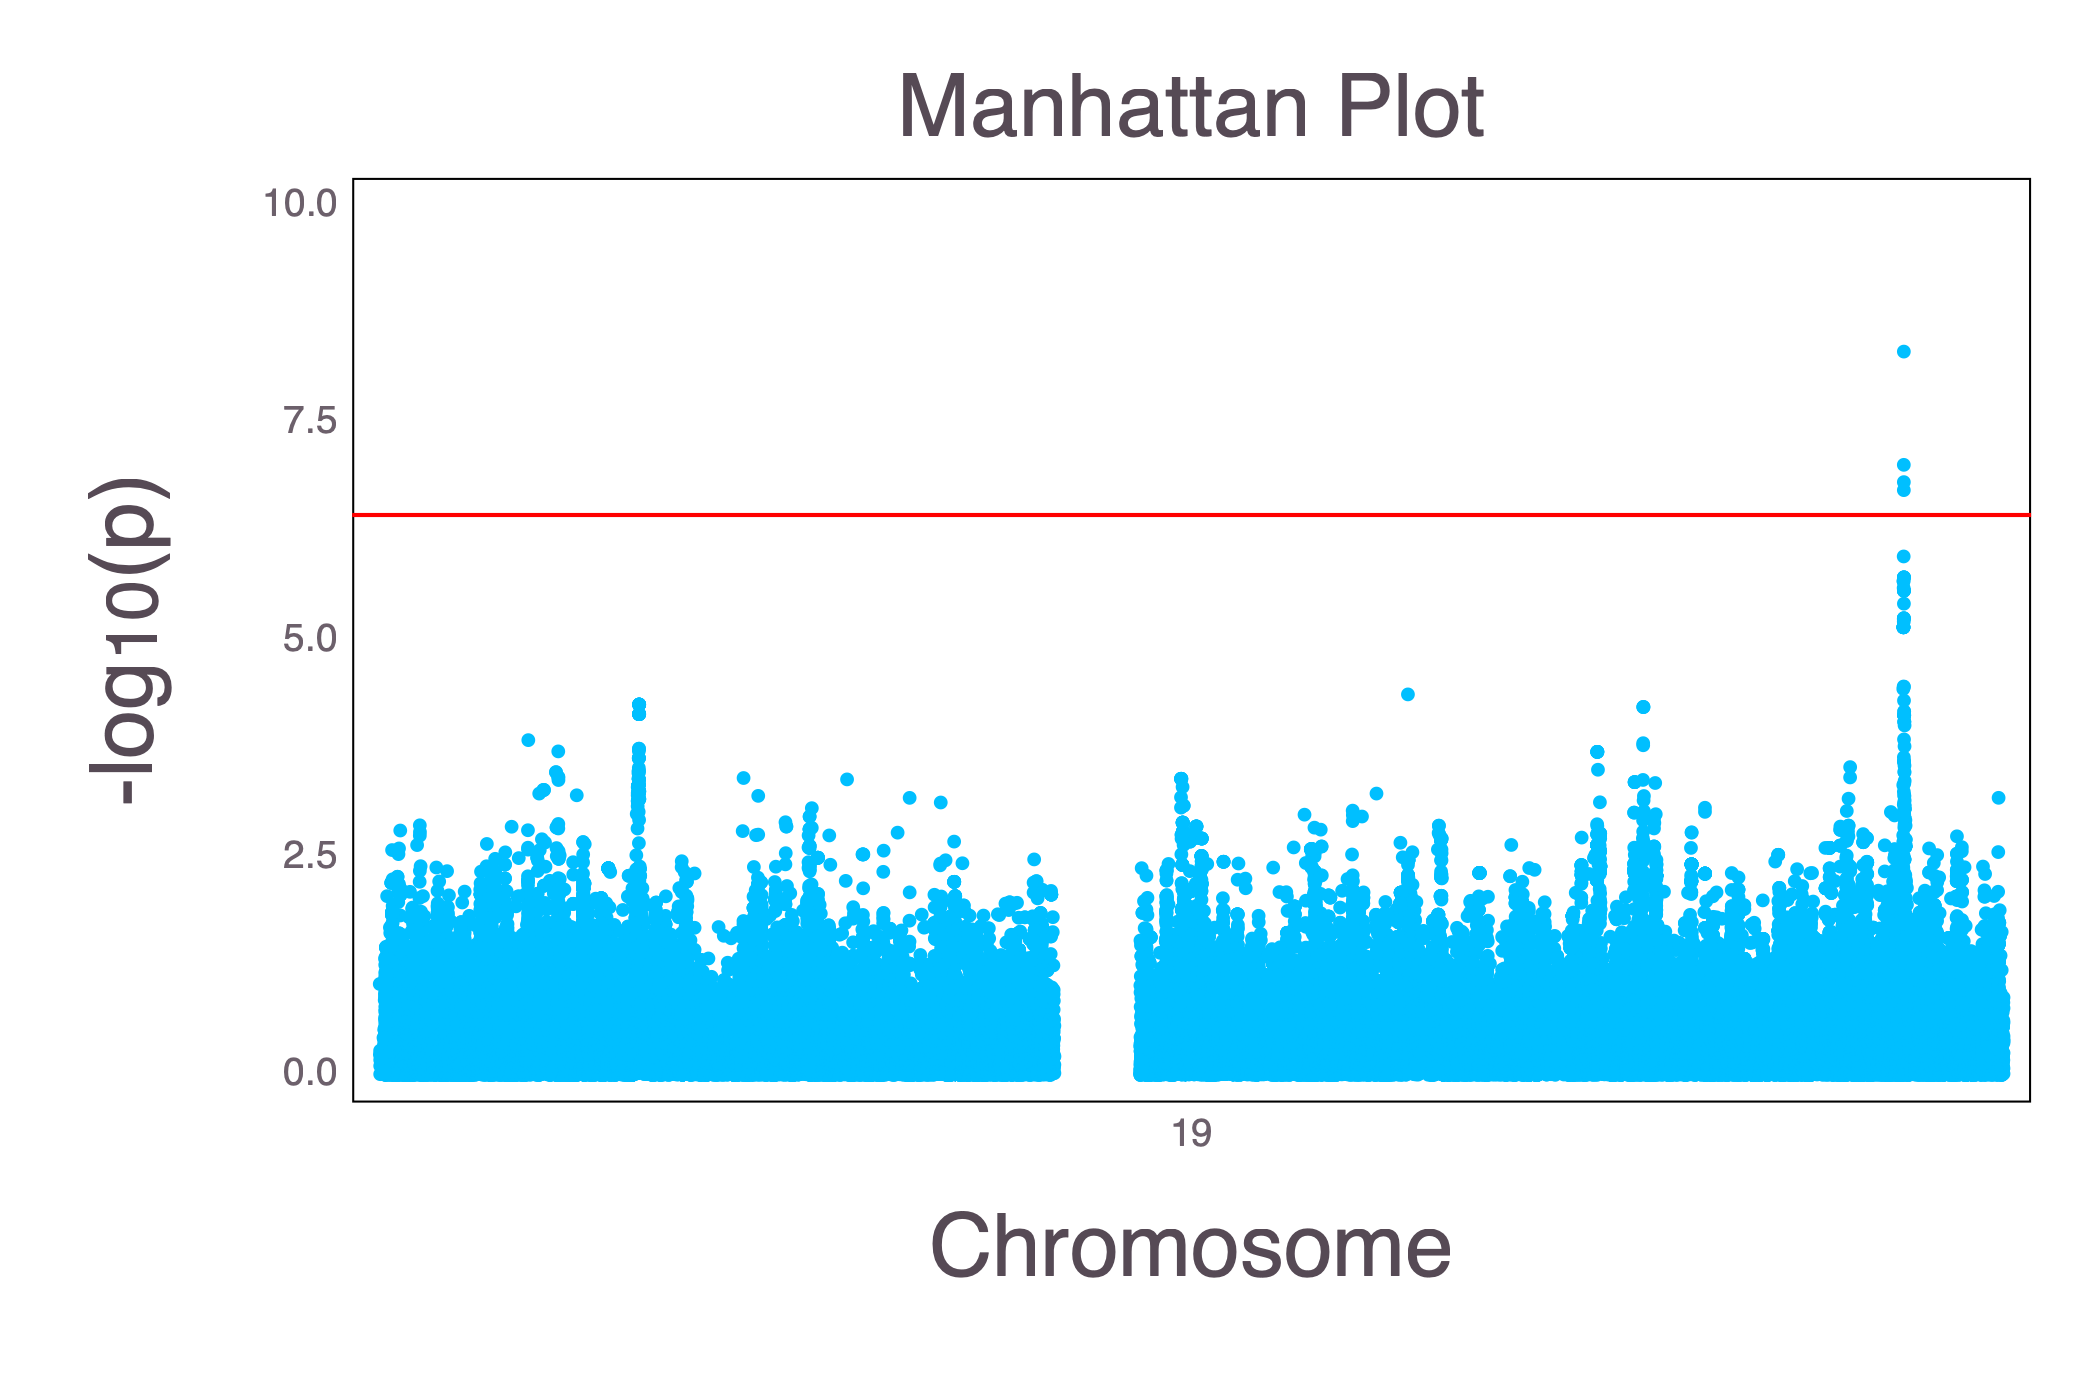

In [20]:
 display("image/png", read("lmmGWAS_manhattan.png")) 